<a href="https://colab.research.google.com/github/jishu123456789/ML_SRIP-24/blob/main/OneVsAll_Pretrained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print(device)

Mounted at /content/drive
cuda


In [ ]:
"Let us first divide the test and train data into proper format"

import os
import shutil
import random

base_dir = "animals"

animal_dir = "//content//drive//My Drive//DeepLearningCollab//Animal"
os.makedirs(animal_dir , exist_ok=True)

# Now we go into the directry containing the animals


source_dir = "//content//drive//My Drive//DeepLearningCollab//animals"

#Destination Directories

train_dir = os.path.join(animal_dir , 'train')
test_dir = os.path.join(animal_dir , 'test')

"If train and test directories do not exist"

os.makedirs(train_dir , exist_ok=True)
os.makedirs(test_dir , exist_ok=True)

"Now  we can list all the directories in source_dir"

animal_directories_list = os.listdir(source_dir)

"Now we will loop through the directories"

for animal in animal_directories_list:
    animal_D = os.path.join(source_dir , animal)

    # Get a list of all the image files in the directory animal_D
    images = [i for i in os.listdir(animal_D) if os.path.isfile(os.path.join(animal_D , i))]

    train_test_spllit = 0.8

    num_train = int(len(images) * train_test_spllit)

    random.shuffle(images) # Shuffle the images randomly
    train_images = images[:num_train]

    test_images = images[num_train:]


    # Now we have already created test and train directory but here we have to also create test and train for each of the animals

    train_dir_animal = os.path.join(train_dir , animal)
    test_dir_animal = os.path.join(test_dir , animal)

    os.makedirs(train_dir_animal , exist_ok=True)
    os.makedirs(test_dir_animal , exist_ok=True)

    "Finally we have to move all the images from source directory to destination directory using shuttle"
    for img in train_images:
        shutil.move(os.path.join(animal_D , img) , os.path.join(train_dir_animal , img))
    for img in test_images:
        shutil.move(os.path.join(animal_D , img) , os.path.join(test_dir_animal , img))

In [ ]:
from pathlib import Path


train_path = os.path.join(animal_dir , "train")
test_path = os.path.join(animal_dir , "test")

animal_dir = Path(animal_dir)



# Using This we have also found out the class names and now we can convert them into Dict format

from typing import Tuple , Dict , List
train_path = Path(train_path)
test_path = Path(test_path)

def find_classes(directory : str) -> Tuple[List[str] , Dict[str,int]] :

    "Get the class_names first"

    classes = sorted(
        entry.name for entry in list(os.scandir(directory)) if entry.is_dir()
    )

    # Get the case to handle any kind of error

    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    classes_to_idx = {cls_name : i for i , cls_name in enumerate(classes)}

    return classes , classes_to_idx

In [ ]:
"Now we will enter into the part where we will be transforming the image and creating Datasets and DataLoaders"
from torch.utils.data import DataLoader , TensorDataset , Dataset
from torchvision import transforms
import random
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

"Lets write the transform for training Data and Testing Data"

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p = 0.5), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

"""
Creating The Custom Dataset For One Vs Rest Classification:

1) In the custom dataset we must take in decide which will be our target class and which will be the other classes.
2) The target class will have the label as 1 and the other classes will have label as 0

"""
class CustomDataset(Dataset):

    def __init__(self , target_class_index , target_directory : str , transform = None):
        super().__init__()
        self.label = []
        self.img = []
        self.transform = transform

        # Here we can find the classes using find classes method

        classes , _ = find_classes(target_directory)
        target_class_name = classes[target_class_index]

        for Class in classes:

            if(Class == target_class_name):
              limit = 1
            else:
              limit = 0.1

            directory = os.path.join(target_directory , Class)
            for l , name in enumerate(os.listdir(directory)):
                if(l>=limit*len(os.listdir(directory))):
                    break
                final_path = os.path.join(directory , name)
                self.img.append(final_path)

                if(Class == target_class_name):
                    self.label.append(1)
                else:
                    self.label.append(0)

    def __len__(self):
        return len(self.img)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.img[index]
        img = Image.open(image_path)
        return img

    def __getitem__(self, idx: int):
        image = Image.open(self.img[idx])


        Label = self.label[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(Label, dtype=torch.long)

antelope
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


Epoch 0 running
[Train #1] Loss: 0.0169 Acc: 90.8537%
[Test #1] Loss: 0.0078 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 96.9512%
[Test #2] Loss: 0.0049 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0040 Acc: 97.8659%
[Test #3] Loss: 0.0040 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 99.0854%
[Test #4] Loss: 0.0041 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.0854%
[Test #5] Loss: 0.0054 Acc: 95.1515% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0167 Acc: 90.5775%
[Test #1] Loss: 0.0068 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0058 Acc: 98.1763%
[Test #2] Loss: 0.0053 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 97.5684%
[Test #3] Loss: 0.0043 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.6960%
[Test #4] Loss: 0.0043 Acc: 95.7317% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 97.8723%
[Test #5] Loss: 0.0039 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0169 Acc: 89.6657%
[Test 

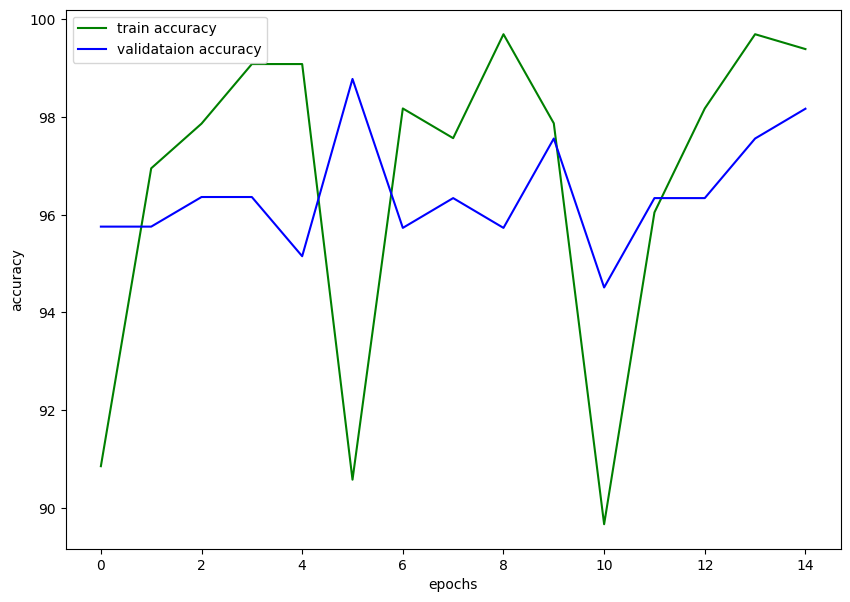

badger
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0208 Acc: 78.3537%
[Test #1] Loss: 0.0073 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 97.8659%
[Test #2] Loss: 0.0043 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 97.5610%
[Test #3] Loss: 0.0031 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0035 Acc: 97.5610%
[Test #4] Loss: 0.0031 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0031 Acc: 98.1707%
[Test #5] Loss: 0.0026 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0166 Acc: 91.4894%
[Test #1] Loss: 0.0071 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0056 Acc: 98.1763%
[Test #2] Loss: 0.0043 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0046 Acc: 97.5684%
[Test #3] Loss: 0.0027 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 97.8723%
[Test #4] Loss: 0.0033 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0032 Acc: 97.5684%
[Test #5] Loss: 0.0034 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 93.0091%
[Test 

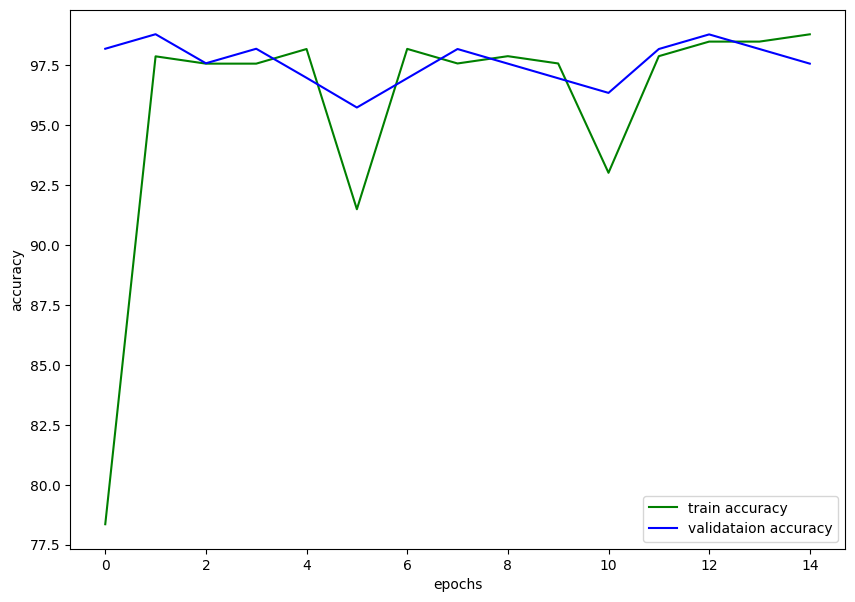

bat
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0187 Acc: 88.7195%
[Test #1] Loss: 0.0105 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0059 Acc: 98.7805%
[Test #2] Loss: 0.0046 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.1707%
[Test #3] Loss: 0.0041 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.7805%
[Test #4] Loss: 0.0030 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.7805%
[Test #5] Loss: 0.0030 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0242 Acc: 69.3009%
[Test #1] Loss: 0.0130 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0084 Acc: 96.6565%
[Test #2] Loss: 0.0060 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 97.5684%
[Test #3] Loss: 0.0045 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0030 Acc: 98.4802%
[Test #4] Loss: 0.0037 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 97.8723%
[Test #5] Loss: 0.0023 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0205 Acc: 79.9392%
[Test 

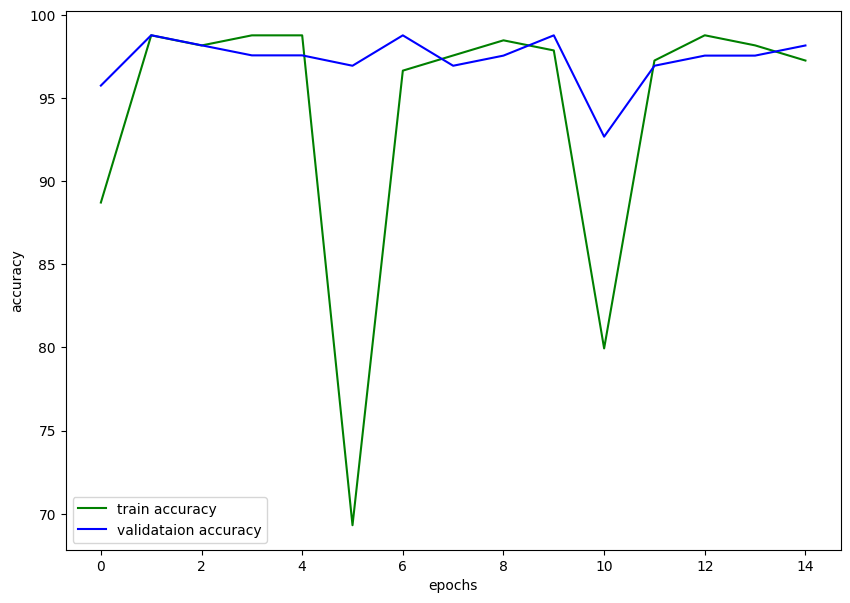

bear
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0164 Acc: 90.8537%
[Test #1] Loss: 0.0057 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0058 Acc: 96.6463%
[Test #2] Loss: 0.0037 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 97.8659%
[Test #3] Loss: 0.0025 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0032 Acc: 97.8659%
[Test #4] Loss: 0.0036 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0023 Acc: 98.7805%
[Test #5] Loss: 0.0018 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0208 Acc: 80.5471%
[Test #1] Loss: 0.0092 Acc: 95.1220% 
Epoch 1 running
[Train #2] Loss: 0.0074 Acc: 95.4407%
[Test #2] Loss: 0.0072 Acc: 94.5122% 
Epoch 2 running
[Train #3] Loss: 0.0042 Acc: 97.5684%
[Test #3] Loss: 0.0035 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0036 Acc: 97.8723%
[Test #4] Loss: 0.0024 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 99.0881%
[Test #5] Loss: 0.0066 Acc: 93.9024% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0154 Acc: 93.6170%
[Test 

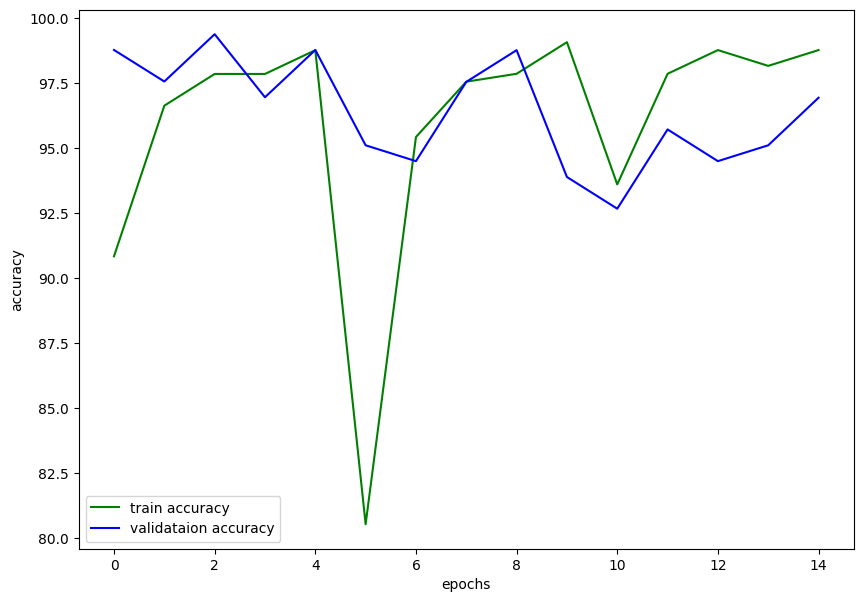

bee
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0234 Acc: 71.3415%
[Test #1] Loss: 0.0108 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0070 Acc: 97.8659%
[Test #2] Loss: 0.0052 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0040 Acc: 97.5610%
[Test #3] Loss: 0.0019 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0015 Acc: 99.6951%
[Test #4] Loss: 0.0013 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.4756%
[Test #5] Loss: 0.0010 Acc: 100.0000% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0144 Acc: 94.5289%
[Test #1] Loss: 0.0072 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0044 Acc: 98.1763%
[Test #2] Loss: 0.0043 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.1763%
[Test #3] Loss: 0.0038 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 99.3921%
[Test #4] Loss: 0.0034 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0010 Acc: 99.6960%
[Test #5] Loss: 0.0019 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0232 Acc: 70.8207%
[Te

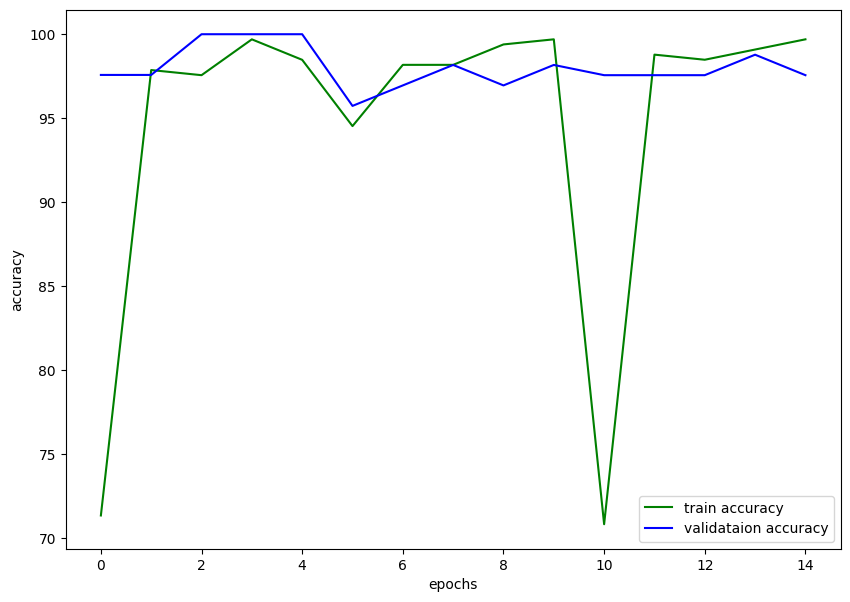

beetle
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0225 Acc: 72.8659%
[Test #1] Loss: 0.0102 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 99.0854%
[Test #2] Loss: 0.0061 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.7805%
[Test #3] Loss: 0.0043 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.1707%
[Test #4] Loss: 0.0041 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.7805%
[Test #5] Loss: 0.0034 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0145 Acc: 92.0973%
[Test #1] Loss: 0.0051 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0046 Acc: 98.4802%
[Test #2] Loss: 0.0034 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7842%
[Test #3] Loss: 0.0028 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 98.4802%
[Test #4] Loss: 0.0048 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0008 Acc: 100.0000%
[Test #5] Loss: 0.0049 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0232 Acc: 71.7325%
[Test

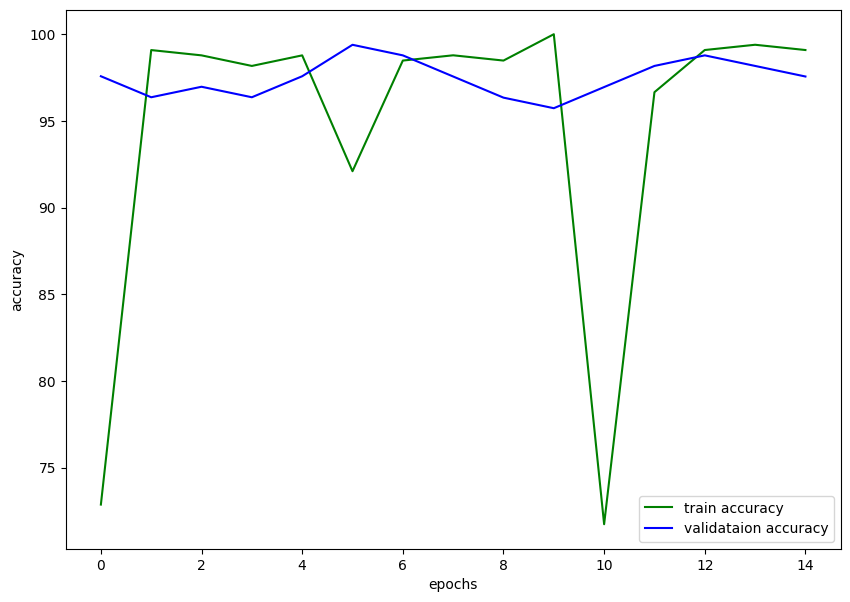

bison
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0169 Acc: 90.8537%
[Test #1] Loss: 0.0073 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0054 Acc: 96.6463%
[Test #2] Loss: 0.0039 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.4756%
[Test #3] Loss: 0.0026 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0030 Acc: 98.1707%
[Test #4] Loss: 0.0020 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 97.5610%
[Test #5] Loss: 0.0028 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0111 Acc: 94.2249%
[Test #1] Loss: 0.0058 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0043 Acc: 98.1763%
[Test #2] Loss: 0.0033 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.1763%
[Test #3] Loss: 0.0028 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 98.7842%
[Test #4] Loss: 0.0019 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0024 Acc: 98.4802%
[Test #5] Loss: 0.0020 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0171 Acc: 88.1459%
[Test 

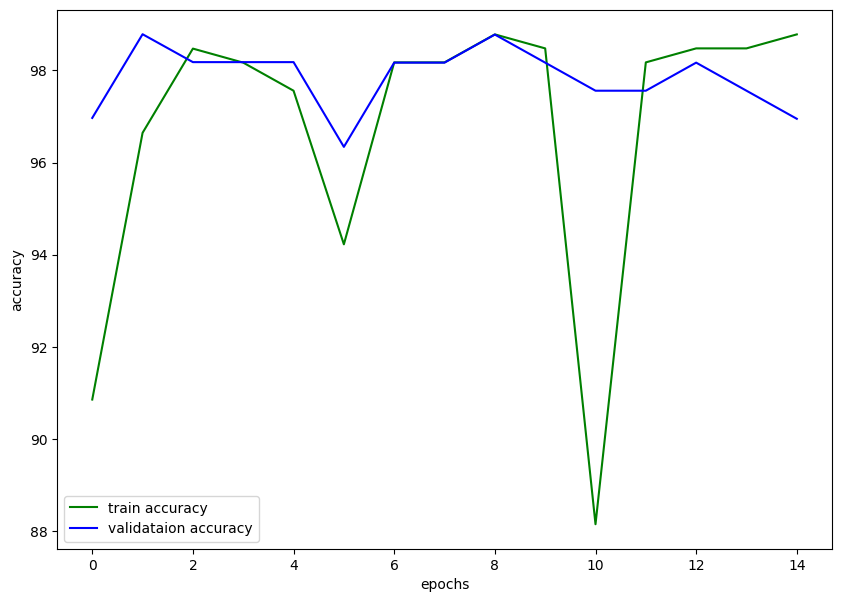

boar
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0131 Acc: 93.5976%
[Test #1] Loss: 0.0069 Acc: 93.9394% 
Epoch 1 running
[Train #2] Loss: 0.0044 Acc: 97.8659%
[Test #2] Loss: 0.0035 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.7805%
[Test #3] Loss: 0.0024 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 98.1707%
[Test #4] Loss: 0.0023 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0028 Acc: 98.1707%
[Test #5] Loss: 0.0045 Acc: 95.1515% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0236 Acc: 68.9970%
[Test #1] Loss: 0.0092 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0075 Acc: 96.3526%
[Test #2] Loss: 0.0053 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0043 Acc: 96.6565%
[Test #3] Loss: 0.0040 Acc: 95.7317% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 98.4802%
[Test #4] Loss: 0.0034 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 97.8723%
[Test #5] Loss: 0.0025 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0195 Acc: 83.5866%
[Test 

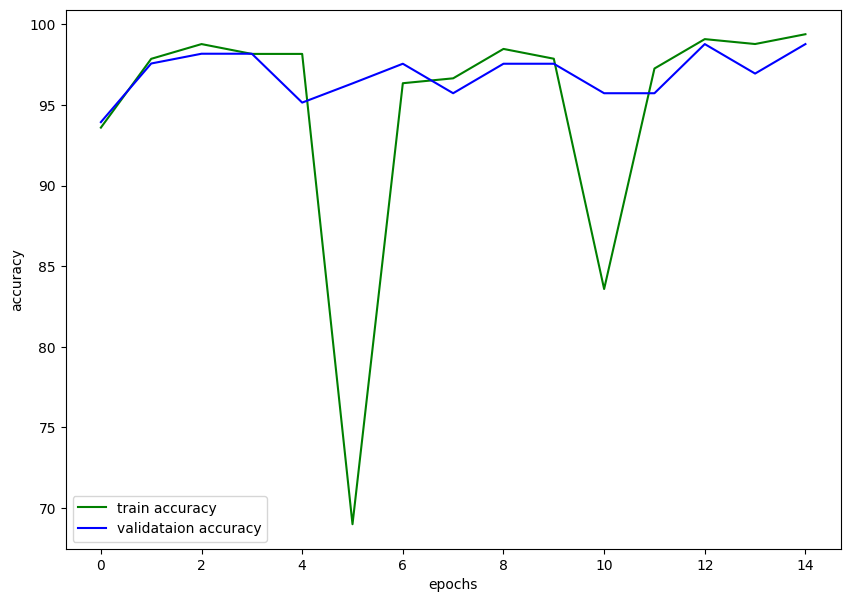

butterfly
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0166 Acc: 92.0732%
[Test #1] Loss: 0.0061 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 98.4756%
[Test #2] Loss: 0.0036 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.7805%
[Test #3] Loss: 0.0032 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0013 Acc: 99.3902%
[Test #4] Loss: 0.0012 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.0854%
[Test #5] Loss: 0.0024 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0211 Acc: 79.3313%
[Test #1] Loss: 0.0084 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 99.3921%
[Test #2] Loss: 0.0071 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.4802%
[Test #3] Loss: 0.0099 Acc: 93.2927% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 98.7842%
[Test #4] Loss: 0.0054 Acc: 95.7317% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.0881%
[Test #5] Loss: 0.0050 Acc: 93.9024% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0202 Acc: 81.4590%
[Test

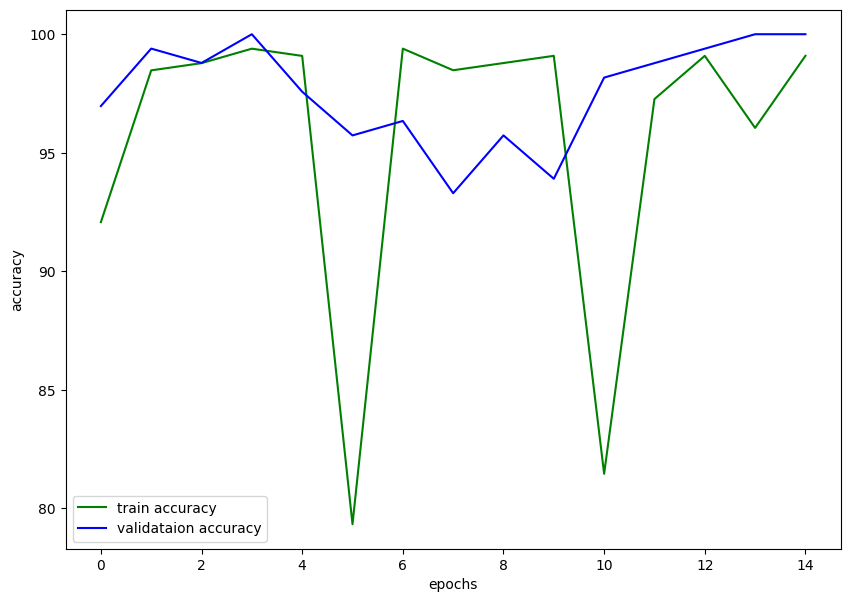

cat
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0272 Acc: 60.0610%
[Test #1] Loss: 0.0084 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0073 Acc: 98.7805%
[Test #2] Loss: 0.0052 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0044 Acc: 97.8659%
[Test #3] Loss: 0.0035 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 98.4756%
[Test #4] Loss: 0.0029 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.3902%
[Test #5] Loss: 0.0027 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0167 Acc: 88.4498%
[Test #1] Loss: 0.0065 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0047 Acc: 98.1763%
[Test #2] Loss: 0.0040 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7842%
[Test #3] Loss: 0.0034 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0032 Acc: 97.8723%
[Test #4] Loss: 0.0040 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0013 Acc: 99.3921%
[Test #5] Loss: 0.0033 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 93.3131%
[Test 

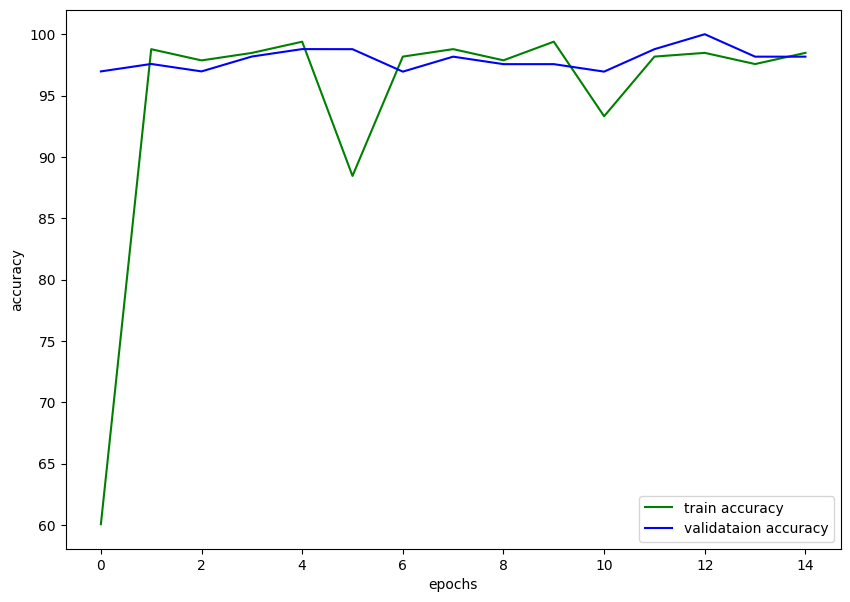

caterpillar
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0214 Acc: 77.7439%
[Test #1] Loss: 0.0093 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 98.1707%
[Test #2] Loss: 0.0047 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.4756%
[Test #3] Loss: 0.0040 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 99.0854%
[Test #4] Loss: 0.0046 Acc: 95.7576% 
Epoch 4 running
[Train #5] Loss: 0.0010 Acc: 99.6951%
[Test #5] Loss: 0.0047 Acc: 95.7576% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0150 Acc: 94.2249%
[Test #1] Loss: 0.0066 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0050 Acc: 96.9605%
[Test #2] Loss: 0.0041 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.1763%
[Test #3] Loss: 0.0037 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.0881%
[Test #4] Loss: 0.0024 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0012 Acc: 99.0881%
[Test #5] Loss: 0.0036 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0167 Acc: 90.5775%
[Test 

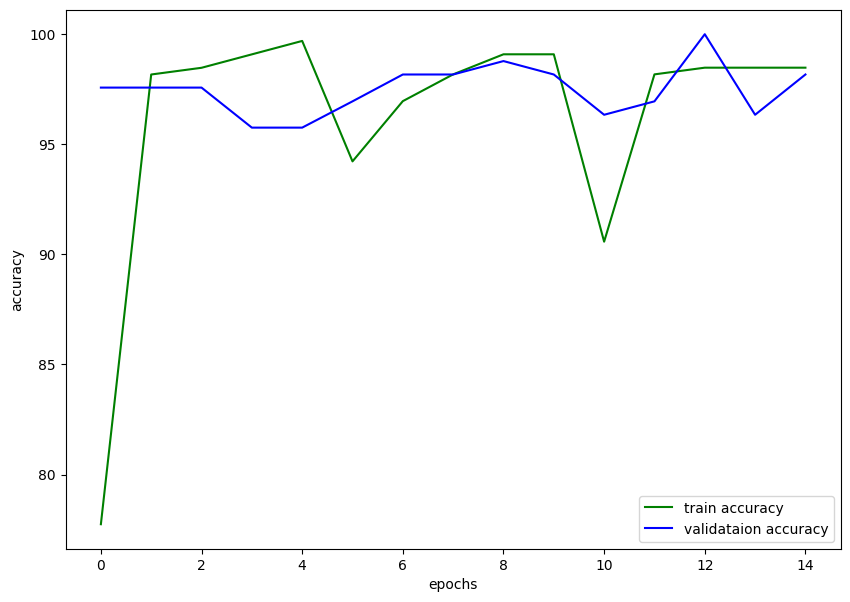

chimpanzee
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0216 Acc: 75.0000%
[Test #1] Loss: 0.0085 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 98.4756%
[Test #2] Loss: 0.0047 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.4756%
[Test #3] Loss: 0.0028 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.4756%
[Test #4] Loss: 0.0028 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 99.0854%
[Test #5] Loss: 0.0019 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0206 Acc: 78.4195%
[Test #1] Loss: 0.0064 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 98.4802%
[Test #2] Loss: 0.0036 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7842%
[Test #3] Loss: 0.0037 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 99.0881%
[Test #4] Loss: 0.0020 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0029 Acc: 98.1763%
[Test #5] Loss: 0.0037 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0177 Acc: 87.5380%
[Test

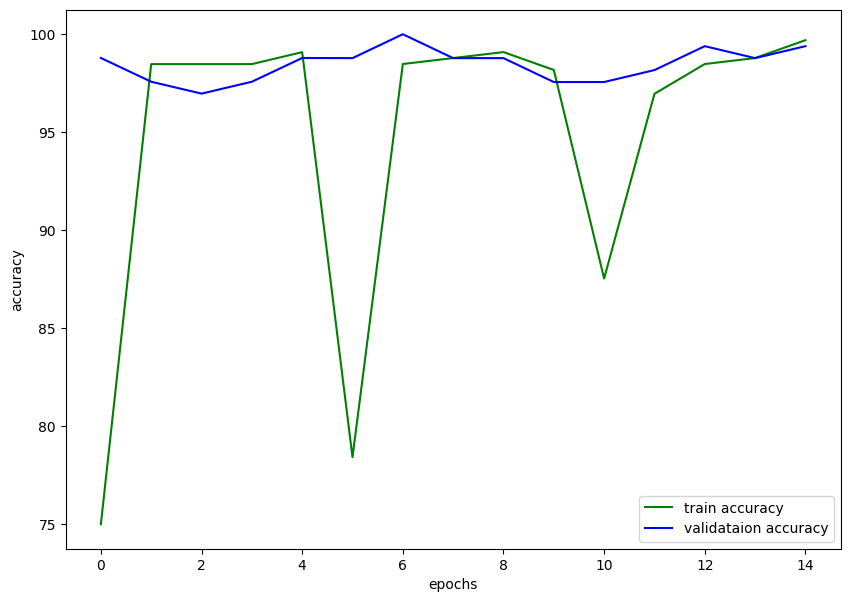

cockroach
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0142 Acc: 95.4268%
[Test #1] Loss: 0.0060 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0044 Acc: 97.5610%
[Test #2] Loss: 0.0037 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0021 Acc: 98.7805%
[Test #3] Loss: 0.0034 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.4756%
[Test #4] Loss: 0.0023 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0008 Acc: 99.6951%
[Test #5] Loss: 0.0020 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0149 Acc: 94.2249%
[Test #1] Loss: 0.0069 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0044 Acc: 97.5684%
[Test #2] Loss: 0.0043 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.1763%
[Test #3] Loss: 0.0022 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.3921%
[Test #4] Loss: 0.0015 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0009 Acc: 99.6960%
[Test #5] Loss: 0.0036 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0115 Acc: 94.8328%
[Test 

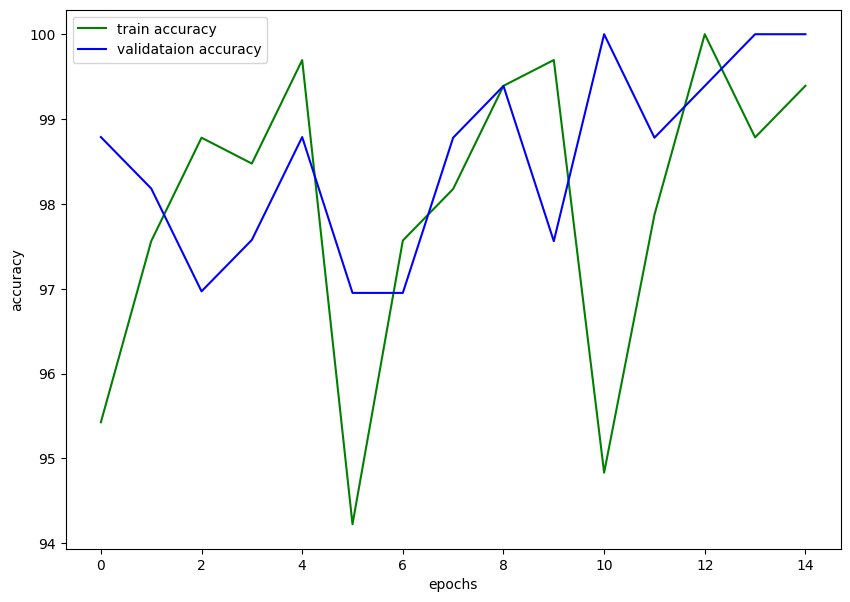

cow
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0198 Acc: 85.0610%
[Test #1] Loss: 0.0083 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 98.1707%
[Test #2] Loss: 0.0051 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 97.8659%
[Test #3] Loss: 0.0045 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.1707%
[Test #4] Loss: 0.0029 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 99.0854%
[Test #5] Loss: 0.0032 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0183 Acc: 87.8419%
[Test #1] Loss: 0.0099 Acc: 93.9024% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 96.6565%
[Test #2] Loss: 0.0064 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 98.7842%
[Test #3] Loss: 0.0063 Acc: 93.9024% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 98.7842%
[Test #4] Loss: 0.0069 Acc: 95.7317% 
Epoch 4 running
[Train #5] Loss: 0.0036 Acc: 96.9605%
[Test #5] Loss: 0.0064 Acc: 94.5122% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0153 Acc: 92.4012%
[Test 

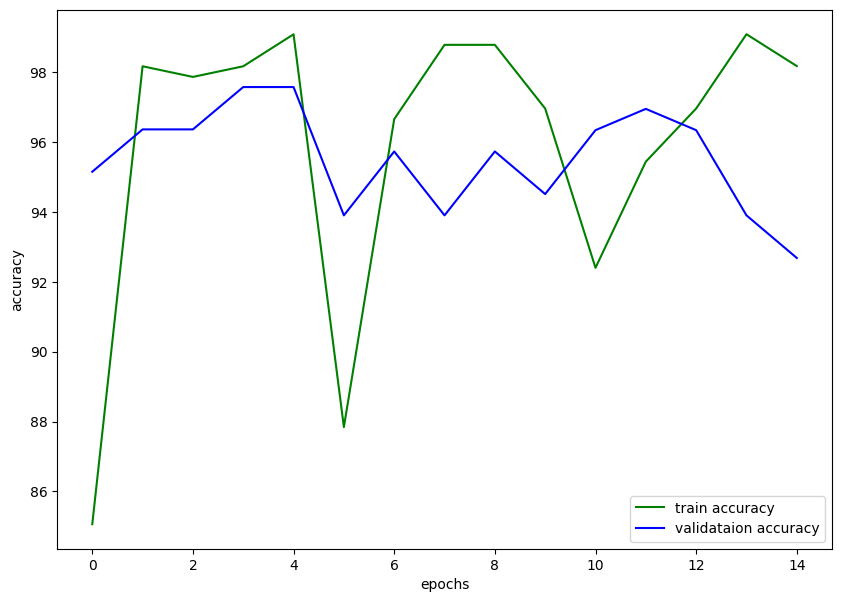

coyote
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0158 Acc: 94.2073%
[Test #1] Loss: 0.0053 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 97.2561%
[Test #2] Loss: 0.0036 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 98.4756%
[Test #3] Loss: 0.0031 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.7805%
[Test #4] Loss: 0.0029 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.7805%
[Test #5] Loss: 0.0035 Acc: 95.1515% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0189 Acc: 85.1064%
[Test #1] Loss: 0.0073 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0062 Acc: 97.5684%
[Test #2] Loss: 0.0065 Acc: 95.1220% 
Epoch 2 running
[Train #3] Loss: 0.0037 Acc: 97.8723%
[Test #3] Loss: 0.0041 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.6960%
[Test #4] Loss: 0.0039 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.7842%
[Test #5] Loss: 0.0055 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0213 Acc: 75.0760%
[Test 

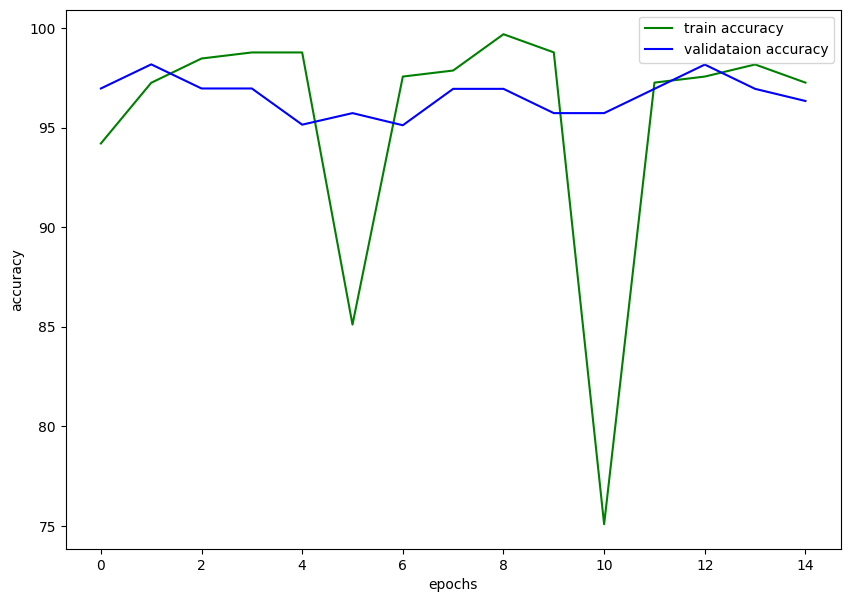

crab
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 82.9268%
[Test #1] Loss: 0.0082 Acc: 96.3636% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 97.5610%
[Test #2] Loss: 0.0047 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 99.0854%
[Test #3] Loss: 0.0032 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.7805%
[Test #4] Loss: 0.0035 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.3902%
[Test #5] Loss: 0.0029 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0233 Acc: 70.5167%
[Test #1] Loss: 0.0098 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0070 Acc: 96.9605%
[Test #2] Loss: 0.0069 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 97.5684%
[Test #3] Loss: 0.0029 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 99.3921%
[Test #4] Loss: 0.0040 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.4802%
[Test #5] Loss: 0.0030 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0202 Acc: 76.2918%
[Test 

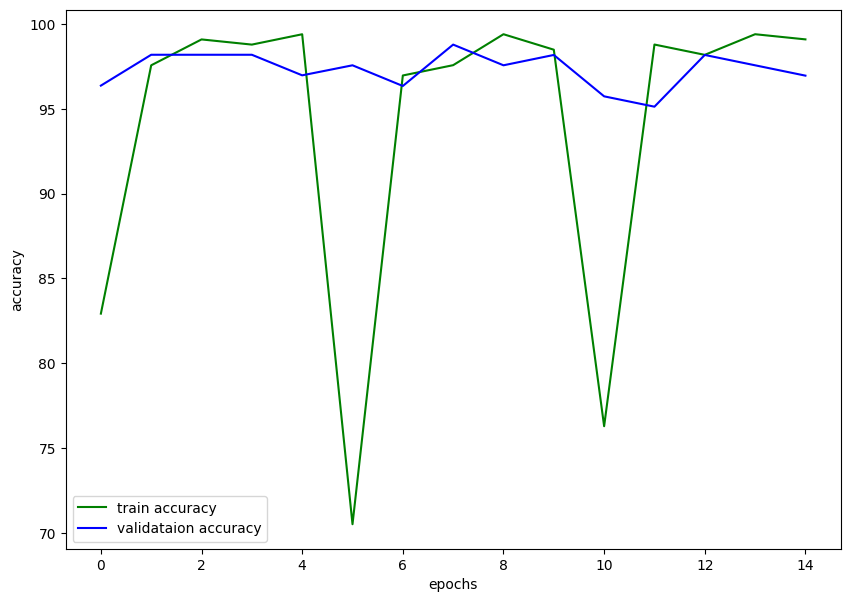

crow
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 92.9878%
[Test #1] Loss: 0.0063 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0046 Acc: 98.1707%
[Test #2] Loss: 0.0027 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0021 Acc: 98.7805%
[Test #3] Loss: 0.0031 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 97.8659%
[Test #4] Loss: 0.0026 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 98.7805%
[Test #5] Loss: 0.0030 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0166 Acc: 90.8815%
[Test #1] Loss: 0.0069 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 98.4802%
[Test #2] Loss: 0.0027 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0023 Acc: 99.3921%
[Test #3] Loss: 0.0019 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 98.4802%
[Test #4] Loss: 0.0016 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.1763%
[Test #5] Loss: 0.0019 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0210 Acc: 75.9878%
[Tes

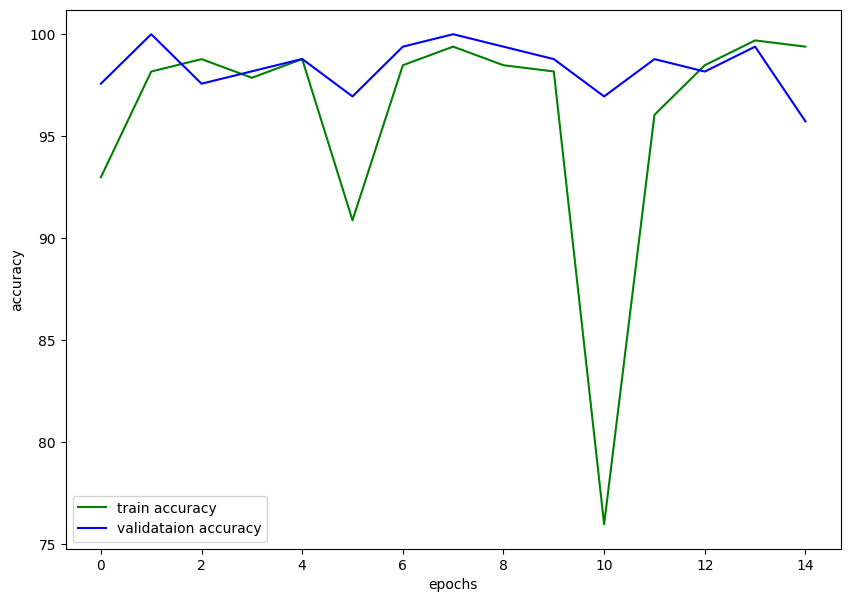

deer
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0152 Acc: 91.4634%
[Test #1] Loss: 0.0087 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0068 Acc: 96.9512%
[Test #2] Loss: 0.0062 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0035 Acc: 98.4756%
[Test #3] Loss: 0.0044 Acc: 95.7576% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 98.4756%
[Test #4] Loss: 0.0058 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 98.4756%
[Test #5] Loss: 0.0060 Acc: 95.1515% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0151 Acc: 90.8815%
[Test #1] Loss: 0.0074 Acc: 95.1220% 
Epoch 1 running
[Train #2] Loss: 0.0065 Acc: 96.0486%
[Test #2] Loss: 0.0041 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 96.9605%
[Test #3] Loss: 0.0040 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0033 Acc: 97.2644%
[Test #4] Loss: 0.0041 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.4802%
[Test #5] Loss: 0.0046 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0216 Acc: 79.9392%
[Test 

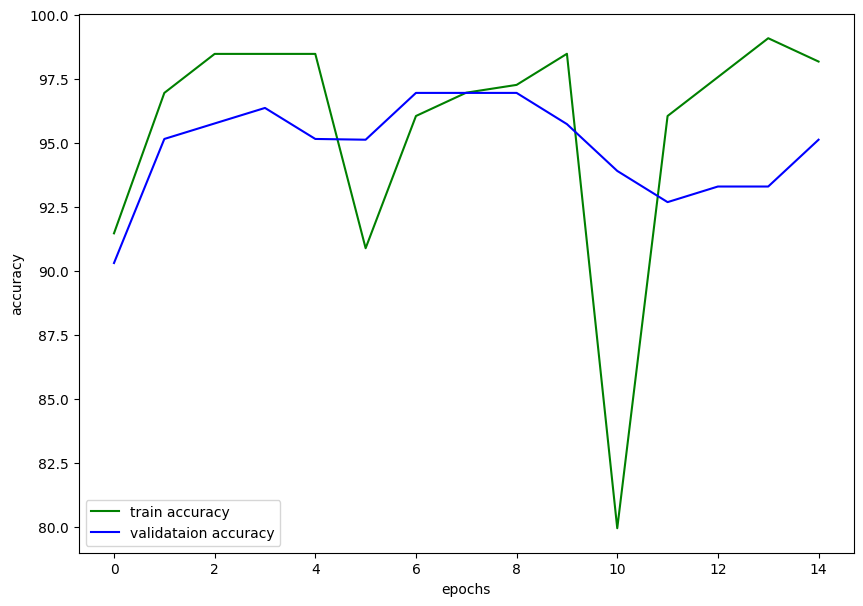

dog
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 89.9390%
[Test #1] Loss: 0.0072 Acc: 93.3333% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 97.8659%
[Test #2] Loss: 0.0042 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0035 Acc: 98.4756%
[Test #3] Loss: 0.0035 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.6951%
[Test #4] Loss: 0.0039 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.4756%
[Test #5] Loss: 0.0034 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0225 Acc: 74.7720%
[Test #1] Loss: 0.0096 Acc: 93.9024% 
Epoch 1 running
[Train #2] Loss: 0.0076 Acc: 97.2644%
[Test #2] Loss: 0.0055 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 99.6960%
[Test #3] Loss: 0.0053 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 99.3921%
[Test #4] Loss: 0.0046 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.1763%
[Test #5] Loss: 0.0041 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0225 Acc: 73.5562%
[Test 

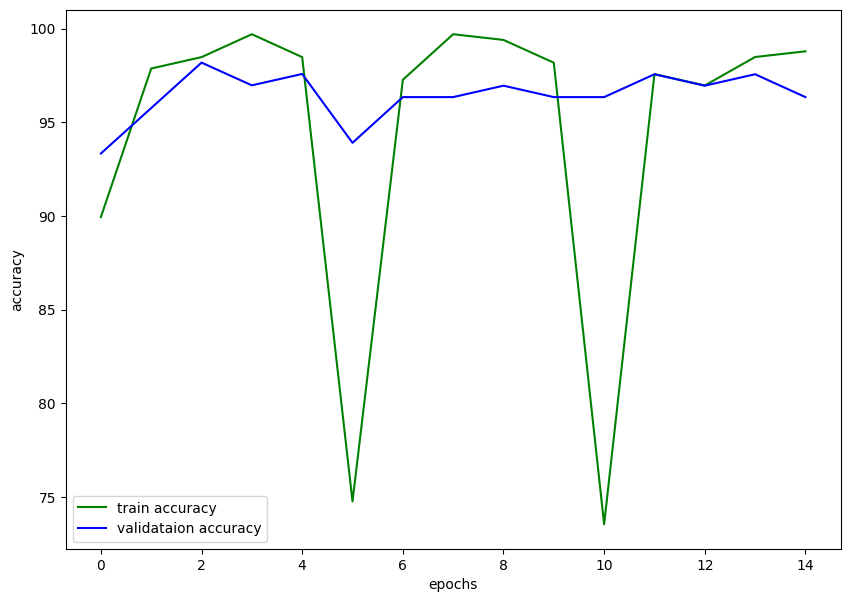

dolphin
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0238 Acc: 71.6463%
[Test #1] Loss: 0.0094 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0072 Acc: 96.6463%
[Test #2] Loss: 0.0053 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 99.0854%
[Test #3] Loss: 0.0047 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0034 Acc: 98.1707%
[Test #4] Loss: 0.0047 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.0854%
[Test #5] Loss: 0.0030 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0167 Acc: 89.3617%
[Test #1] Loss: 0.0060 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 97.2644%
[Test #2] Loss: 0.0038 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0035 Acc: 98.1763%
[Test #3] Loss: 0.0018 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0012 Acc: 99.6960%
[Test #4] Loss: 0.0038 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 98.7842%
[Test #5] Loss: 0.0018 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0206 Acc: 80.2432%
[Test

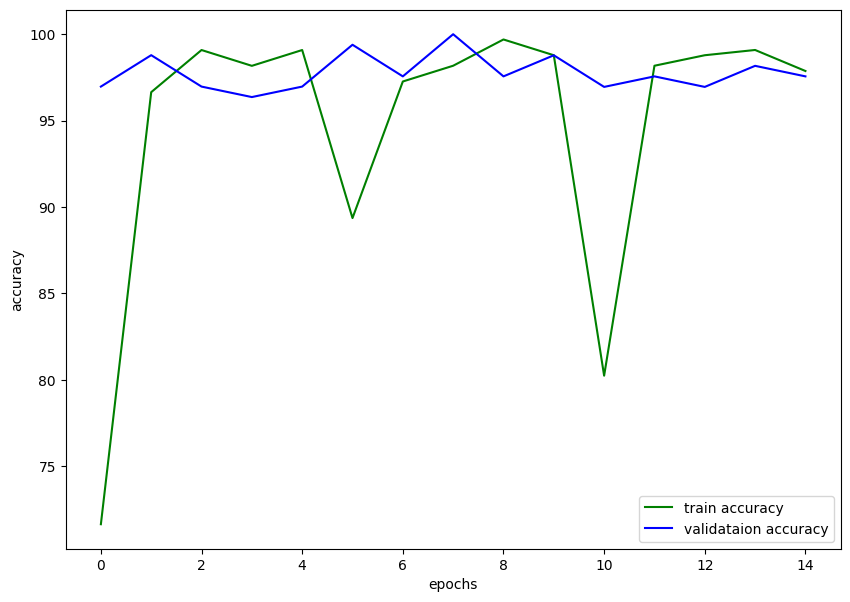

donkey
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0288 Acc: 55.4878%
[Test #1] Loss: 0.0132 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0100 Acc: 96.9512%
[Test #2] Loss: 0.0074 Acc: 94.5455% 
Epoch 2 running
[Train #3] Loss: 0.0050 Acc: 97.5610%
[Test #3] Loss: 0.0068 Acc: 95.7576% 
Epoch 3 running
[Train #4] Loss: 0.0042 Acc: 97.8659%
[Test #4] Loss: 0.0073 Acc: 93.3333% 
Epoch 4 running
[Train #5] Loss: 0.0037 Acc: 97.2561%
[Test #5] Loss: 0.0065 Acc: 93.3333% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0229 Acc: 72.9483%
[Test #1] Loss: 0.0108 Acc: 94.5122% 
Epoch 1 running
[Train #2] Loss: 0.0080 Acc: 96.3526%
[Test #2] Loss: 0.0058 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 98.7842%
[Test #3] Loss: 0.0038 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.0881%
[Test #4] Loss: 0.0049 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.0881%
[Test #5] Loss: 0.0032 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0171 Acc: 89.6657%
[Test 

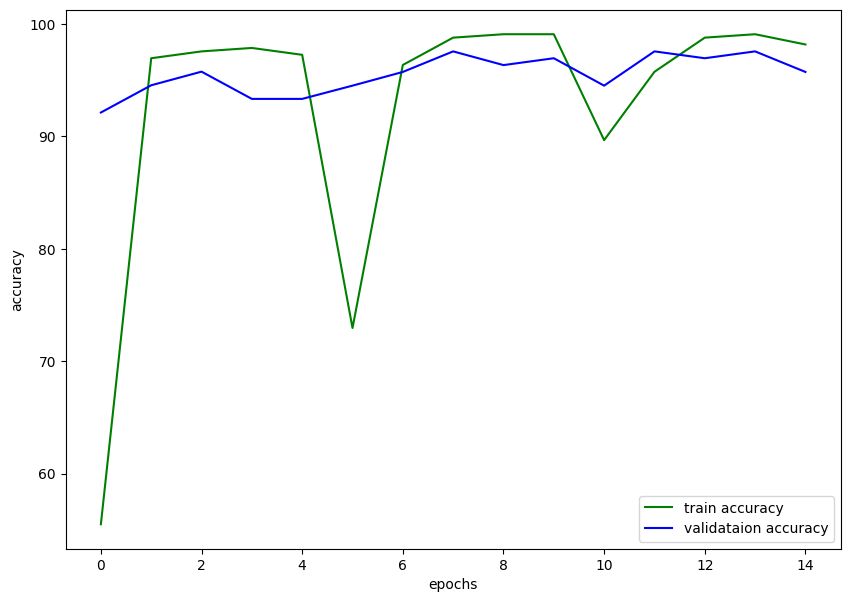

dragonfly
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0189 Acc: 84.7561%
[Test #1] Loss: 0.0085 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0047 Acc: 98.7805%
[Test #2] Loss: 0.0044 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.1707%
[Test #3] Loss: 0.0032 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0012 Acc: 99.6951%
[Test #4] Loss: 0.0033 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 98.7805%
[Test #5] Loss: 0.0027 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0171 Acc: 90.2736%
[Test #1] Loss: 0.0081 Acc: 95.1220% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 97.5684%
[Test #2] Loss: 0.0053 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.7842%
[Test #3] Loss: 0.0055 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 99.0881%
[Test #4] Loss: 0.0025 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.0881%
[Test #5] Loss: 0.0019 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 79.9392%
[Test 

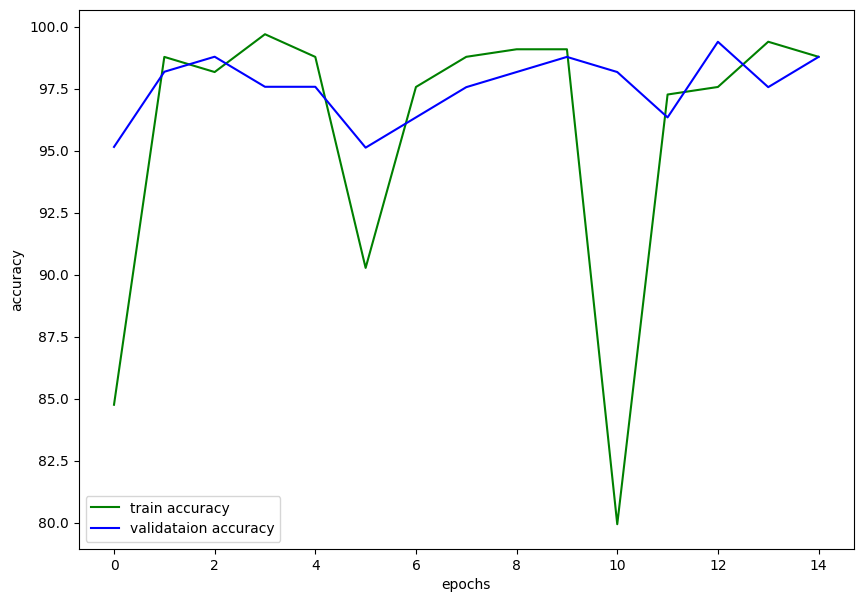

duck
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0200 Acc: 83.5366%
[Test #1] Loss: 0.0106 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0079 Acc: 97.8659%
[Test #2] Loss: 0.0069 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 97.8659%
[Test #3] Loss: 0.0054 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.4756%
[Test #4] Loss: 0.0035 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0023 Acc: 98.7805%
[Test #5] Loss: 0.0047 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0250 Acc: 65.6535%
[Test #1] Loss: 0.0100 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0076 Acc: 97.2644%
[Test #2] Loss: 0.0060 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0047 Acc: 96.9605%
[Test #3] Loss: 0.0055 Acc: 93.9024% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.4802%
[Test #4] Loss: 0.0037 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 99.0881%
[Test #5] Loss: 0.0037 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0226 Acc: 74.7720%
[Test 

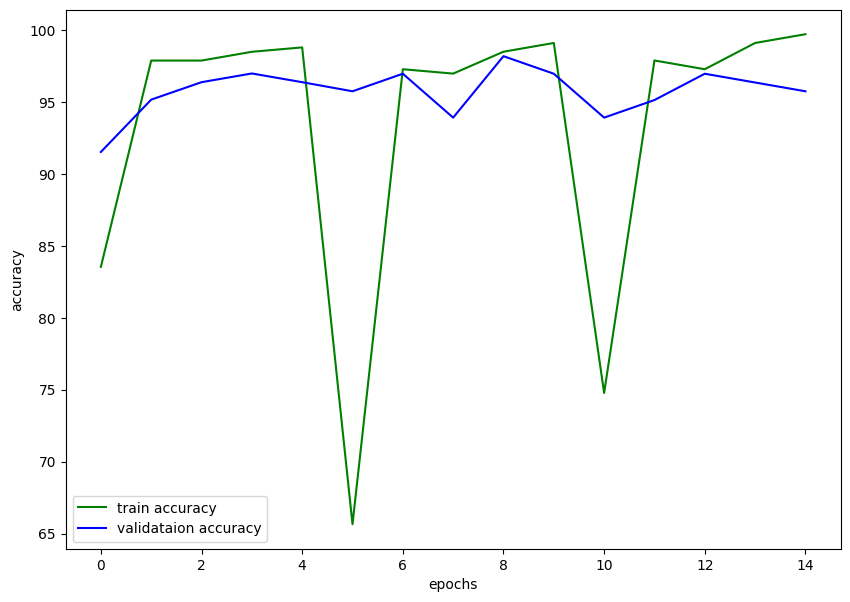

eagle
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0232 Acc: 70.4268%
[Test #1] Loss: 0.0096 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0062 Acc: 98.1707%
[Test #2] Loss: 0.0039 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 98.1707%
[Test #3] Loss: 0.0021 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0033 Acc: 97.2561%
[Test #4] Loss: 0.0031 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 98.7805%
[Test #5] Loss: 0.0015 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0194 Acc: 83.8906%
[Test #1] Loss: 0.0061 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0058 Acc: 97.8723%
[Test #2] Loss: 0.0045 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 97.8723%
[Test #3] Loss: 0.0034 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 99.0881%
[Test #4] Loss: 0.0031 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.3921%
[Test #5] Loss: 0.0025 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0238 Acc: 68.3891%
[Test 

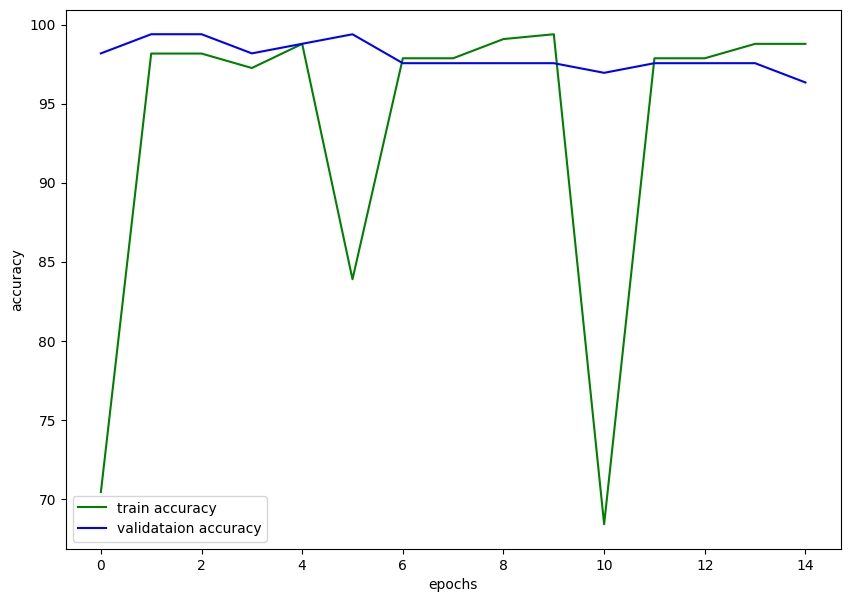

elephant
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0165 Acc: 90.2439%
[Test #1] Loss: 0.0063 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 98.7805%
[Test #2] Loss: 0.0033 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 99.0854%
[Test #3] Loss: 0.0023 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.4756%
[Test #4] Loss: 0.0021 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.1707%
[Test #5] Loss: 0.0023 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0118 Acc: 95.7447%
[Test #1] Loss: 0.0034 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0036 Acc: 99.0881%
[Test #2] Loss: 0.0027 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 98.1763%
[Test #3] Loss: 0.0026 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 97.8723%
[Test #4] Loss: 0.0024 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.7842%
[Test #5] Loss: 0.0026 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0227 Acc: 74.7720%
[Test 

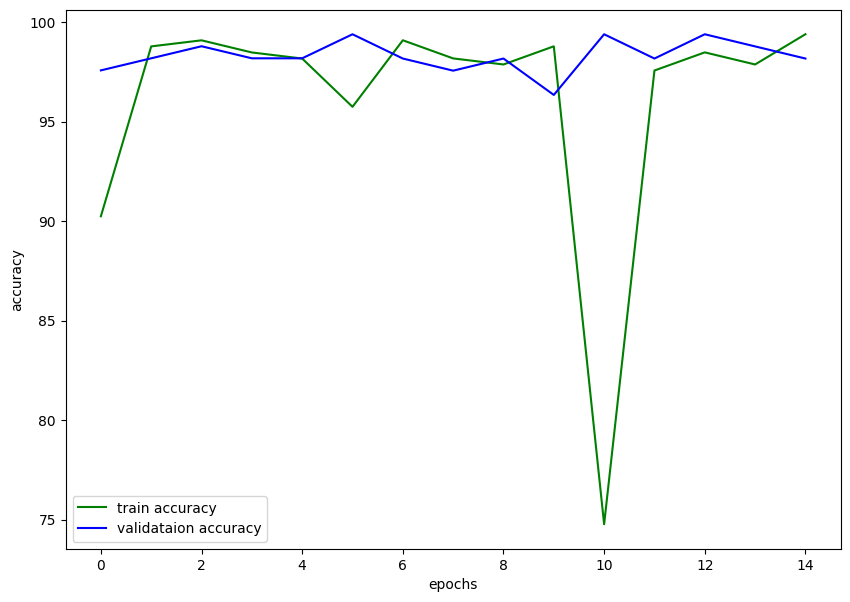

flamingo
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0196 Acc: 82.0122%
[Test #1] Loss: 0.0059 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0050 Acc: 98.7805%
[Test #2] Loss: 0.0038 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0024 Acc: 99.0854%
[Test #3] Loss: 0.0017 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0014 Acc: 99.6951%
[Test #4] Loss: 0.0015 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0010 Acc: 99.3902%
[Test #5] Loss: 0.0015 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0214 Acc: 76.2918%
[Test #1] Loss: 0.0074 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0058 Acc: 98.4802%
[Test #2] Loss: 0.0034 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 99.3921%
[Test #3] Loss: 0.0012 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.0881%
[Test #4] Loss: 0.0021 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 98.7842%
[Test #5] Loss: 0.0034 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 86.9301%
[Tes

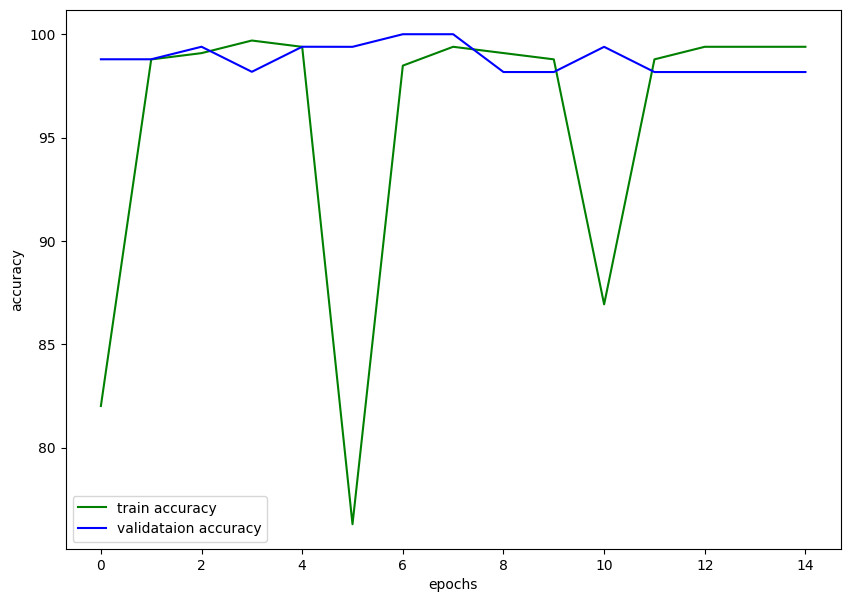

fly
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0164 Acc: 90.8537%
[Test #1] Loss: 0.0065 Acc: 96.3636% 
Epoch 1 running
[Train #2] Loss: 0.0051 Acc: 98.7805%
[Test #2] Loss: 0.0038 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 99.0854%
[Test #3] Loss: 0.0039 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.7805%
[Test #4] Loss: 0.0021 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0013 Acc: 99.3902%
[Test #5] Loss: 0.0028 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0300 Acc: 51.3678%
[Test #1] Loss: 0.0100 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0101 Acc: 95.7447%
[Test #2] Loss: 0.0051 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 98.4802%
[Test #3] Loss: 0.0037 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 99.3921%
[Test #4] Loss: 0.0036 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 98.7842%
[Test #5] Loss: 0.0029 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0143 Acc: 93.0091%
[Test 

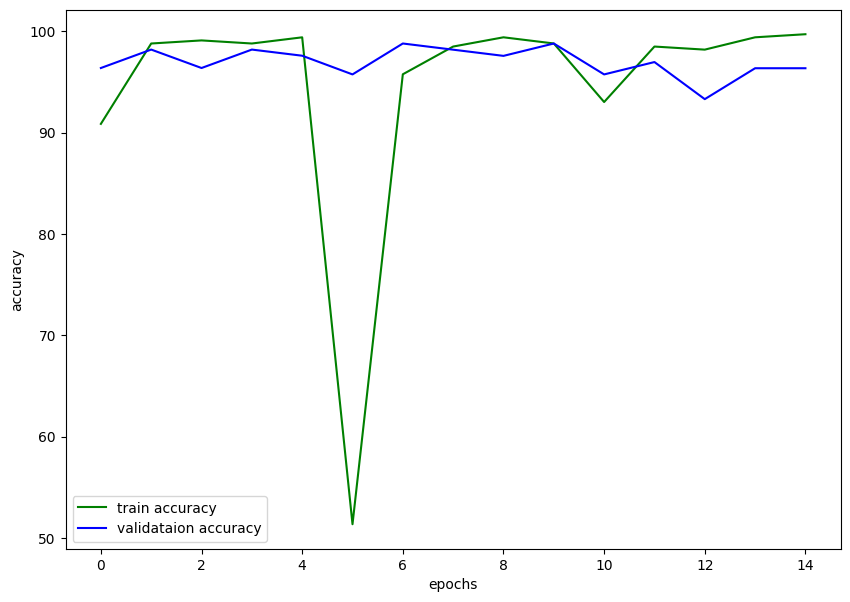

fox
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0251 Acc: 64.9390%
[Test #1] Loss: 0.0085 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0074 Acc: 97.5610%
[Test #2] Loss: 0.0046 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0035 Acc: 98.4756%
[Test #3] Loss: 0.0040 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0029 Acc: 98.1707%
[Test #4] Loss: 0.0024 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 98.4756%
[Test #5] Loss: 0.0019 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0174 Acc: 90.5775%
[Test #1] Loss: 0.0064 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 96.9605%
[Test #2] Loss: 0.0039 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 97.5684%
[Test #3] Loss: 0.0041 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.4802%
[Test #4] Loss: 0.0026 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 99.0881%
[Test #5] Loss: 0.0018 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0177 Acc: 87.8419%
[Test 

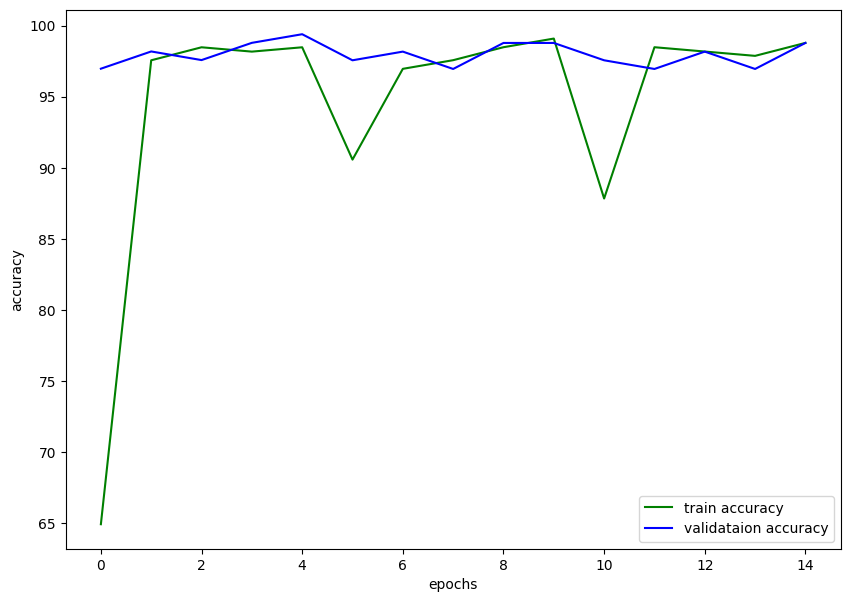

goat
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 83.5366%
[Test #1] Loss: 0.0092 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0069 Acc: 97.5610%
[Test #2] Loss: 0.0063 Acc: 94.5455% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 98.4756%
[Test #3] Loss: 0.0046 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 97.8659%
[Test #4] Loss: 0.0038 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0012 Acc: 99.6951%
[Test #5] Loss: 0.0035 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0216 Acc: 79.6353%
[Test #1] Loss: 0.0113 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0082 Acc: 96.0486%
[Test #2] Loss: 0.0064 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 98.4802%
[Test #3] Loss: 0.0050 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0035 Acc: 96.0486%
[Test #4] Loss: 0.0078 Acc: 94.5122% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.4802%
[Test #5] Loss: 0.0102 Acc: 93.9024% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0151 Acc: 92.7052%
[Test 

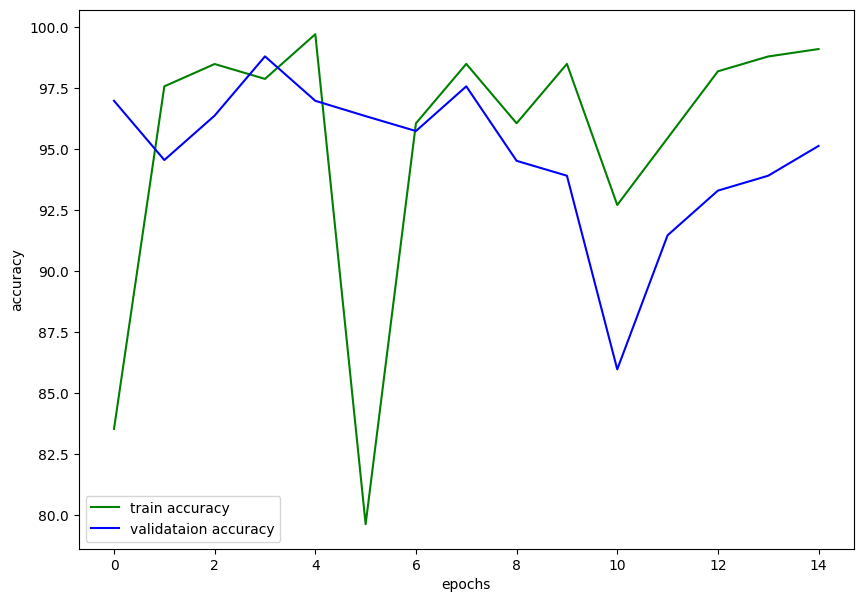

goldfish
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 94.2073%
[Test #1] Loss: 0.0043 Acc: 99.3939% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 97.8659%
[Test #2] Loss: 0.0022 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0018 Acc: 99.3902%
[Test #3] Loss: 0.0012 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 98.1707%
[Test #4] Loss: 0.0004 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.3902%
[Test #5] Loss: 0.0006 Acc: 100.0000% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0196 Acc: 78.7234%
[Test #1] Loss: 0.0062 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0051 Acc: 99.0881%
[Test #2] Loss: 0.0033 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.7842%
[Test #3] Loss: 0.0013 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 99.0881%
[Test #4] Loss: 0.0014 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.3921%
[Test #5] Loss: 0.0009 Acc: 100.0000% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0141 Acc: 95.4407%
[

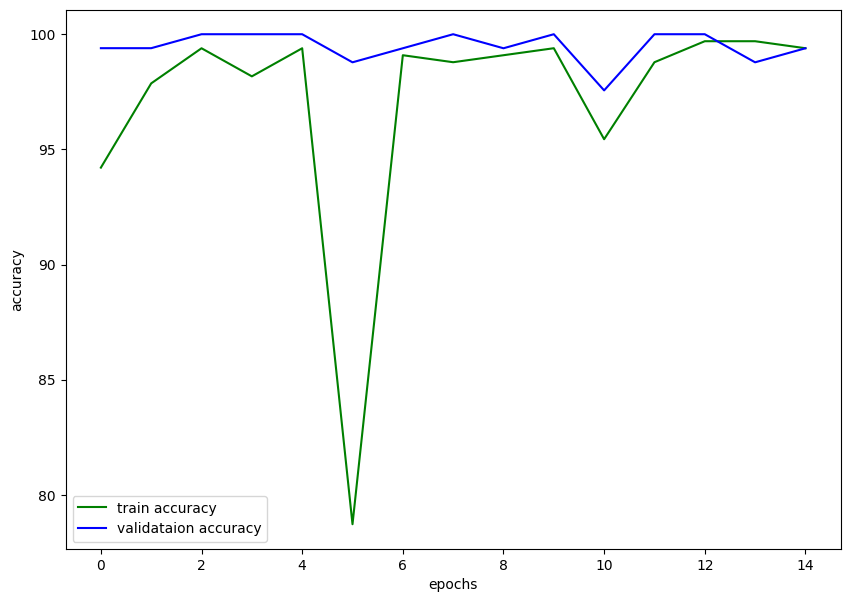

goose
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0216 Acc: 78.6585%
[Test #1] Loss: 0.0100 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0069 Acc: 98.4756%
[Test #2] Loss: 0.0062 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0040 Acc: 97.2561%
[Test #3] Loss: 0.0045 Acc: 95.7576% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 98.7805%
[Test #4] Loss: 0.0043 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0028 Acc: 98.7805%
[Test #5] Loss: 0.0042 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0135 Acc: 94.8328%
[Test #1] Loss: 0.0073 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0051 Acc: 97.2644%
[Test #2] Loss: 0.0064 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.1763%
[Test #3] Loss: 0.0054 Acc: 95.1220% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.7842%
[Test #4] Loss: 0.0051 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 98.4802%
[Test #5] Loss: 0.0044 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0147 Acc: 89.3617%
[Test 

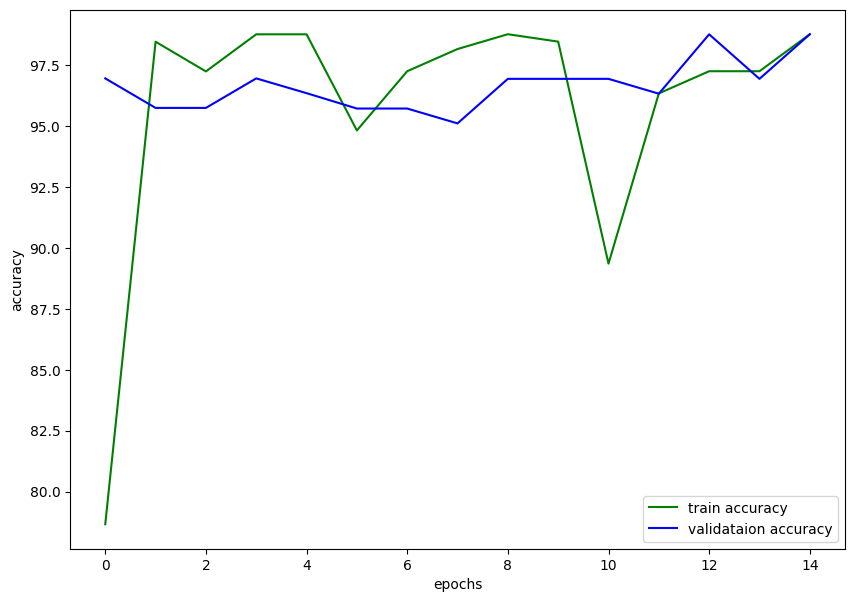

gorilla
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0225 Acc: 69.8171%
[Test #1] Loss: 0.0122 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 98.4756%
[Test #2] Loss: 0.0113 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.1707%
[Test #3] Loss: 0.0030 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0038 Acc: 98.1707%
[Test #4] Loss: 0.0036 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0023 Acc: 98.1707%
[Test #5] Loss: 0.0059 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0190 Acc: 82.9787%
[Test #1] Loss: 0.0051 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 99.0881%
[Test #2] Loss: 0.0035 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 97.5684%
[Test #3] Loss: 0.0018 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.4802%
[Test #4] Loss: 0.0016 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 98.4802%
[Test #5] Loss: 0.0015 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0181 Acc: 89.6657%
[Tes

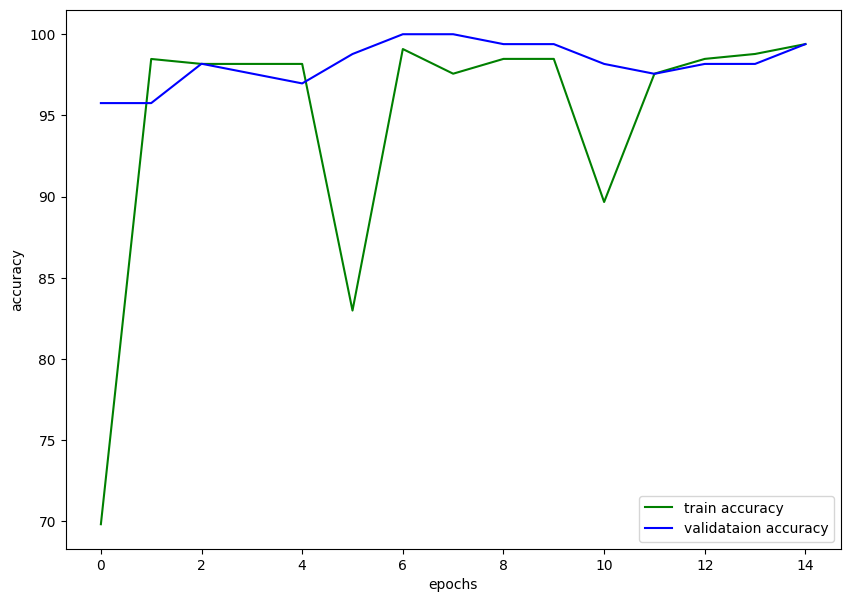

grasshopper
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0225 Acc: 68.9024%
[Test #1] Loss: 0.0089 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0060 Acc: 97.8659%
[Test #2] Loss: 0.0044 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 98.7805%
[Test #3] Loss: 0.0016 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0028 Acc: 98.1707%
[Test #4] Loss: 0.0010 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.4756%
[Test #5] Loss: 0.0018 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0113 Acc: 96.0486%
[Test #1] Loss: 0.0046 Acc: 98.1707% 
Epoch 1 running
[Train #2] Loss: 0.0035 Acc: 99.3921%
[Test #2] Loss: 0.0031 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 98.4802%
[Test #3] Loss: 0.0024 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0013 Acc: 99.6960%
[Test #4] Loss: 0.0046 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.6960%
[Test #5] Loss: 0.0012 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 93.9210%
[Tes

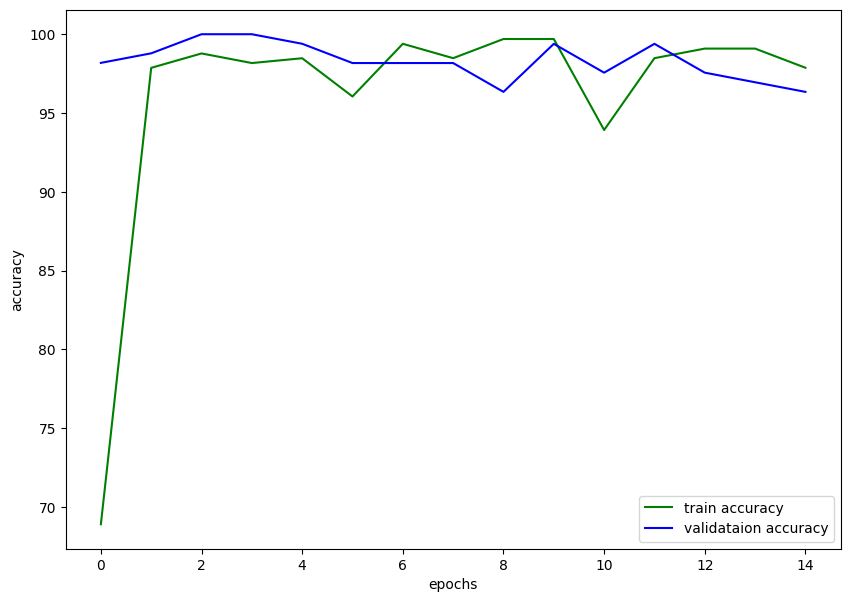

hamster
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0161 Acc: 90.8537%
[Test #1] Loss: 0.0061 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0057 Acc: 96.3415%
[Test #2] Loss: 0.0034 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 97.5610%
[Test #3] Loss: 0.0034 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0032 Acc: 97.2561%
[Test #4] Loss: 0.0025 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 99.3902%
[Test #5] Loss: 0.0023 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0262 Acc: 64.4377%
[Test #1] Loss: 0.0120 Acc: 95.1220% 
Epoch 1 running
[Train #2] Loss: 0.0074 Acc: 97.2644%
[Test #2] Loss: 0.0070 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0050 Acc: 97.2644%
[Test #3] Loss: 0.0047 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.4802%
[Test #4] Loss: 0.0047 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 99.6960%
[Test #5] Loss: 0.0034 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0141 Acc: 94.2249%
[Test 

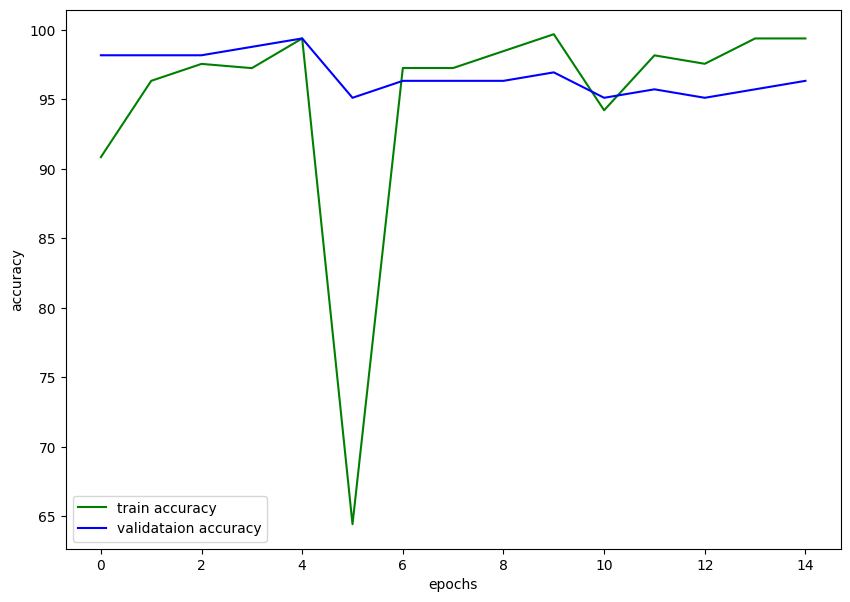

hare
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0143 Acc: 93.5976%
[Test #1] Loss: 0.0082 Acc: 93.9394% 
Epoch 1 running
[Train #2] Loss: 0.0060 Acc: 97.2561%
[Test #2] Loss: 0.0065 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0035 Acc: 97.8659%
[Test #3] Loss: 0.0067 Acc: 92.7273% 
Epoch 3 running
[Train #4] Loss: 0.0029 Acc: 97.2561%
[Test #4] Loss: 0.0055 Acc: 94.5455% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.0854%
[Test #5] Loss: 0.0091 Acc: 93.3333% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0306 Acc: 51.3678%
[Test #1] Loss: 0.0127 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0088 Acc: 97.5684%
[Test #2] Loss: 0.0074 Acc: 95.1220% 
Epoch 2 running
[Train #3] Loss: 0.0037 Acc: 98.4802%
[Test #3] Loss: 0.0036 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0029 Acc: 97.5684%
[Test #4] Loss: 0.0037 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.7842%
[Test #5] Loss: 0.0031 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0166 Acc: 91.1854%
[Test 

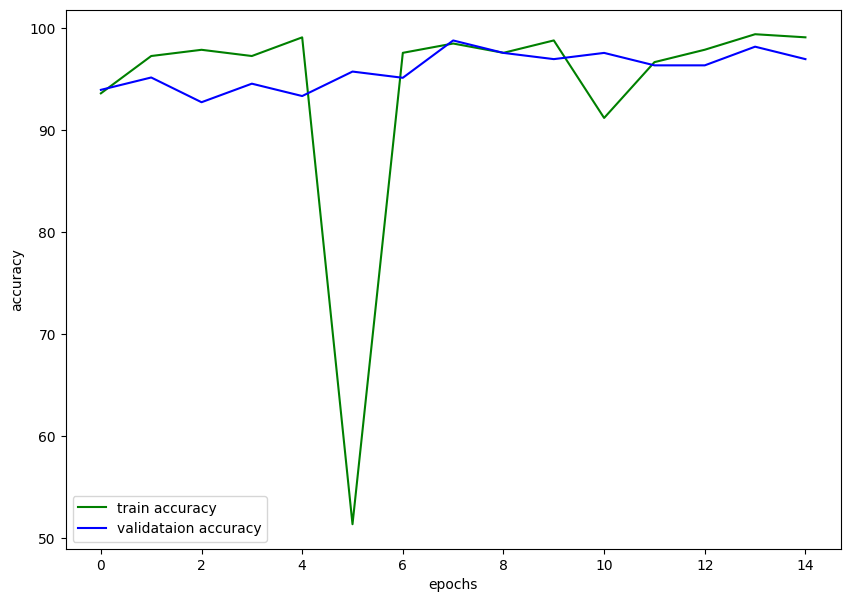

hedgehog
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0122 Acc: 94.5122%
[Test #1] Loss: 0.0051 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 96.3415%
[Test #2] Loss: 0.0039 Acc: 96.9697% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.7805%
[Test #3] Loss: 0.0023 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 98.7805%
[Test #4] Loss: 0.0021 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 98.7805%
[Test #5] Loss: 0.0016 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0161 Acc: 88.7538%
[Test #1] Loss: 0.0083 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 97.8723%
[Test #2] Loss: 0.0035 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.4802%
[Test #3] Loss: 0.0019 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 99.0881%
[Test #4] Loss: 0.0011 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0028 Acc: 97.8723%
[Test #5] Loss: 0.0021 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0190 Acc: 84.1945%
[Test

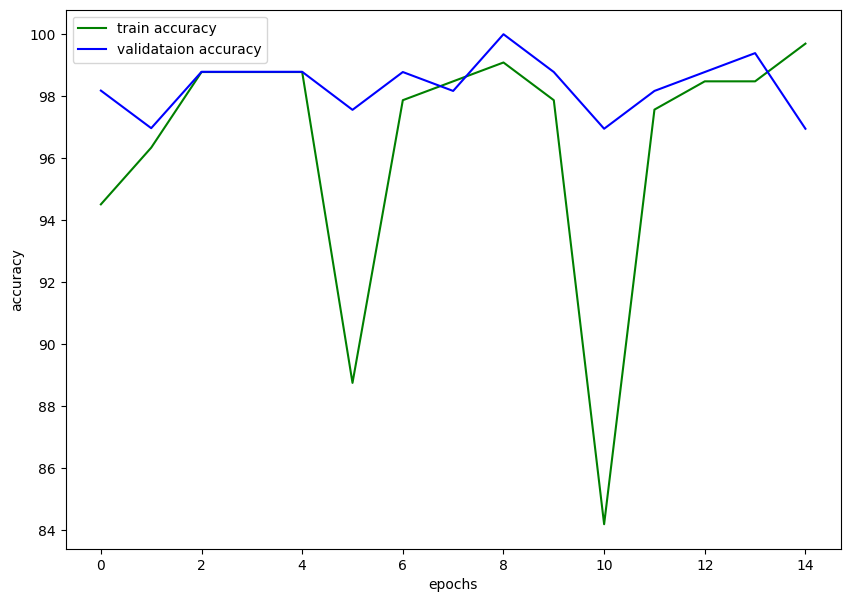

hippopotamus
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0148 Acc: 92.0732%
[Test #1] Loss: 0.0068 Acc: 94.5455% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 96.3415%
[Test #2] Loss: 0.0047 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 99.0854%
[Test #3] Loss: 0.0059 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0028 Acc: 97.8659%
[Test #4] Loss: 0.0029 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0009 Acc: 100.0000%
[Test #5] Loss: 0.0038 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0135 Acc: 96.6565%
[Test #1] Loss: 0.0065 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 97.2644%
[Test #2] Loss: 0.0043 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0020 Acc: 99.0881%
[Test #3] Loss: 0.0035 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 98.4802%
[Test #4] Loss: 0.0030 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0008 Acc: 99.6960%
[Test #5] Loss: 0.0037 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0153 Acc: 92.7052%
[Test

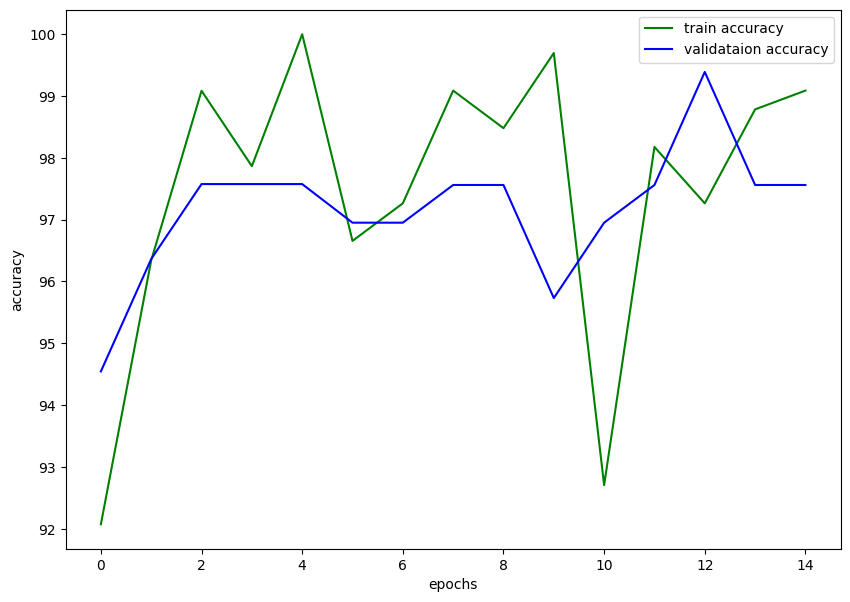

hornbill
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0197 Acc: 83.2317%
[Test #1] Loss: 0.0072 Acc: 96.3636% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 97.8659%
[Test #2] Loss: 0.0034 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 99.0854%
[Test #3] Loss: 0.0037 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.1707%
[Test #4] Loss: 0.0040 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.3902%
[Test #5] Loss: 0.0029 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 89.0578%
[Test #1] Loss: 0.0068 Acc: 98.1707% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 97.8723%
[Test #2] Loss: 0.0041 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.7842%
[Test #3] Loss: 0.0025 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.7842%
[Test #4] Loss: 0.0022 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0027 Acc: 98.4802%
[Test #5] Loss: 0.0016 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 86.0182%
[Test 

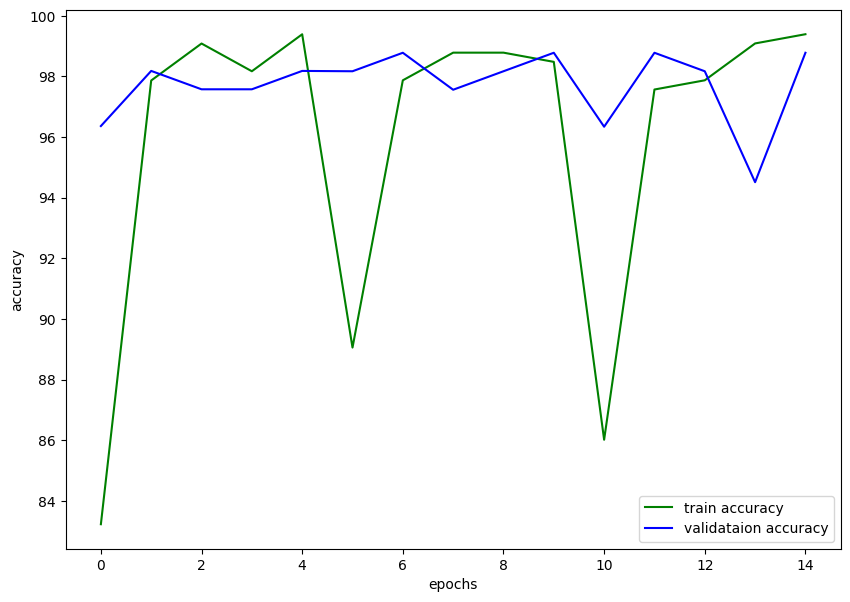

horse
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0266 Acc: 59.7561%
[Test #1] Loss: 0.0118 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0083 Acc: 96.3415%
[Test #2] Loss: 0.0056 Acc: 96.9697% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 97.8659%
[Test #3] Loss: 0.0042 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 98.7805%
[Test #4] Loss: 0.0049 Acc: 95.7576% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.1707%
[Test #5] Loss: 0.0025 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0198 Acc: 84.8024%
[Test #1] Loss: 0.0087 Acc: 93.2927% 
Epoch 1 running
[Train #2] Loss: 0.0072 Acc: 96.9605%
[Test #2] Loss: 0.0057 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0045 Acc: 97.5684%
[Test #3] Loss: 0.0028 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.7842%
[Test #4] Loss: 0.0038 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.0881%
[Test #5] Loss: 0.0037 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0139 Acc: 93.0091%
[Test 

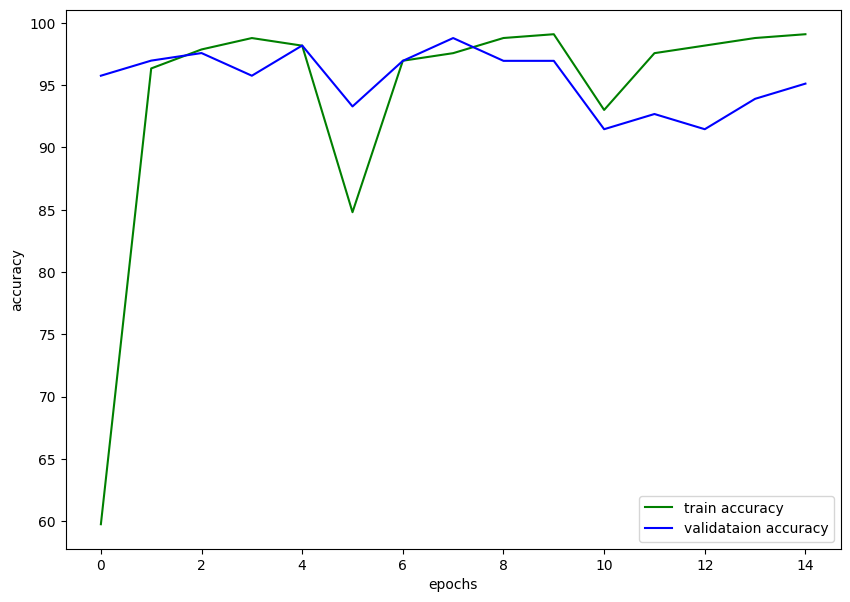

hummingbird
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0144 Acc: 92.3780%
[Test #1] Loss: 0.0050 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0050 Acc: 98.1707%
[Test #2] Loss: 0.0046 Acc: 96.9697% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.4756%
[Test #3] Loss: 0.0022 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0014 Acc: 99.6951%
[Test #4] Loss: 0.0035 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.3902%
[Test #5] Loss: 0.0011 Acc: 100.0000% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0235 Acc: 69.6049%
[Test #1] Loss: 0.0098 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0079 Acc: 96.3526%
[Test #2] Loss: 0.0034 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.7842%
[Test #3] Loss: 0.0030 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0036 Acc: 97.5684%
[Test #4] Loss: 0.0015 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.7842%
[Test #5] Loss: 0.0013 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0183 Acc: 84.4985%
[Test

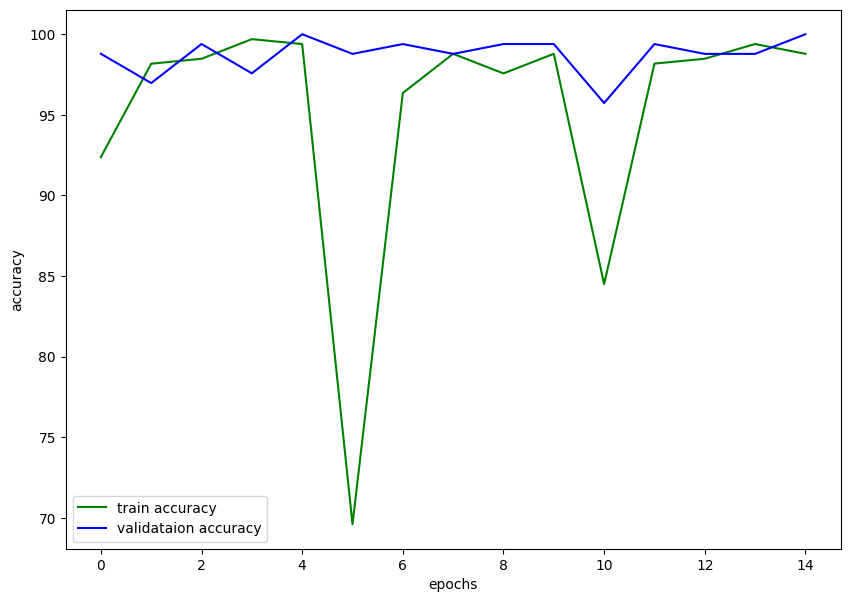

hyena
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0152 Acc: 93.5976%
[Test #1] Loss: 0.0053 Acc: 99.3939% 
Epoch 1 running
[Train #2] Loss: 0.0046 Acc: 98.4756%
[Test #2] Loss: 0.0028 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 99.0854%
[Test #3] Loss: 0.0013 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.1707%
[Test #4] Loss: 0.0014 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0013 Acc: 99.3902%
[Test #5] Loss: 0.0023 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 87.5380%
[Test #1] Loss: 0.0068 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0057 Acc: 98.4802%
[Test #2] Loss: 0.0047 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 98.4802%
[Test #3] Loss: 0.0029 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0015 Acc: 99.3921%
[Test #4] Loss: 0.0019 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0013 Acc: 99.6960%
[Test #5] Loss: 0.0009 Acc: 100.0000% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0188 Acc: 80.2432%
[Te

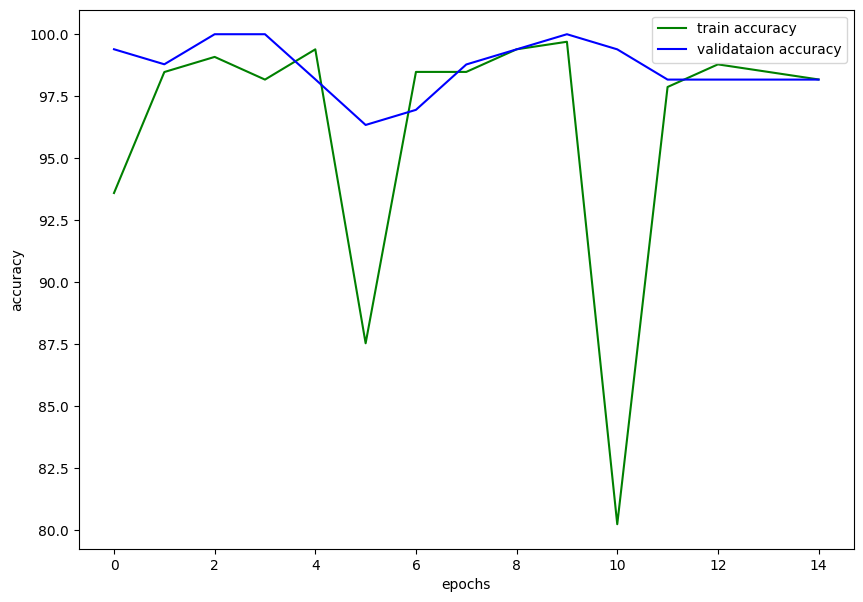

jellyfish
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0216 Acc: 74.0854%
[Test #1] Loss: 0.0070 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0044 Acc: 99.6951%
[Test #2] Loss: 0.0051 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.1707%
[Test #3] Loss: 0.0023 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0030 Acc: 96.9512%
[Test #4] Loss: 0.0019 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0024 Acc: 98.4756%
[Test #5] Loss: 0.0021 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0216 Acc: 73.2523%
[Test #1] Loss: 0.0087 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0069 Acc: 96.9605%
[Test #2] Loss: 0.0039 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 98.7842%
[Test #3] Loss: 0.0029 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 99.0881%
[Test #4] Loss: 0.0031 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0008 Acc: 100.0000%
[Test #5] Loss: 0.0013 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0195 Acc: 79.9392%
[Test

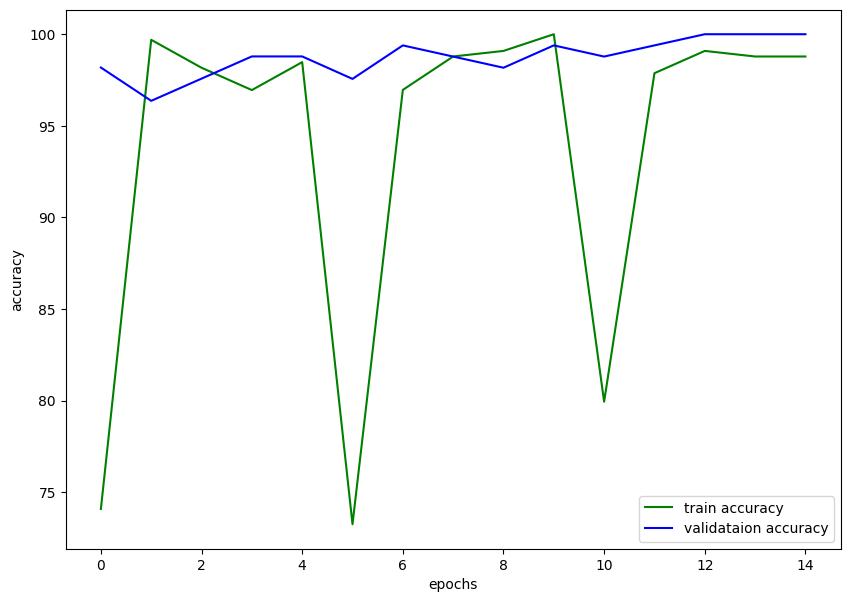

kangaroo
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0252 Acc: 64.6341%
[Test #1] Loss: 0.0115 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0074 Acc: 96.9512%
[Test #2] Loss: 0.0051 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0037 Acc: 97.2561%
[Test #3] Loss: 0.0033 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.7805%
[Test #4] Loss: 0.0026 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 97.5610%
[Test #5] Loss: 0.0014 Acc: 100.0000% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0227 Acc: 75.3799%
[Test #1] Loss: 0.0105 Acc: 94.5122% 
Epoch 1 running
[Train #2] Loss: 0.0075 Acc: 98.1763%
[Test #2] Loss: 0.0054 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 97.2644%
[Test #3] Loss: 0.0049 Acc: 95.7317% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.3921%
[Test #4] Loss: 0.0057 Acc: 93.9024% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.7842%
[Test #5] Loss: 0.0043 Acc: 95.1220% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0166 Acc: 90.8815%
[Test

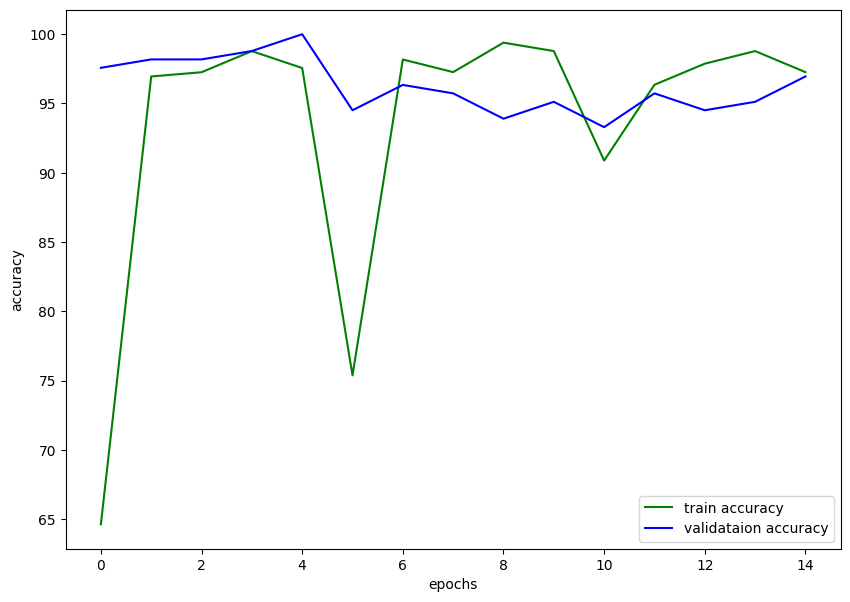

koala
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 87.8049%
[Test #1] Loss: 0.0069 Acc: 99.3939% 
Epoch 1 running
[Train #2] Loss: 0.0054 Acc: 98.4756%
[Test #2] Loss: 0.0032 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.1707%
[Test #3] Loss: 0.0039 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.4756%
[Test #4] Loss: 0.0034 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.6951%
[Test #5] Loss: 0.0039 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0238 Acc: 69.3009%
[Test #1] Loss: 0.0087 Acc: 98.1707% 
Epoch 1 running
[Train #2] Loss: 0.0059 Acc: 97.8723%
[Test #2] Loss: 0.0048 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0033 Acc: 99.0881%
[Test #3] Loss: 0.0027 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 97.8723%
[Test #4] Loss: 0.0017 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.1763%
[Test #5] Loss: 0.0027 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0141 Acc: 93.9210%
[Test 

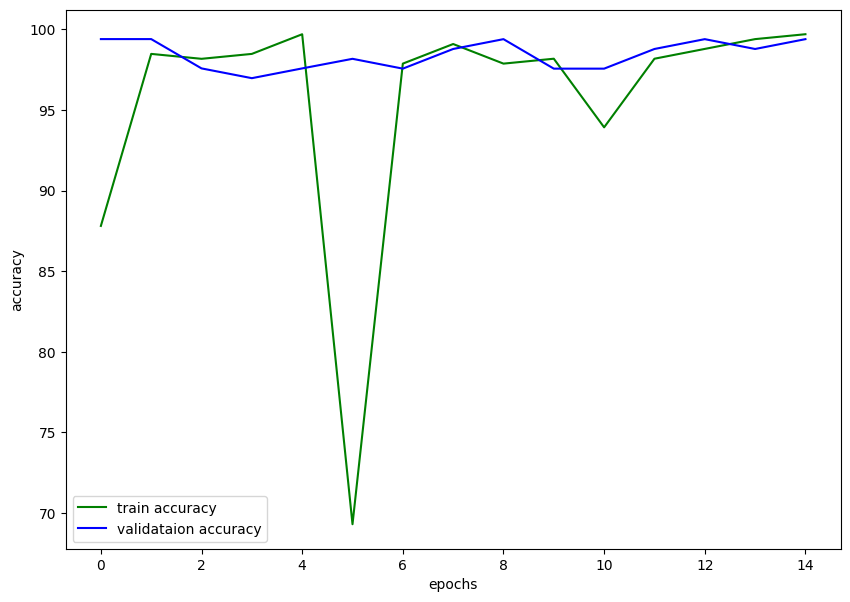

ladybugs
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0109 Acc: 95.4268%
[Test #1] Loss: 0.0044 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0034 Acc: 99.0854%
[Test #2] Loss: 0.0026 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0015 Acc: 99.3902%
[Test #3] Loss: 0.0023 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0008 Acc: 99.6951%
[Test #4] Loss: 0.0018 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0005 Acc: 100.0000%
[Test #5] Loss: 0.0017 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0191 Acc: 81.7629%
[Test #1] Loss: 0.0065 Acc: 100.0000% 
Epoch 1 running
[Train #2] Loss: 0.0046 Acc: 99.0881%
[Test #2] Loss: 0.0027 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0024 Acc: 98.4802%
[Test #3] Loss: 0.0024 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 98.7842%
[Test #4] Loss: 0.0008 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0012 Acc: 99.6960%
[Test #5] Loss: 0.0019 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0127 Acc: 94.8328%
[Te

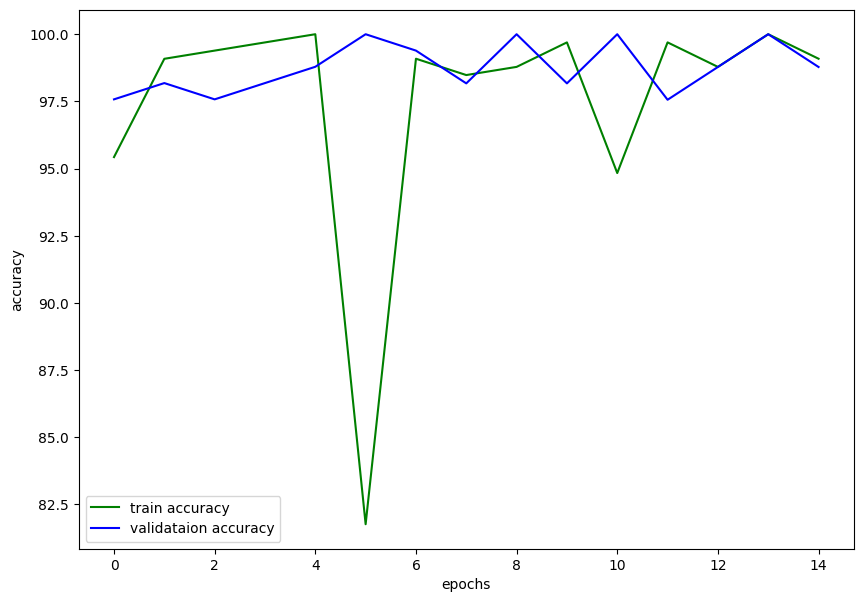

leopard
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0156 Acc: 92.3780%
[Test #1] Loss: 0.0048 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 98.7805%
[Test #2] Loss: 0.0024 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.4756%
[Test #3] Loss: 0.0021 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.4756%
[Test #4] Loss: 0.0017 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 99.0854%
[Test #5] Loss: 0.0020 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0163 Acc: 91.4894%
[Test #1] Loss: 0.0057 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0034 Acc: 99.3921%
[Test #2] Loss: 0.0019 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.4802%
[Test #3] Loss: 0.0012 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.1763%
[Test #4] Loss: 0.0008 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.7842%
[Test #5] Loss: 0.0009 Acc: 100.0000% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0202 Acc: 79.9392%
[T

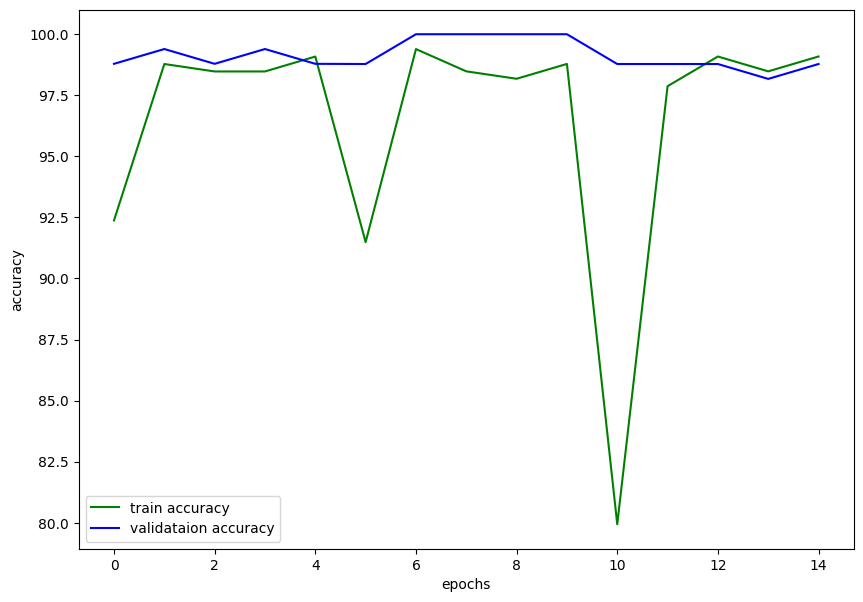

lion
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0129 Acc: 96.0366%
[Test #1] Loss: 0.0051 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0043 Acc: 97.8659%
[Test #2] Loss: 0.0028 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.1707%
[Test #3] Loss: 0.0018 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 99.0854%
[Test #4] Loss: 0.0028 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 98.7805%
[Test #5] Loss: 0.0040 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0125 Acc: 94.8328%
[Test #1] Loss: 0.0057 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0036 Acc: 99.3921%
[Test #2] Loss: 0.0043 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0018 Acc: 99.0881%
[Test #3] Loss: 0.0036 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 98.4802%
[Test #4] Loss: 0.0032 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0012 Acc: 99.6960%
[Test #5] Loss: 0.0047 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0152 Acc: 93.0091%
[Test 

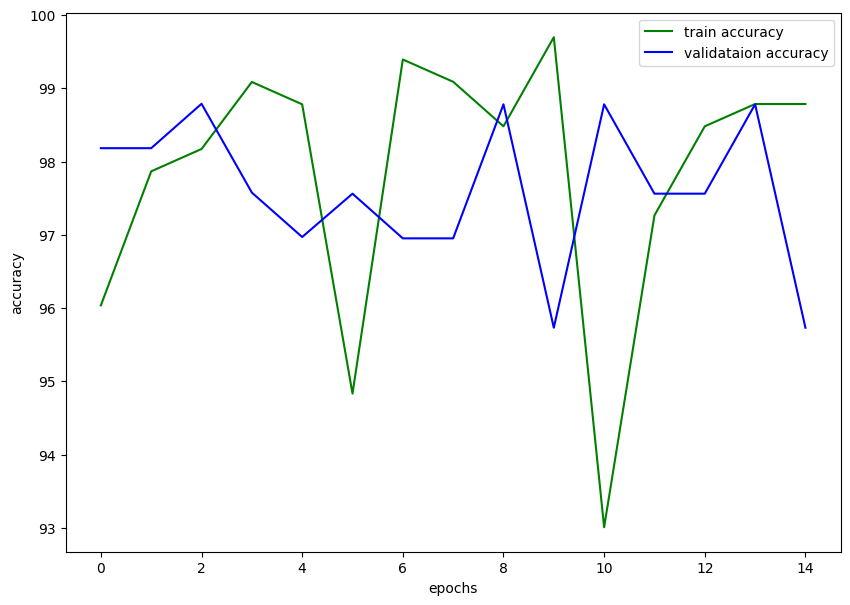

lizard
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0266 Acc: 61.2805%
[Test #1] Loss: 0.0095 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0084 Acc: 98.4756%
[Test #2] Loss: 0.0047 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0044 Acc: 97.8659%
[Test #3] Loss: 0.0033 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.6951%
[Test #4] Loss: 0.0062 Acc: 95.1515% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 98.7805%
[Test #5] Loss: 0.0030 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0245 Acc: 67.1733%
[Test #1] Loss: 0.0120 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0069 Acc: 96.9605%
[Test #2] Loss: 0.0093 Acc: 93.9024% 
Epoch 2 running
[Train #3] Loss: 0.0021 Acc: 99.6960%
[Test #3] Loss: 0.0085 Acc: 95.7317% 
Epoch 3 running
[Train #4] Loss: 0.0033 Acc: 96.9605%
[Test #4] Loss: 0.0075 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0040 Acc: 96.9605%
[Test #5] Loss: 0.0046 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 88.7538%
[Test 

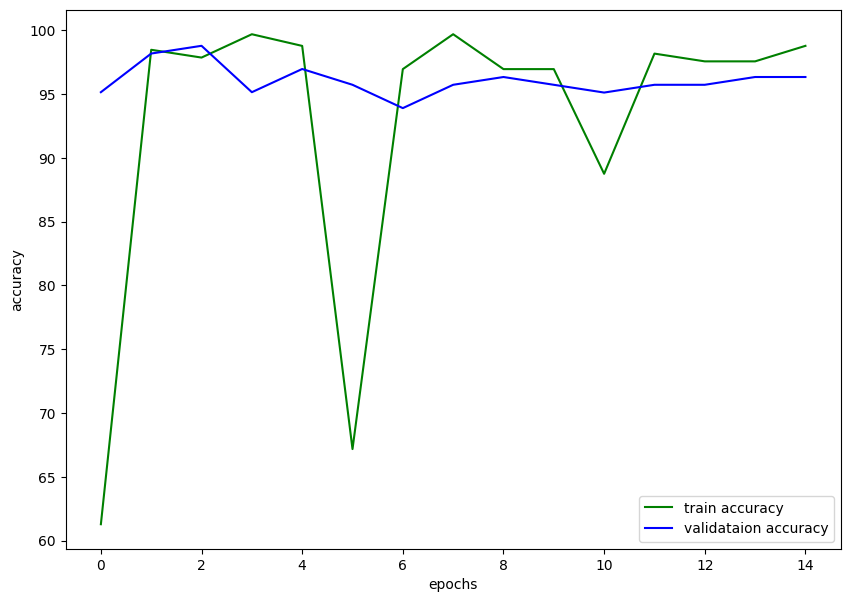

lobster
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0238 Acc: 68.9024%
[Test #1] Loss: 0.0096 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0072 Acc: 97.5610%
[Test #2] Loss: 0.0062 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 97.2561%
[Test #3] Loss: 0.0049 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.3902%
[Test #4] Loss: 0.0047 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.3902%
[Test #5] Loss: 0.0042 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0221 Acc: 73.8602%
[Test #1] Loss: 0.0106 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0067 Acc: 97.2644%
[Test #2] Loss: 0.0050 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0020 Acc: 100.0000%
[Test #3] Loss: 0.0023 Acc: 99.3902% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 98.4802%
[Test #4] Loss: 0.0019 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.4802%
[Test #5] Loss: 0.0014 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0137 Acc: 92.7052%
[Test

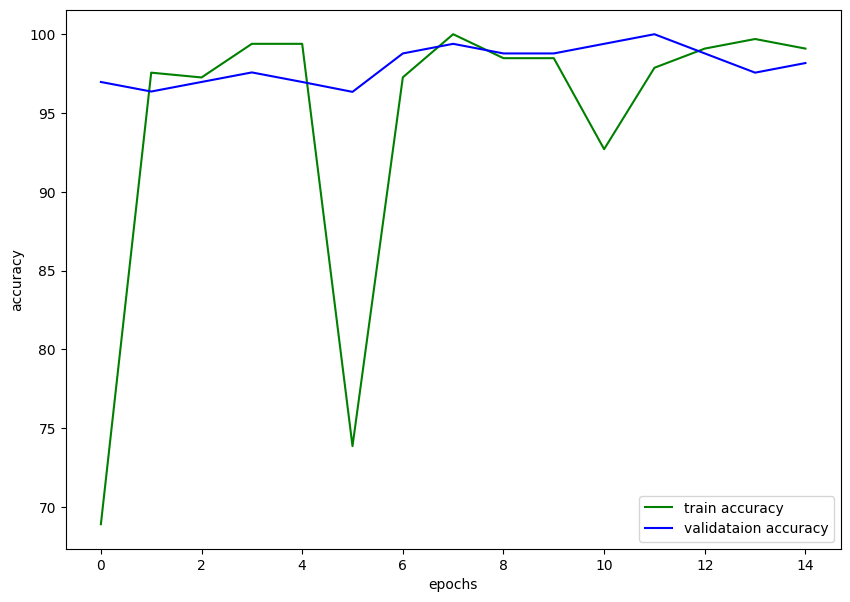

mosquito
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0141 Acc: 95.1220%
[Test #1] Loss: 0.0086 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 98.7805%
[Test #2] Loss: 0.0051 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0019 Acc: 99.3902%
[Test #3] Loss: 0.0040 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 98.4756%
[Test #4] Loss: 0.0015 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.6951%
[Test #5] Loss: 0.0043 Acc: 95.1515% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0261 Acc: 65.3495%
[Test #1] Loss: 0.0100 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0080 Acc: 96.6565%
[Test #2] Loss: 0.0054 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0023 Acc: 99.0881%
[Test #3] Loss: 0.0032 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0035 Acc: 98.4802%
[Test #4] Loss: 0.0018 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 99.0881%
[Test #5] Loss: 0.0026 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 83.2827%
[Test 

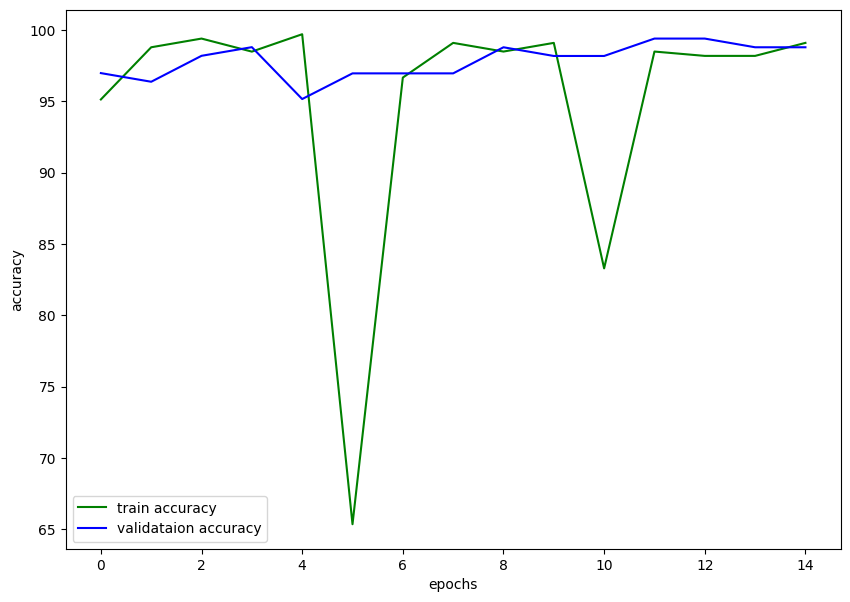

moth
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0223 Acc: 75.6098%
[Test #1] Loss: 0.0115 Acc: 94.5455% 
Epoch 1 running
[Train #2] Loss: 0.0071 Acc: 97.8659%
[Test #2] Loss: 0.0065 Acc: 94.5455% 
Epoch 2 running
[Train #3] Loss: 0.0046 Acc: 96.6463%
[Test #3] Loss: 0.0054 Acc: 95.7576% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 97.5610%
[Test #4] Loss: 0.0053 Acc: 95.1515% 
Epoch 4 running
[Train #5] Loss: 0.0024 Acc: 98.7805%
[Test #5] Loss: 0.0044 Acc: 95.7576% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0166 Acc: 90.5775%
[Test #1] Loss: 0.0081 Acc: 98.1707% 
Epoch 1 running
[Train #2] Loss: 0.0065 Acc: 96.3526%
[Test #2] Loss: 0.0053 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.4802%
[Test #3] Loss: 0.0032 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.4802%
[Test #4] Loss: 0.0034 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0029 Acc: 98.1763%
[Test #5] Loss: 0.0047 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0187 Acc: 86.0182%
[Test 

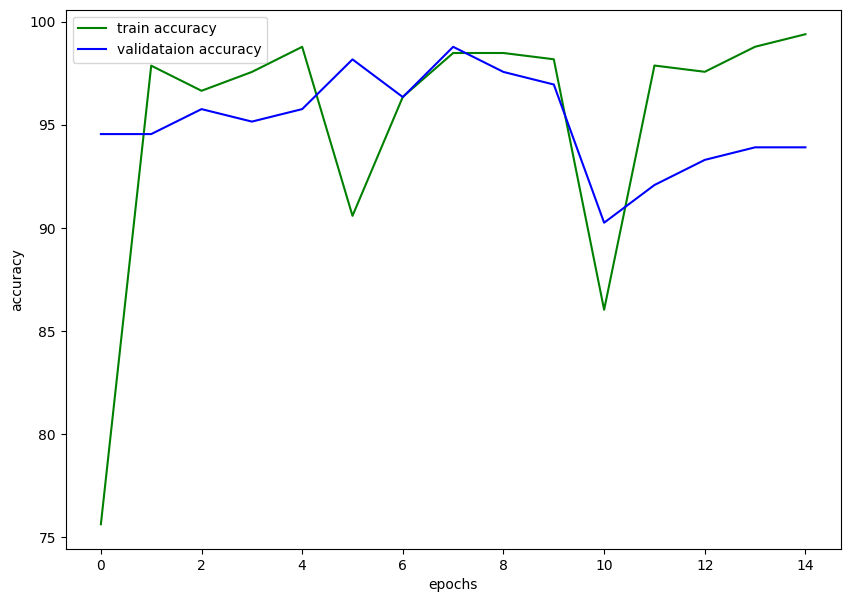

mouse
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0169 Acc: 89.0244%
[Test #1] Loss: 0.0110 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0067 Acc: 96.6463%
[Test #2] Loss: 0.0059 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 98.1707%
[Test #3] Loss: 0.0052 Acc: 95.7576% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 99.0854%
[Test #4] Loss: 0.0054 Acc: 95.1515% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.4756%
[Test #5] Loss: 0.0053 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0181 Acc: 87.5380%
[Test #1] Loss: 0.0081 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0068 Acc: 96.3526%
[Test #2] Loss: 0.0048 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0047 Acc: 97.2644%
[Test #3] Loss: 0.0034 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.1763%
[Test #4] Loss: 0.0042 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.7842%
[Test #5] Loss: 0.0037 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0228 Acc: 73.5562%
[Test 

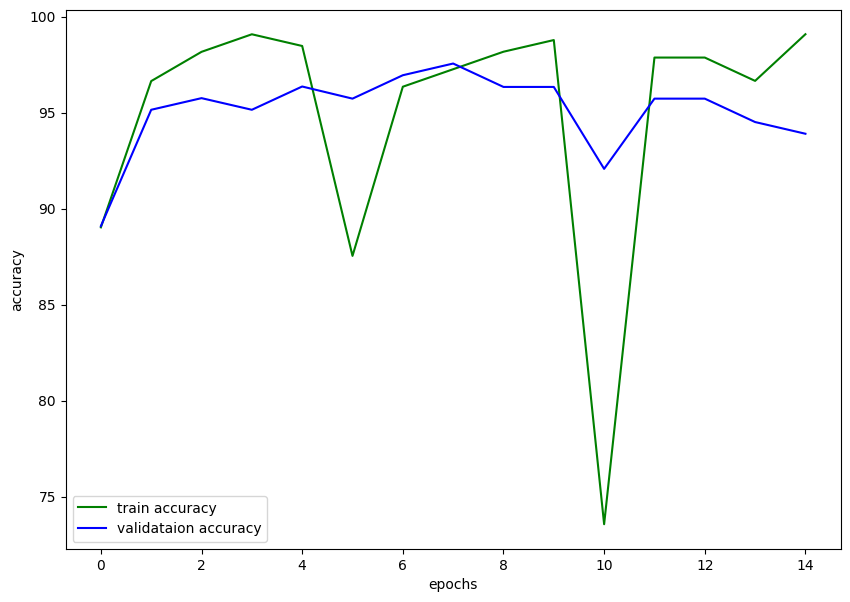

octopus
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0152 Acc: 91.1585%
[Test #1] Loss: 0.0066 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 98.1707%
[Test #2] Loss: 0.0042 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.7805%
[Test #3] Loss: 0.0029 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.3902%
[Test #4] Loss: 0.0030 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 98.7805%
[Test #5] Loss: 0.0032 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0203 Acc: 77.2036%
[Test #1] Loss: 0.0095 Acc: 94.5122% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 98.1763%
[Test #2] Loss: 0.0059 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 99.3921%
[Test #3] Loss: 0.0053 Acc: 95.7317% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 98.4802%
[Test #4] Loss: 0.0035 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.4802%
[Test #5] Loss: 0.0039 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0290 Acc: 55.6231%
[Test 

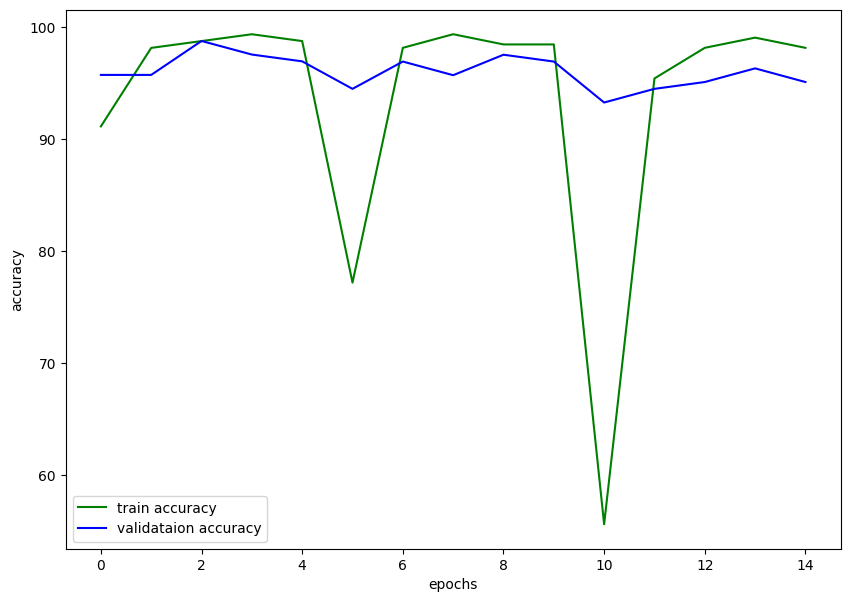

okapi
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0244 Acc: 67.3780%
[Test #1] Loss: 0.0106 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0073 Acc: 97.5610%
[Test #2] Loss: 0.0041 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 97.2561%
[Test #3] Loss: 0.0029 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 98.7805%
[Test #4] Loss: 0.0015 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 99.3902%
[Test #5] Loss: 0.0010 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0164 Acc: 91.4894%
[Test #1] Loss: 0.0075 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 98.4802%
[Test #2] Loss: 0.0038 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 99.0881%
[Test #3] Loss: 0.0025 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.0881%
[Test #4] Loss: 0.0021 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 99.3921%
[Test #5] Loss: 0.0024 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0270 Acc: 57.4468%
[Tes

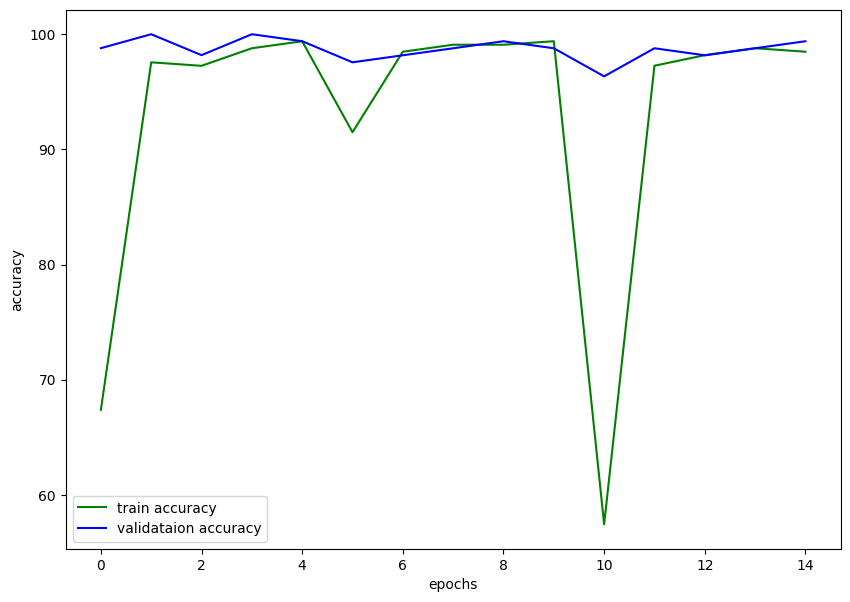

orangutan
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0210 Acc: 72.8659%
[Test #1] Loss: 0.0065 Acc: 100.0000% 
Epoch 1 running
[Train #2] Loss: 0.0050 Acc: 98.4756%
[Test #2] Loss: 0.0039 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 97.8659%
[Test #3] Loss: 0.0016 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 98.7805%
[Test #4] Loss: 0.0010 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0012 Acc: 98.7805%
[Test #5] Loss: 0.0020 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0188 Acc: 82.9787%
[Test #1] Loss: 0.0072 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 97.2644%
[Test #2] Loss: 0.0035 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 99.0881%
[Test #3] Loss: 0.0027 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0014 Acc: 99.3921%
[Test #4] Loss: 0.0034 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.1763%
[Test #5] Loss: 0.0023 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0172 Acc: 89.9696%
[Test

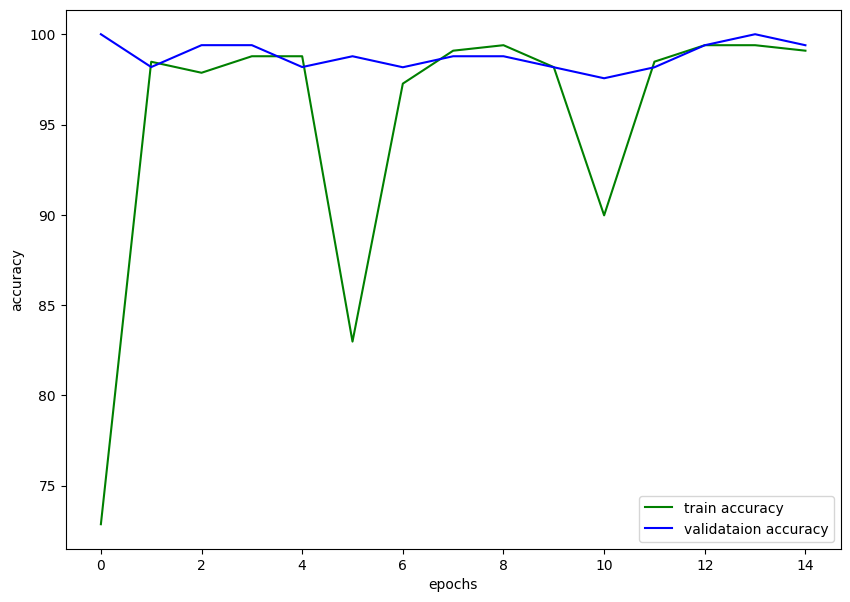

otter
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0123 Acc: 93.5976%
[Test #1] Loss: 0.0086 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0047 Acc: 97.5610%
[Test #2] Loss: 0.0058 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7805%
[Test #3] Loss: 0.0042 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 99.0854%
[Test #4] Loss: 0.0045 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.1707%
[Test #5] Loss: 0.0044 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0172 Acc: 90.8815%
[Test #1] Loss: 0.0085 Acc: 94.5122% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 97.8723%
[Test #2] Loss: 0.0051 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0035 Acc: 97.5684%
[Test #3] Loss: 0.0046 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.7842%
[Test #4] Loss: 0.0054 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0023 Acc: 98.1763%
[Test #5] Loss: 0.0046 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0202 Acc: 82.9787%
[Test 

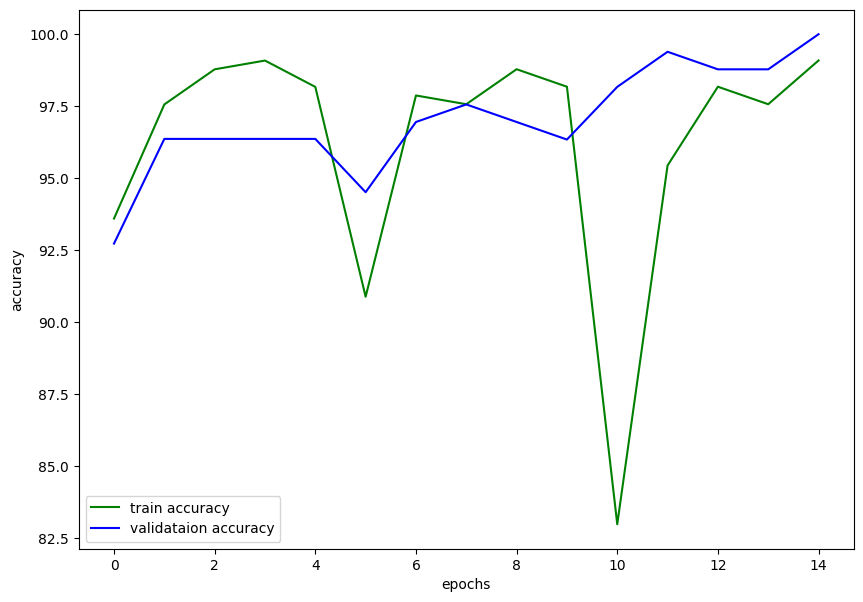

owl
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0263 Acc: 64.9390%
[Test #1] Loss: 0.0105 Acc: 96.3636% 
Epoch 1 running
[Train #2] Loss: 0.0088 Acc: 97.2561%
[Test #2] Loss: 0.0064 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0046 Acc: 97.5610%
[Test #3] Loss: 0.0043 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 100.0000%
[Test #4] Loss: 0.0033 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.4756%
[Test #5] Loss: 0.0038 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0218 Acc: 76.5957%
[Test #1] Loss: 0.0110 Acc: 92.6829% 
Epoch 1 running
[Train #2] Loss: 0.0069 Acc: 96.3526%
[Test #2] Loss: 0.0066 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 98.1763%
[Test #3] Loss: 0.0063 Acc: 95.1220% 
Epoch 3 running
[Train #4] Loss: 0.0031 Acc: 98.4802%
[Test #4] Loss: 0.0069 Acc: 94.5122% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.4802%
[Test #5] Loss: 0.0038 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 93.9210%
[Test

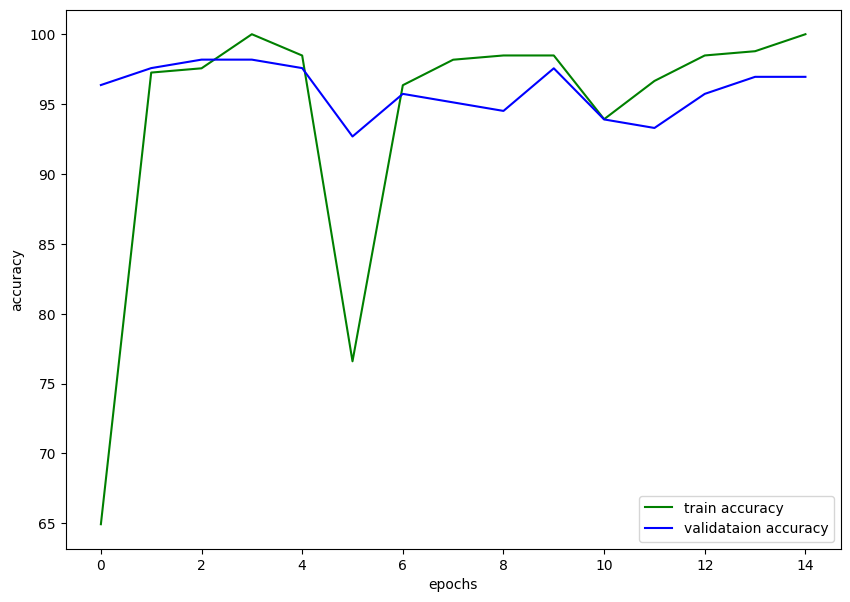

ox
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0194 Acc: 83.8415%
[Test #1] Loss: 0.0089 Acc: 93.9394% 
Epoch 1 running
[Train #2] Loss: 0.0080 Acc: 95.7317%
[Test #2] Loss: 0.0065 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 98.7805%
[Test #3] Loss: 0.0057 Acc: 95.1515% 
Epoch 3 running
[Train #4] Loss: 0.0046 Acc: 96.9512%
[Test #4] Loss: 0.0062 Acc: 93.9394% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 98.4756%
[Test #5] Loss: 0.0072 Acc: 93.9394% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0145 Acc: 92.0973%
[Test #1] Loss: 0.0101 Acc: 87.1951% 
Epoch 1 running
[Train #2] Loss: 0.0068 Acc: 96.3526%
[Test #2] Loss: 0.0085 Acc: 90.2439% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 98.4802%
[Test #3] Loss: 0.0064 Acc: 92.0732% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 98.7842%
[Test #4] Loss: 0.0066 Acc: 95.1220% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.3921%
[Test #5] Loss: 0.0092 Acc: 92.0732% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0170 Acc: 88.7538%
[Test 

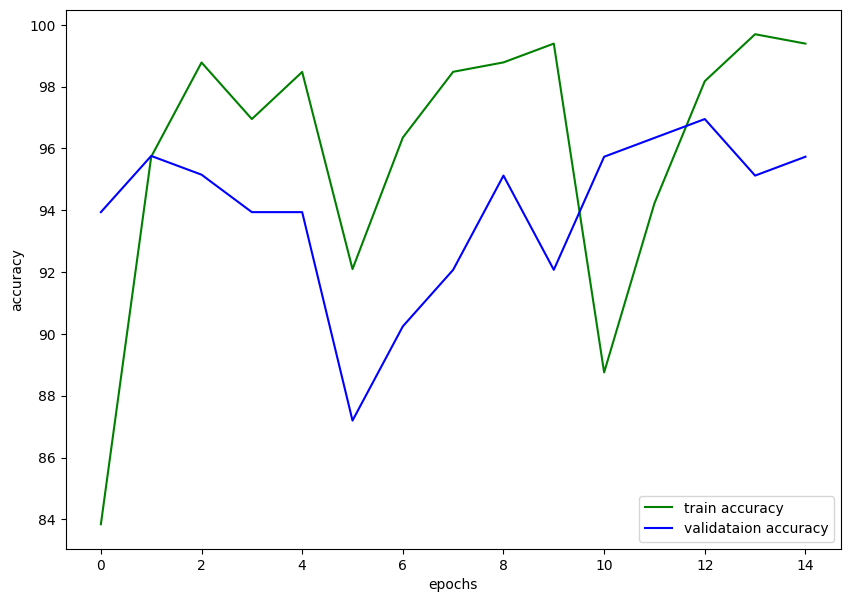

oyster
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0122 Acc: 95.7317%
[Test #1] Loss: 0.0052 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0040 Acc: 99.0854%
[Test #2] Loss: 0.0020 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0015 Acc: 100.0000%
[Test #3] Loss: 0.0013 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0008 Acc: 99.6951%
[Test #4] Loss: 0.0011 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0007 Acc: 99.3902%
[Test #5] Loss: 0.0008 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0154 Acc: 91.7933%
[Test #1] Loss: 0.0059 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0035 Acc: 99.3921%
[Test #2] Loss: 0.0028 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 97.5684%
[Test #3] Loss: 0.0028 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 99.0881%
[Test #4] Loss: 0.0022 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.3921%
[Test #5] Loss: 0.0017 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 87.8419%
[Te

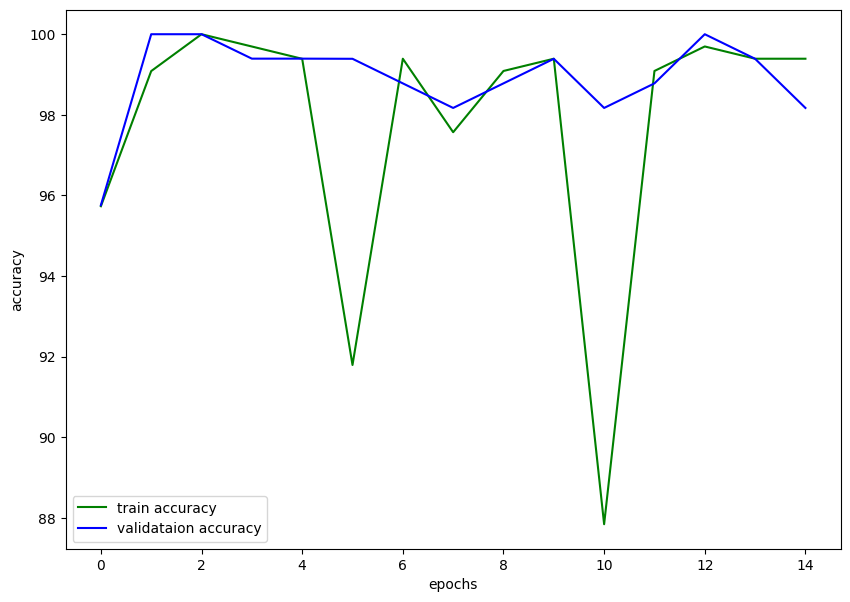

panda
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0253 Acc: 63.4146%
[Test #1] Loss: 0.0114 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0057 Acc: 98.1707%
[Test #2] Loss: 0.0041 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0038 Acc: 97.8659%
[Test #3] Loss: 0.0018 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0014 Acc: 99.6951%
[Test #4] Loss: 0.0015 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.7805%
[Test #5] Loss: 0.0019 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0180 Acc: 89.6657%
[Test #1] Loss: 0.0069 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0061 Acc: 97.5684%
[Test #2] Loss: 0.0028 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7842%
[Test #3] Loss: 0.0022 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.1763%
[Test #4] Loss: 0.0030 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.3921%
[Test #5] Loss: 0.0036 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0163 Acc: 91.1854%
[Test

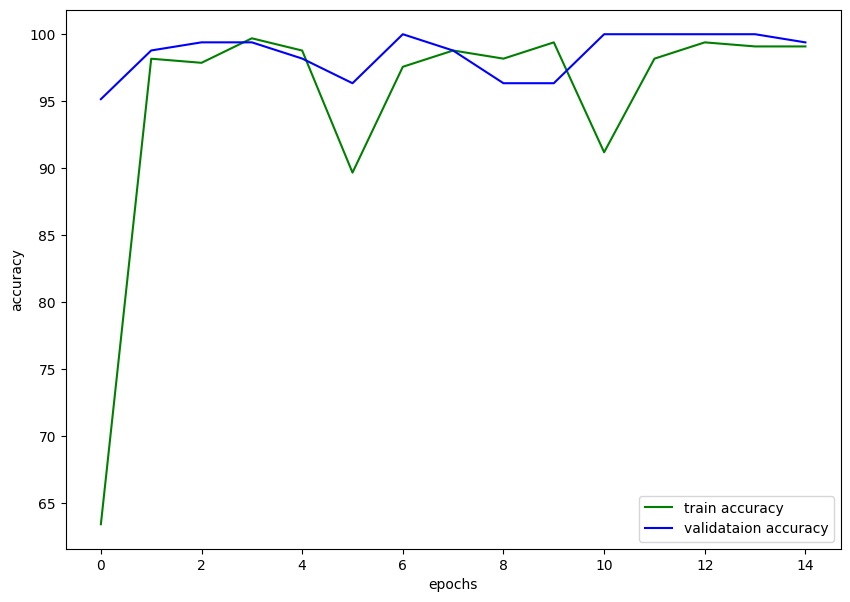

parrot
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0194 Acc: 82.3171%
[Test #1] Loss: 0.0087 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0058 Acc: 98.4756%
[Test #2] Loss: 0.0056 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 99.6951%
[Test #3] Loss: 0.0040 Acc: 95.7576% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 98.1707%
[Test #4] Loss: 0.0044 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.6951%
[Test #5] Loss: 0.0034 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0148 Acc: 91.1854%
[Test #1] Loss: 0.0073 Acc: 93.9024% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 97.8723%
[Test #2] Loss: 0.0035 Acc: 96.3415% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.7842%
[Test #3] Loss: 0.0032 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 98.7842%
[Test #4] Loss: 0.0027 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.1763%
[Test #5] Loss: 0.0031 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0198 Acc: 83.2827%
[Test 

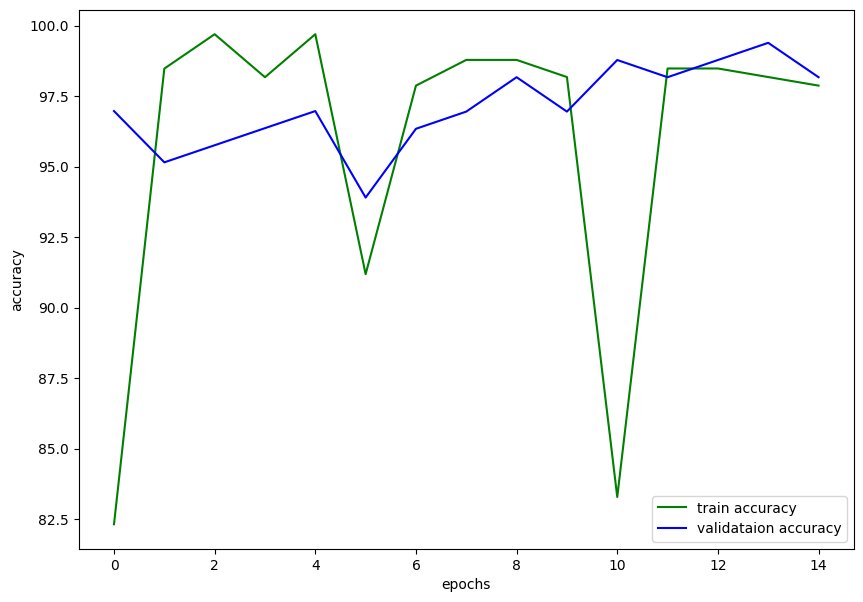

pelecaniformes
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0174 Acc: 87.8049%
[Test #1] Loss: 0.0067 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 96.6463%
[Test #2] Loss: 0.0034 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 97.5610%
[Test #3] Loss: 0.0032 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.0854%
[Test #4] Loss: 0.0022 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0032 Acc: 97.5610%
[Test #5] Loss: 0.0028 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0200 Acc: 85.1064%
[Test #1] Loss: 0.0087 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 98.7842%
[Test #2] Loss: 0.0057 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 98.4802%
[Test #3] Loss: 0.0039 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 99.0881%
[Test #4] Loss: 0.0058 Acc: 95.7317% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 98.7842%
[Test #5] Loss: 0.0041 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 89.0578%
[Test 

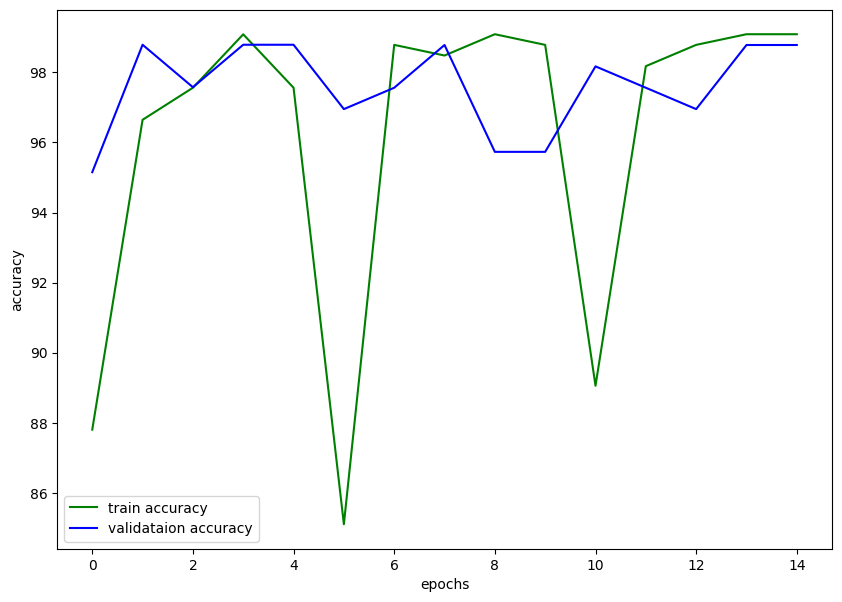

penguin
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0169 Acc: 89.0244%
[Test #1] Loss: 0.0078 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0041 Acc: 99.6951%
[Test #2] Loss: 0.0036 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.4756%
[Test #3] Loss: 0.0025 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.3902%
[Test #4] Loss: 0.0033 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0012 Acc: 99.6951%
[Test #5] Loss: 0.0014 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0266 Acc: 60.4863%
[Test #1] Loss: 0.0125 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0077 Acc: 97.2644%
[Test #2] Loss: 0.0045 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0033 Acc: 98.4802%
[Test #3] Loss: 0.0033 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 99.0881%
[Test #4] Loss: 0.0035 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 97.8723%
[Test #5] Loss: 0.0050 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0242 Acc: 68.0851%
[Test 

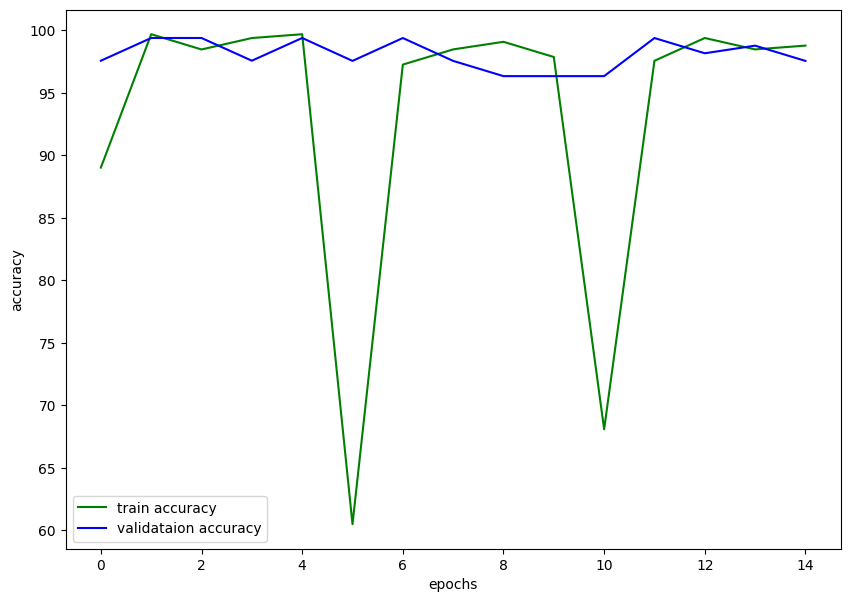

pig
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0259 Acc: 62.5000%
[Test #1] Loss: 0.0111 Acc: 94.5455% 
Epoch 1 running
[Train #2] Loss: 0.0078 Acc: 97.2561%
[Test #2] Loss: 0.0060 Acc: 96.9697% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 99.0854%
[Test #3] Loss: 0.0048 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0031 Acc: 97.8659%
[Test #4] Loss: 0.0057 Acc: 95.7576% 
Epoch 4 running
[Train #5] Loss: 0.0018 Acc: 99.0854%
[Test #5] Loss: 0.0060 Acc: 95.1515% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0250 Acc: 66.5653%
[Test #1] Loss: 0.0112 Acc: 94.5122% 
Epoch 1 running
[Train #2] Loss: 0.0084 Acc: 95.4407%
[Test #2] Loss: 0.0064 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 97.5684%
[Test #3] Loss: 0.0033 Acc: 99.3902% 
Epoch 3 running
[Train #4] Loss: 0.0033 Acc: 98.1763%
[Test #4] Loss: 0.0044 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 100.0000%
[Test #5] Loss: 0.0028 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0154 Acc: 92.7052%
[Test

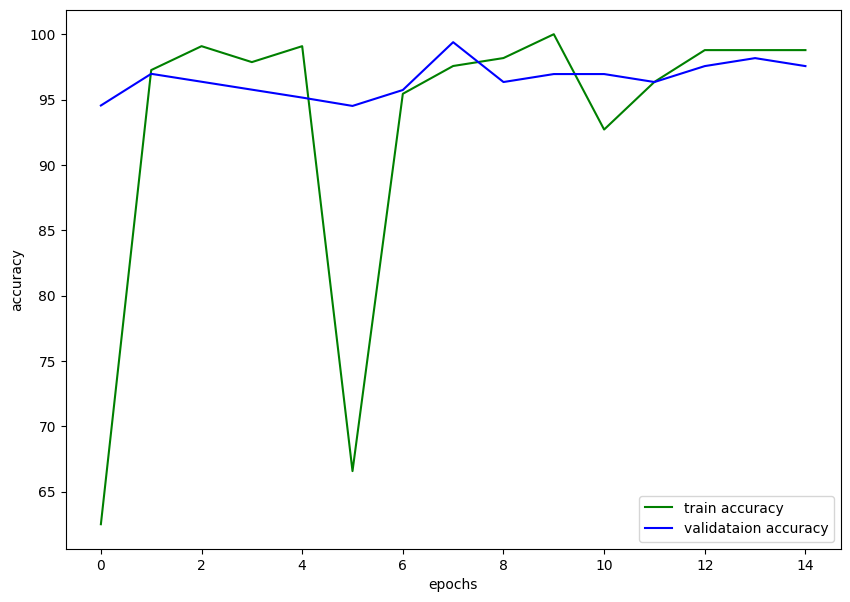

pigeon
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0217 Acc: 77.4390%
[Test #1] Loss: 0.0095 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0071 Acc: 96.3415%
[Test #2] Loss: 0.0055 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 99.0854%
[Test #3] Loss: 0.0043 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 98.7805%
[Test #4] Loss: 0.0034 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0027 Acc: 97.8659%
[Test #5] Loss: 0.0039 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0268 Acc: 58.9666%
[Test #1] Loss: 0.0126 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0080 Acc: 95.4407%
[Test #2] Loss: 0.0050 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0043 Acc: 96.9605%
[Test #3] Loss: 0.0036 Acc: 99.3902% 
Epoch 3 running
[Train #4] Loss: 0.0035 Acc: 98.4802%
[Test #4] Loss: 0.0033 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0028 Acc: 98.4802%
[Test #5] Loss: 0.0032 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0192 Acc: 83.2827%
[Test 

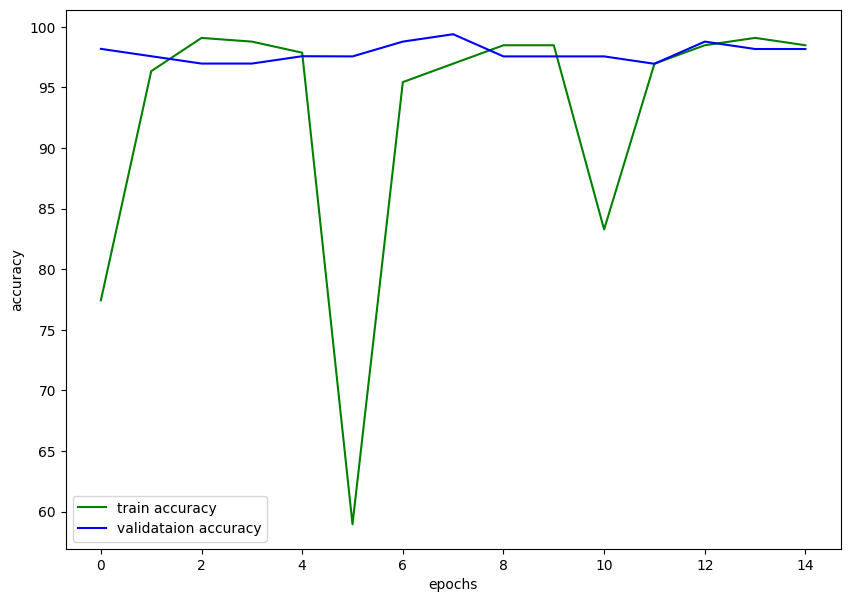

porcupine
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0138 Acc: 92.9878%
[Test #1] Loss: 0.0059 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0039 Acc: 97.8659%
[Test #2] Loss: 0.0033 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 98.4756%
[Test #3] Loss: 0.0021 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 98.7805%
[Test #4] Loss: 0.0040 Acc: 95.7576% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.1707%
[Test #5] Loss: 0.0026 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 90.5775%
[Test #1] Loss: 0.0055 Acc: 100.0000% 
Epoch 1 running
[Train #2] Loss: 0.0033 Acc: 99.3921%
[Test #2] Loss: 0.0037 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0023 Acc: 98.7842%
[Test #3] Loss: 0.0019 Acc: 99.3902% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.1763%
[Test #4] Loss: 0.0008 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.7842%
[Test #5] Loss: 0.0013 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 82.6748%
[Test

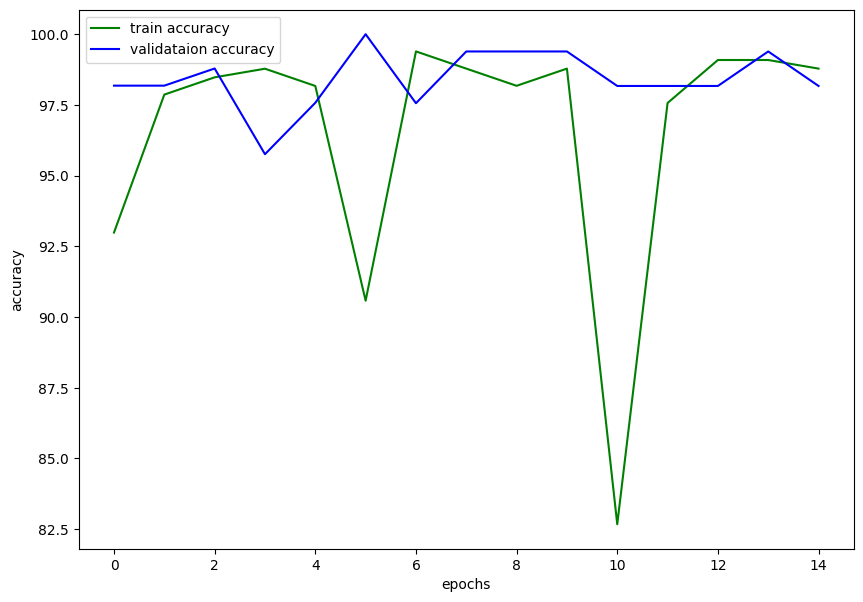

possum
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 90.5488%
[Test #1] Loss: 0.0072 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0070 Acc: 95.4268%
[Test #2] Loss: 0.0047 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.4756%
[Test #3] Loss: 0.0043 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.4756%
[Test #4] Loss: 0.0067 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.3902%
[Test #5] Loss: 0.0044 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0140 Acc: 93.0091%
[Test #1] Loss: 0.0095 Acc: 90.2439% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 96.3526%
[Test #2] Loss: 0.0064 Acc: 94.5122% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.1763%
[Test #3] Loss: 0.0047 Acc: 95.7317% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.4802%
[Test #4] Loss: 0.0058 Acc: 94.5122% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.1763%
[Test #5] Loss: 0.0051 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 90.5775%
[Test 

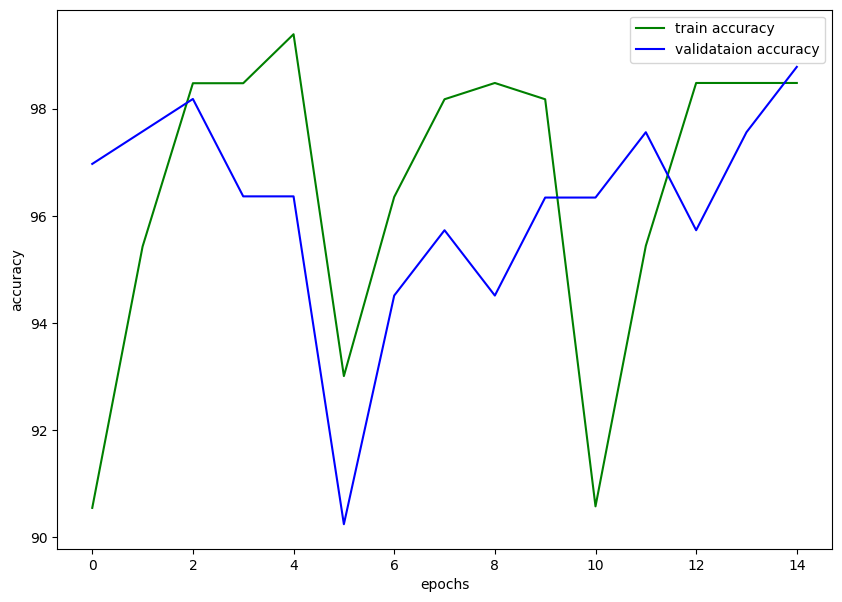

raccoon
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0255 Acc: 62.8049%
[Test #1] Loss: 0.0107 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 97.8659%
[Test #2] Loss: 0.0050 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0033 Acc: 97.8659%
[Test #3] Loss: 0.0056 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0024 Acc: 99.0854%
[Test #4] Loss: 0.0015 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.7805%
[Test #5] Loss: 0.0020 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0234 Acc: 68.3891%
[Test #1] Loss: 0.0091 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 96.9605%
[Test #2] Loss: 0.0066 Acc: 95.1220% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 98.1763%
[Test #3] Loss: 0.0038 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.0881%
[Test #4] Loss: 0.0036 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.4802%
[Test #5] Loss: 0.0034 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0235 Acc: 67.1733%
[Test 

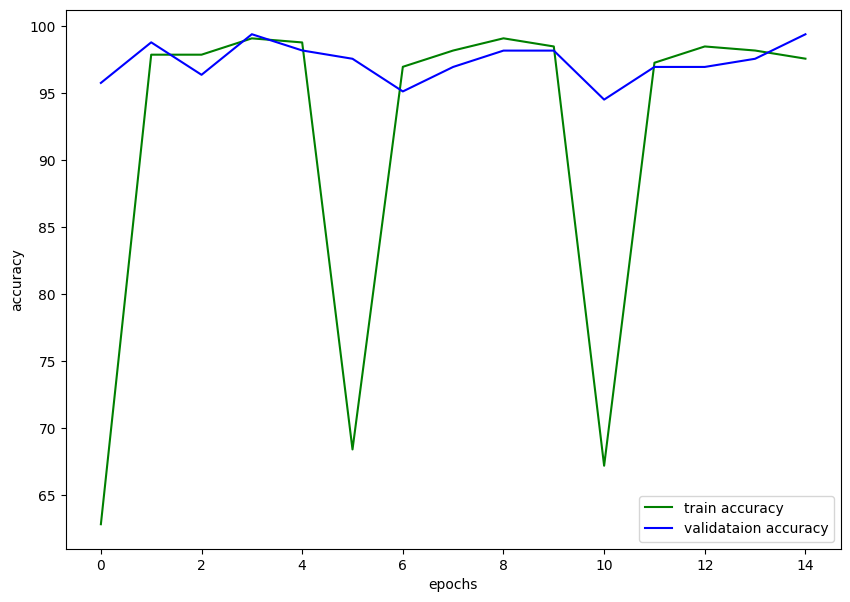

rat
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 91.4634%
[Test #1] Loss: 0.0081 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0062 Acc: 97.5610%
[Test #2] Loss: 0.0059 Acc: 94.5455% 
Epoch 2 running
[Train #3] Loss: 0.0036 Acc: 97.5610%
[Test #3] Loss: 0.0031 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.1707%
[Test #4] Loss: 0.0041 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0024 Acc: 98.4756%
[Test #5] Loss: 0.0043 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 86.0182%
[Test #1] Loss: 0.0082 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0070 Acc: 96.0486%
[Test #2] Loss: 0.0042 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0038 Acc: 97.2644%
[Test #3] Loss: 0.0048 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 99.0881%
[Test #4] Loss: 0.0054 Acc: 95.7317% 
Epoch 4 running
[Train #5] Loss: 0.0028 Acc: 98.4802%
[Test #5] Loss: 0.0069 Acc: 94.5122% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0272 Acc: 59.5745%
[Test 

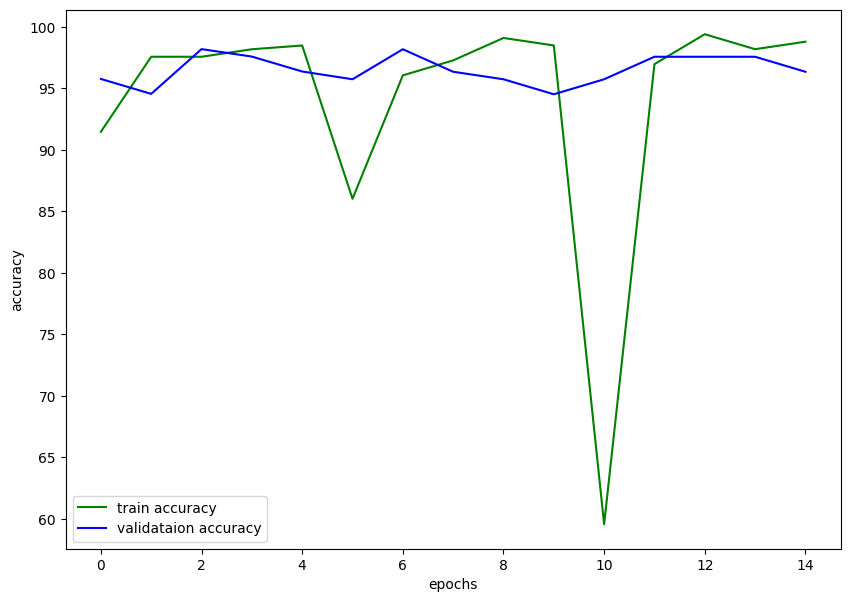

reindeer
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0141 Acc: 92.6829%
[Test #1] Loss: 0.0069 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0060 Acc: 97.5610%
[Test #2] Loss: 0.0042 Acc: 96.9697% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 97.8659%
[Test #3] Loss: 0.0027 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.4756%
[Test #4] Loss: 0.0037 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 98.4756%
[Test #5] Loss: 0.0029 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0163 Acc: 89.9696%
[Test #1] Loss: 0.0078 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0063 Acc: 95.7447%
[Test #2] Loss: 0.0050 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.7842%
[Test #3] Loss: 0.0031 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.3921%
[Test #4] Loss: 0.0013 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 98.7842%
[Test #5] Loss: 0.0019 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0228 Acc: 73.5562%
[Test

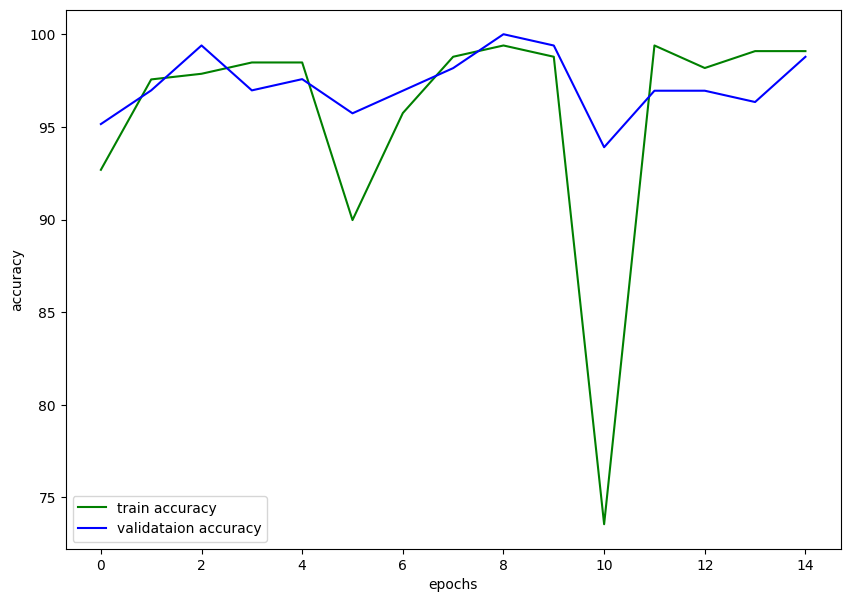

rhinoceros
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0149 Acc: 92.6829%
[Test #1] Loss: 0.0065 Acc: 95.7576% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 98.1707%
[Test #2] Loss: 0.0040 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7805%
[Test #3] Loss: 0.0029 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.4756%
[Test #4] Loss: 0.0038 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 99.0854%
[Test #5] Loss: 0.0084 Acc: 93.9394% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0168 Acc: 90.8815%
[Test #1] Loss: 0.0058 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0054 Acc: 97.5684%
[Test #2] Loss: 0.0035 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0038 Acc: 97.2644%
[Test #3] Loss: 0.0030 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.4802%
[Test #4] Loss: 0.0057 Acc: 95.7317% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.4802%
[Test #5] Loss: 0.0034 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0214 Acc: 75.9878%
[Test 

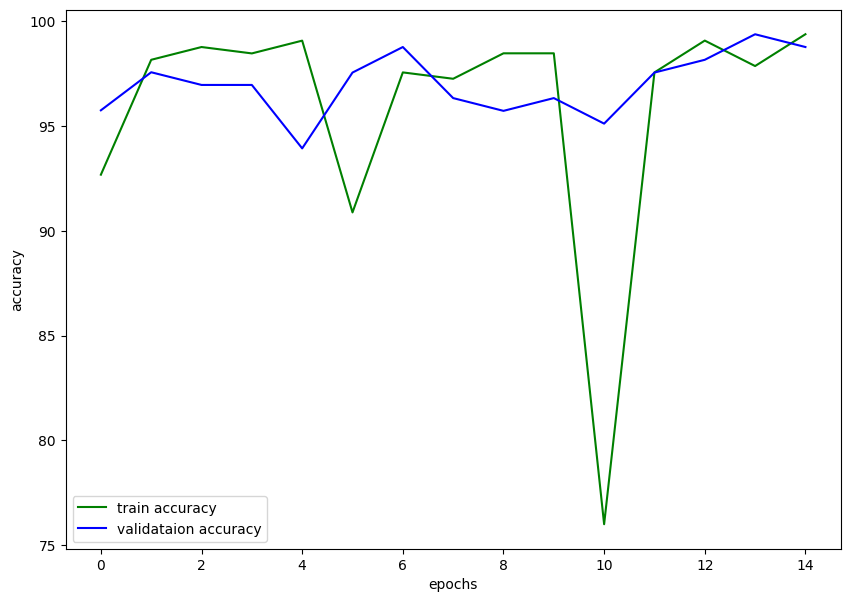

sandpiper
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 92.0732%
[Test #1] Loss: 0.0062 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0048 Acc: 98.1707%
[Test #2] Loss: 0.0032 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0024 Acc: 98.7805%
[Test #3] Loss: 0.0021 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.0854%
[Test #4] Loss: 0.0018 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0010 Acc: 100.0000%
[Test #5] Loss: 0.0029 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0269 Acc: 58.0547%
[Test #1] Loss: 0.0085 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0068 Acc: 96.6565%
[Test #2] Loss: 0.0037 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.1763%
[Test #3] Loss: 0.0020 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.1763%
[Test #4] Loss: 0.0018 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0023 Acc: 98.7842%
[Test #5] Loss: 0.0015 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0173 Acc: 87.5380%
[Te

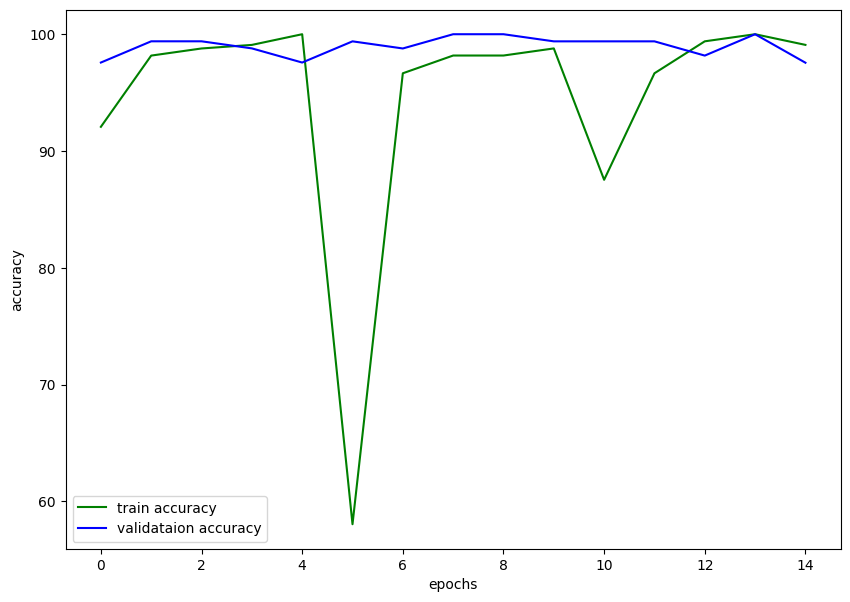

seahorse
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0149 Acc: 94.2073%
[Test #1] Loss: 0.0063 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 97.2561%
[Test #2] Loss: 0.0036 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0020 Acc: 99.3902%
[Test #3] Loss: 0.0031 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0015 Acc: 99.6951%
[Test #4] Loss: 0.0019 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.7805%
[Test #5] Loss: 0.0048 Acc: 96.3636% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0177 Acc: 86.9301%
[Test #1] Loss: 0.0083 Acc: 95.1220% 
Epoch 1 running
[Train #2] Loss: 0.0064 Acc: 97.2644%
[Test #2] Loss: 0.0054 Acc: 94.5122% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 99.3921%
[Test #3] Loss: 0.0036 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 98.7842%
[Test #4] Loss: 0.0031 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 99.3921%
[Test #5] Loss: 0.0041 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0147 Acc: 91.4894%
[Test 

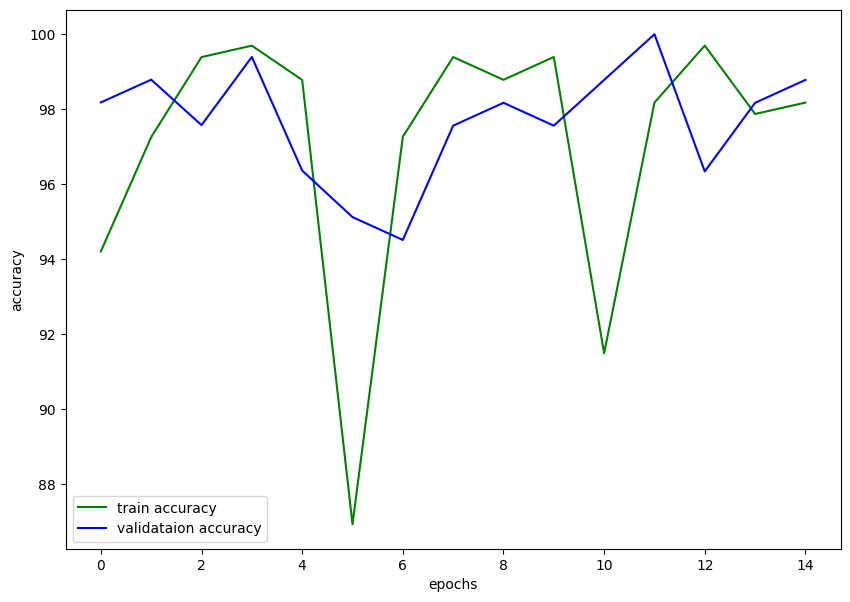

seal
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0139 Acc: 93.2927%
[Test #1] Loss: 0.0058 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0049 Acc: 97.2561%
[Test #2] Loss: 0.0044 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0024 Acc: 98.4756%
[Test #3] Loss: 0.0037 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0014 Acc: 98.7805%
[Test #4] Loss: 0.0032 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.0854%
[Test #5] Loss: 0.0028 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0211 Acc: 78.7234%
[Test #1] Loss: 0.0105 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0068 Acc: 97.2644%
[Test #2] Loss: 0.0070 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0042 Acc: 96.6565%
[Test #3] Loss: 0.0045 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0028 Acc: 99.0881%
[Test #4] Loss: 0.0046 Acc: 95.1220% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 99.0881%
[Test #5] Loss: 0.0031 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0188 Acc: 85.7143%
[Test 

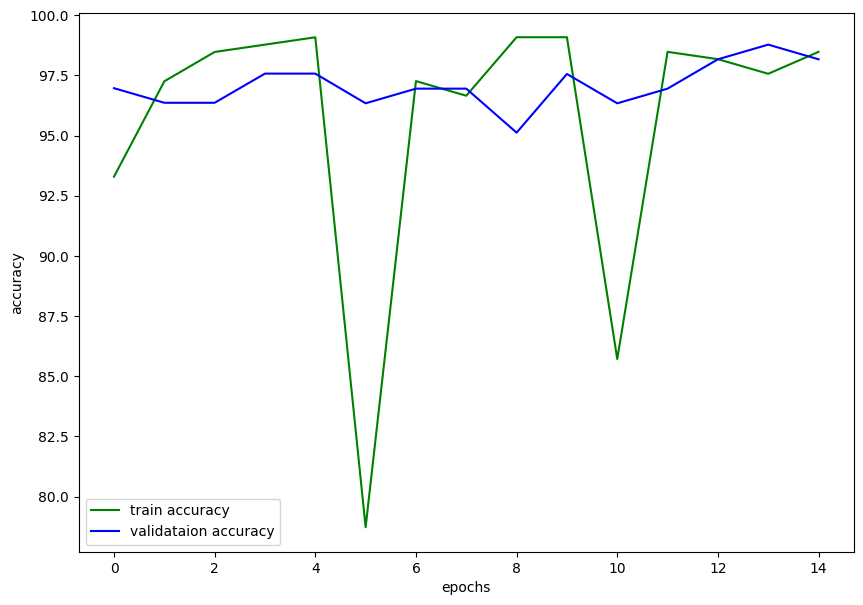

shark
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 84.1463%
[Test #1] Loss: 0.0068 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0045 Acc: 99.0854%
[Test #2] Loss: 0.0045 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 99.0854%
[Test #3] Loss: 0.0022 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 98.7805%
[Test #4] Loss: 0.0046 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 98.4756%
[Test #5] Loss: 0.0016 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0244 Acc: 68.0851%
[Test #1] Loss: 0.0091 Acc: 95.7317% 
Epoch 1 running
[Train #2] Loss: 0.0070 Acc: 96.6565%
[Test #2] Loss: 0.0083 Acc: 95.1220% 
Epoch 2 running
[Train #3] Loss: 0.0045 Acc: 97.5684%
[Test #3] Loss: 0.0054 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0032 Acc: 97.2644%
[Test #4] Loss: 0.0041 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 99.0881%
[Test #5] Loss: 0.0038 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0136 Acc: 93.6170%
[Test 

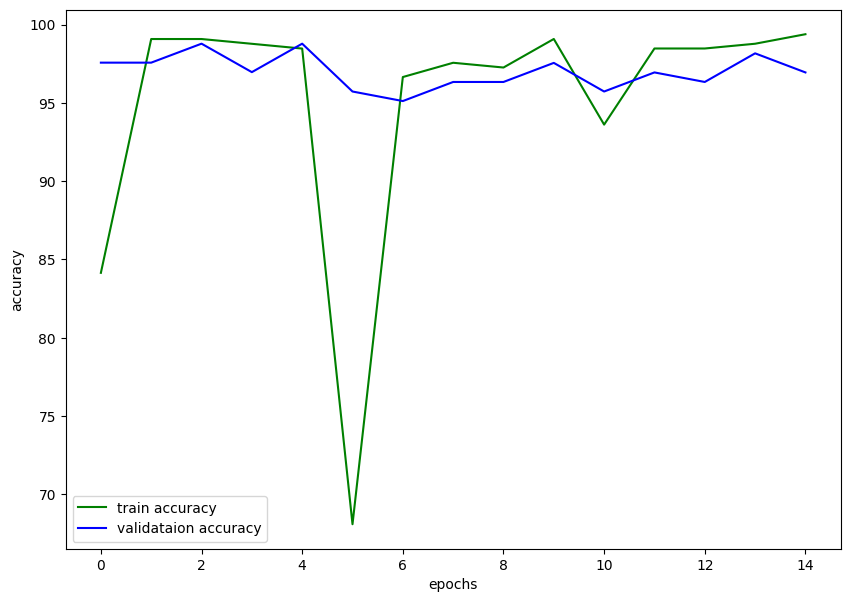

sheep
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0198 Acc: 86.5854%
[Test #1] Loss: 0.0088 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0060 Acc: 97.8659%
[Test #2] Loss: 0.0057 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.1707%
[Test #3] Loss: 0.0046 Acc: 97.5758% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 99.0854%
[Test #4] Loss: 0.0038 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.6951%
[Test #5] Loss: 0.0049 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0176 Acc: 90.5775%
[Test #1] Loss: 0.0082 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0057 Acc: 97.8723%
[Test #2] Loss: 0.0049 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 99.3921%
[Test #3] Loss: 0.0038 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0021 Acc: 98.7842%
[Test #4] Loss: 0.0036 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 98.7842%
[Test #5] Loss: 0.0047 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0156 Acc: 92.0973%
[Test 

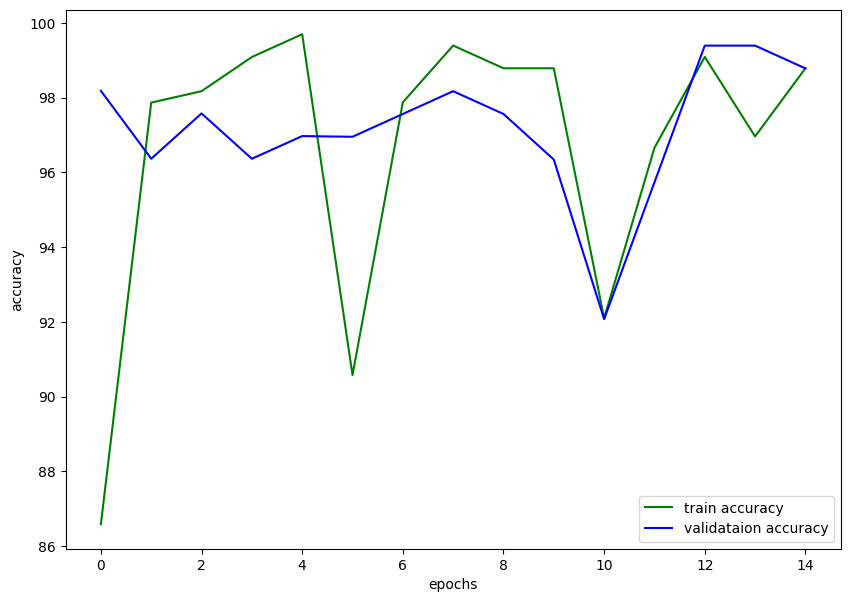

snake
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0188 Acc: 86.2805%
[Test #1] Loss: 0.0063 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0060 Acc: 98.4756%
[Test #2] Loss: 0.0037 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0027 Acc: 98.7805%
[Test #3] Loss: 0.0027 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0027 Acc: 98.1707%
[Test #4] Loss: 0.0030 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0024 Acc: 98.1707%
[Test #5] Loss: 0.0037 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0179 Acc: 88.7538%
[Test #1] Loss: 0.0082 Acc: 92.0732% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 99.3921%
[Test #2] Loss: 0.0057 Acc: 94.5122% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 98.7842%
[Test #3] Loss: 0.0035 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.0881%
[Test #4] Loss: 0.0023 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.3921%
[Test #5] Loss: 0.0036 Acc: 96.9512% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0159 Acc: 93.3131%
[Test 

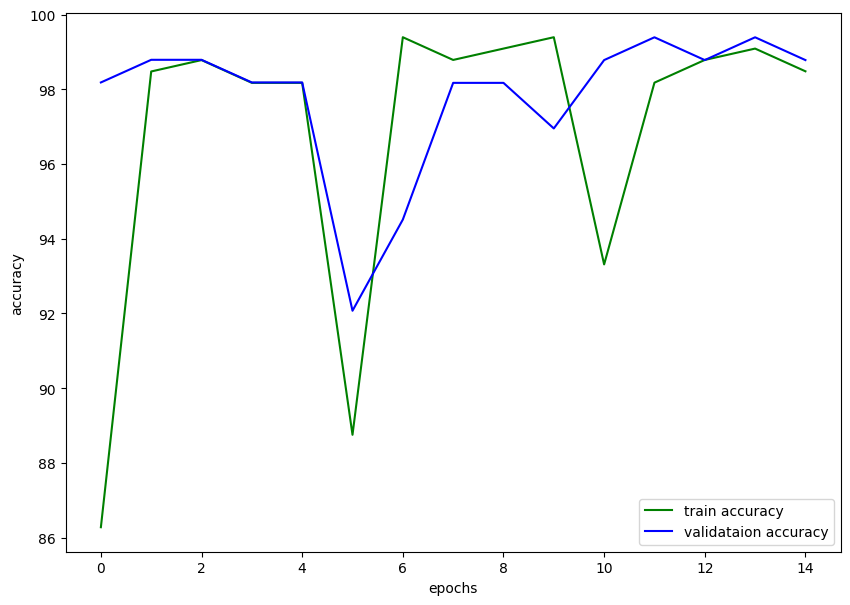

sparrow
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0143 Acc: 95.1220%
[Test #1] Loss: 0.0072 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0039 Acc: 98.7805%
[Test #2] Loss: 0.0034 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0026 Acc: 98.4756%
[Test #3] Loss: 0.0023 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 98.4756%
[Test #4] Loss: 0.0012 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.0854%
[Test #5] Loss: 0.0014 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0139 Acc: 94.5289%
[Test #1] Loss: 0.0063 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0043 Acc: 98.7842%
[Test #2] Loss: 0.0036 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0021 Acc: 99.3921%
[Test #3] Loss: 0.0034 Acc: 98.1707% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 99.0881%
[Test #4] Loss: 0.0035 Acc: 96.9512% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 99.6960%
[Test #5] Loss: 0.0035 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0171 Acc: 86.3222%
[Test 

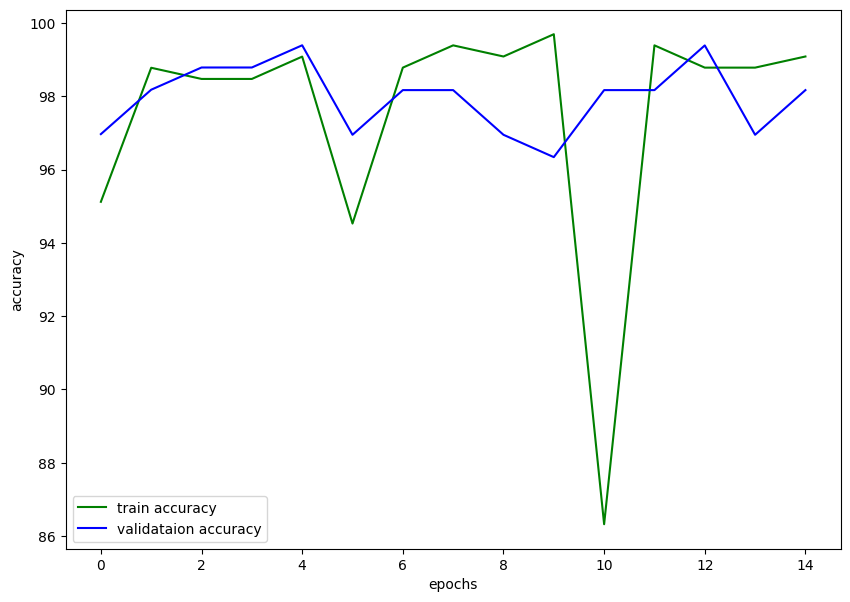

squid
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0172 Acc: 88.4146%
[Test #1] Loss: 0.0090 Acc: 93.3333% 
Epoch 1 running
[Train #2] Loss: 0.0077 Acc: 93.9024%
[Test #2] Loss: 0.0060 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0037 Acc: 98.4756%
[Test #3] Loss: 0.0036 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.1707%
[Test #4] Loss: 0.0024 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 99.3902%
[Test #5] Loss: 0.0031 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0205 Acc: 81.7629%
[Test #1] Loss: 0.0128 Acc: 92.6829% 
Epoch 1 running
[Train #2] Loss: 0.0065 Acc: 97.8723%
[Test #2] Loss: 0.0086 Acc: 93.2927% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 99.3921%
[Test #3] Loss: 0.0064 Acc: 94.5122% 
Epoch 3 running
[Train #4] Loss: 0.0029 Acc: 97.2644%
[Test #4] Loss: 0.0049 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 98.7842%
[Test #5] Loss: 0.0055 Acc: 95.7317% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0229 Acc: 71.4286%
[Test 

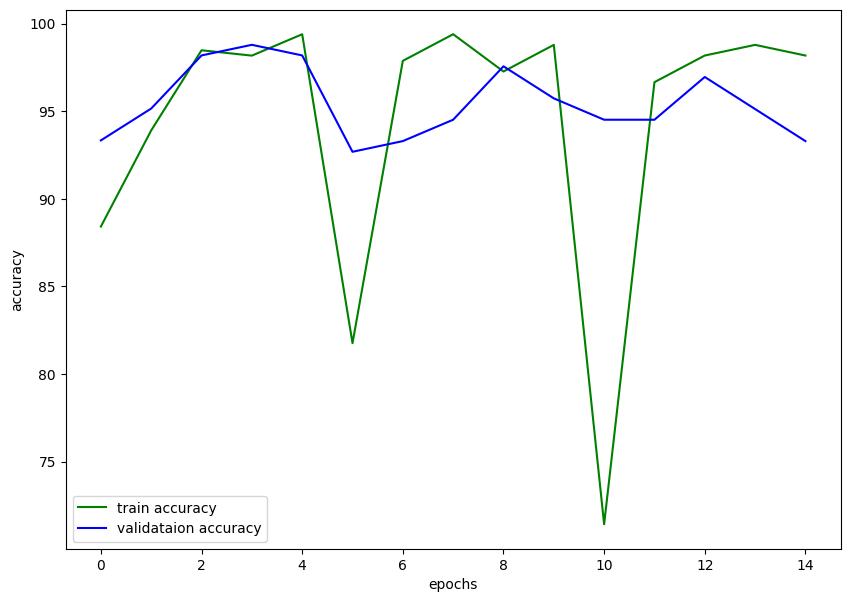

squirrel
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0145 Acc: 93.5976%
[Test #1] Loss: 0.0068 Acc: 96.9697% 
Epoch 1 running
[Train #2] Loss: 0.0055 Acc: 96.9512%
[Test #2] Loss: 0.0047 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 98.4756%
[Test #3] Loss: 0.0036 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0015 Acc: 99.3902%
[Test #4] Loss: 0.0032 Acc: 97.5758% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 99.0854%
[Test #5] Loss: 0.0039 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 80.2432%
[Test #1] Loss: 0.0085 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0069 Acc: 96.6565%
[Test #2] Loss: 0.0044 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0041 Acc: 96.9605%
[Test #3] Loss: 0.0030 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 99.3921%
[Test #4] Loss: 0.0028 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0022 Acc: 98.4802%
[Test #5] Loss: 0.0025 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0274 Acc: 57.4468%
[Test 

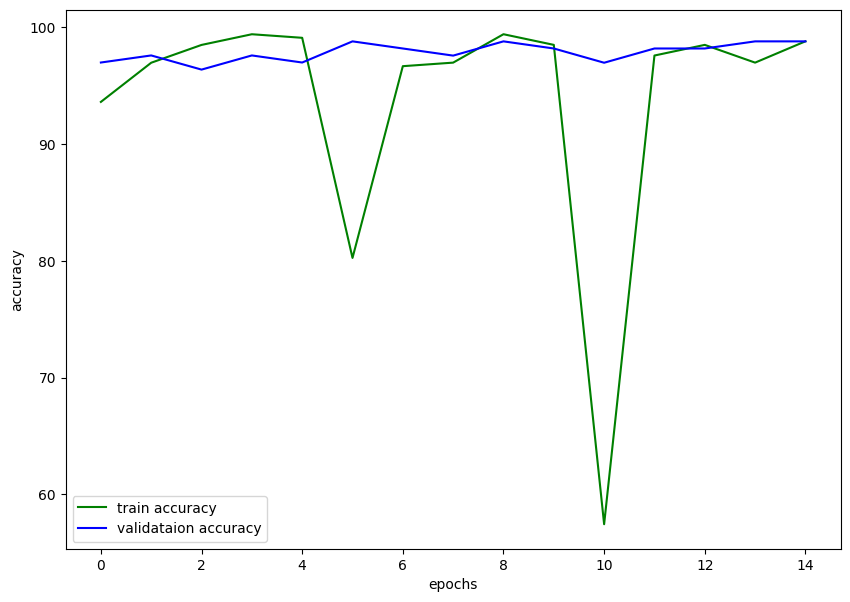

starfish
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0234 Acc: 68.5976%
[Test #1] Loss: 0.0061 Acc: 99.3939% 
Epoch 1 running
[Train #2] Loss: 0.0065 Acc: 98.4756%
[Test #2] Loss: 0.0039 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 97.8659%
[Test #3] Loss: 0.0019 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.4756%
[Test #4] Loss: 0.0028 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0011 Acc: 100.0000%
[Test #5] Loss: 0.0019 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0191 Acc: 81.7629%
[Test #1] Loss: 0.0063 Acc: 99.3902% 
Epoch 1 running
[Train #2] Loss: 0.0060 Acc: 97.8723%
[Test #2] Loss: 0.0036 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.7842%
[Test #3] Loss: 0.0028 Acc: 99.3902% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.0881%
[Test #4] Loss: 0.0024 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0020 Acc: 99.3921%
[Test #5] Loss: 0.0018 Acc: 99.3902% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0171 Acc: 90.5775%
[Test

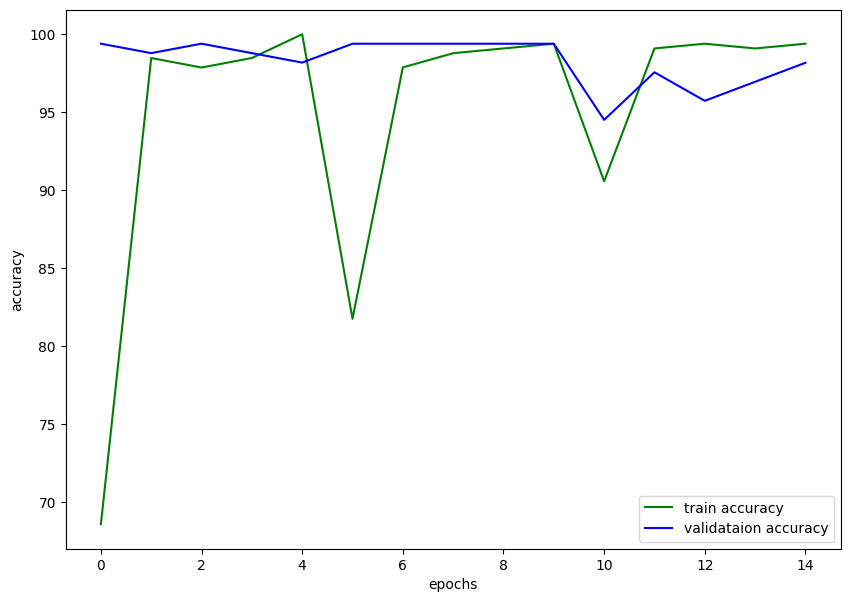

swan
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0245 Acc: 68.2927%
[Test #1] Loss: 0.0121 Acc: 93.9394% 
Epoch 1 running
[Train #2] Loss: 0.0074 Acc: 97.2561%
[Test #2] Loss: 0.0066 Acc: 95.7576% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 99.0854%
[Test #3] Loss: 0.0041 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0019 Acc: 99.6951%
[Test #4] Loss: 0.0046 Acc: 95.1515% 
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 99.3902%
[Test #5] Loss: 0.0066 Acc: 94.5455% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0176 Acc: 88.1459%
[Test #1] Loss: 0.0081 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0062 Acc: 97.8723%
[Test #2] Loss: 0.0067 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 97.8723%
[Test #3] Loss: 0.0048 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.3921%
[Test #4] Loss: 0.0049 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0021 Acc: 99.0881%
[Test #5] Loss: 0.0025 Acc: 98.1707% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0131 Acc: 96.0486%
[Test 

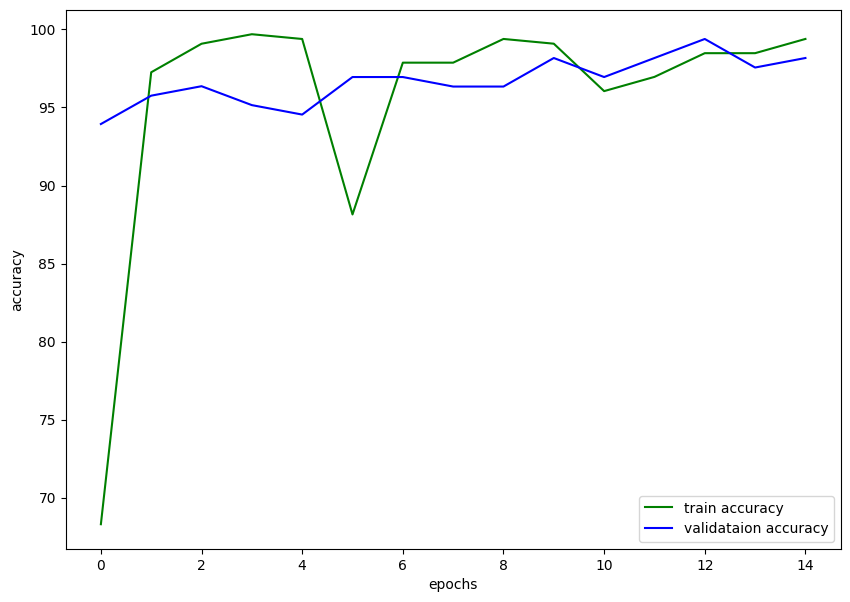

tiger
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0113 Acc: 97.5610%
[Test #1] Loss: 0.0041 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0037 Acc: 98.4756%
[Test #2] Loss: 0.0020 Acc: 100.0000% 
Epoch 2 running
[Train #3] Loss: 0.0019 Acc: 98.7805%
[Test #3] Loss: 0.0011 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.4756%
[Test #4] Loss: 0.0008 Acc: 100.0000% 
Epoch 4 running
[Train #5] Loss: 0.0025 Acc: 98.1707%
[Test #5] Loss: 0.0021 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0187 Acc: 85.7143%
[Test #1] Loss: 0.0058 Acc: 98.7805% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 98.4802%
[Test #2] Loss: 0.0021 Acc: 99.3902% 
Epoch 2 running
[Train #3] Loss: 0.0030 Acc: 98.4802%
[Test #3] Loss: 0.0014 Acc: 99.3902% 
Epoch 3 running
[Train #4] Loss: 0.0032 Acc: 97.8723%
[Test #4] Loss: 0.0022 Acc: 98.7805% 
Epoch 4 running
[Train #5] Loss: 0.0015 Acc: 99.0881%
[Test #5] Loss: 0.0017 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0181 Acc: 87.2340%
[Te

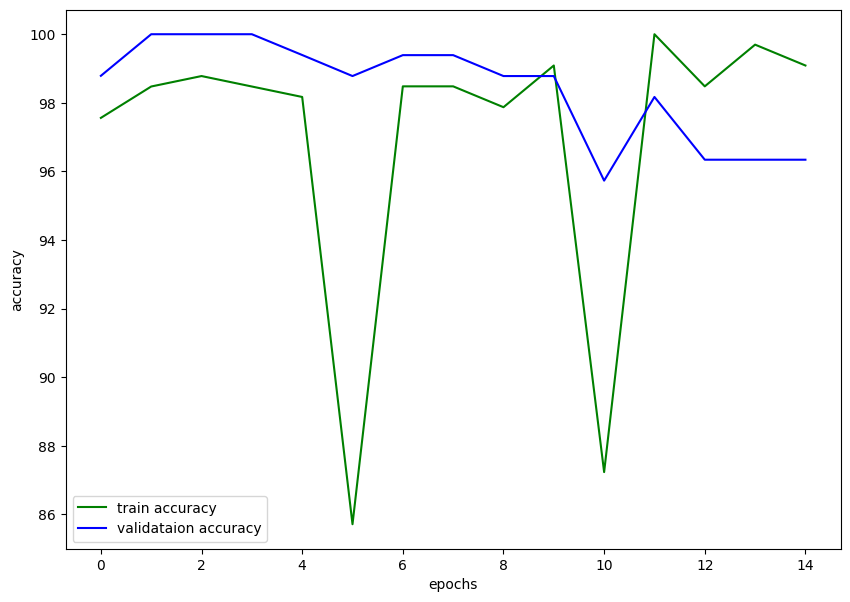

turkey
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0176 Acc: 87.5000%
[Test #1] Loss: 0.0090 Acc: 100.0000% 
Epoch 1 running
[Train #2] Loss: 0.0057 Acc: 98.1707%
[Test #2] Loss: 0.0046 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.4756%
[Test #3] Loss: 0.0026 Acc: 99.3939% 
Epoch 3 running
[Train #4] Loss: 0.0013 Acc: 99.0854%
[Test #4] Loss: 0.0021 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0027 Acc: 97.8659%
[Test #5] Loss: 0.0020 Acc: 98.7879% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0286 Acc: 54.4073%
[Test #1] Loss: 0.0131 Acc: 96.9512% 
Epoch 1 running
[Train #2] Loss: 0.0074 Acc: 97.8723%
[Test #2] Loss: 0.0054 Acc: 97.5610% 
Epoch 2 running
[Train #3] Loss: 0.0037 Acc: 98.1763%
[Test #3] Loss: 0.0035 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0026 Acc: 98.1763%
[Test #4] Loss: 0.0032 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0032 Acc: 97.5684%
[Test #5] Loss: 0.0030 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0153 Acc: 92.7052%
[Test

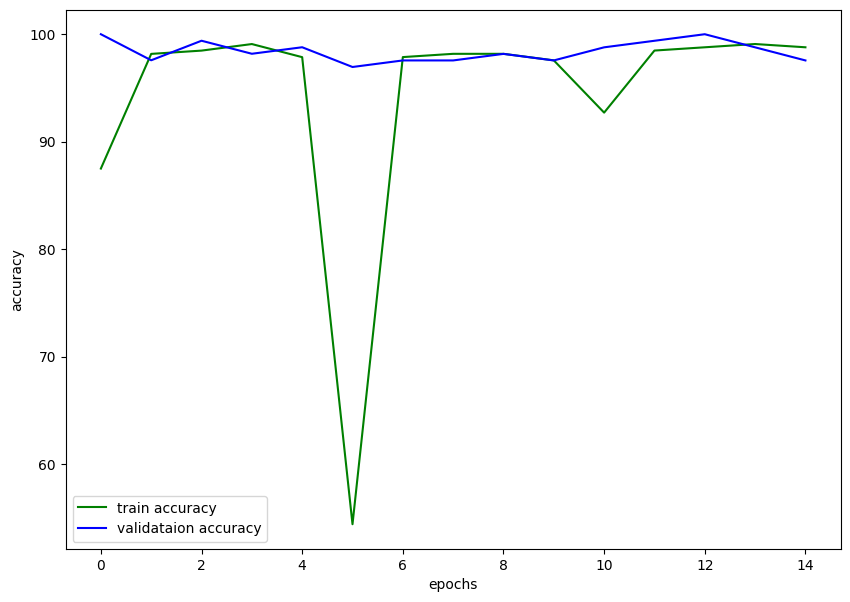

turtle
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0220 Acc: 78.0488%
[Test #1] Loss: 0.0083 Acc: 97.5758% 
Epoch 1 running
[Train #2] Loss: 0.0067 Acc: 98.4756%
[Test #2] Loss: 0.0062 Acc: 96.3636% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 98.4756%
[Test #3] Loss: 0.0044 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0025 Acc: 98.1707%
[Test #4] Loss: 0.0023 Acc: 98.1818% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.3902%
[Test #5] Loss: 0.0035 Acc: 96.9697% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0146 Acc: 94.5289%
[Test #1] Loss: 0.0083 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0049 Acc: 98.1763%
[Test #2] Loss: 0.0066 Acc: 95.7317% 
Epoch 2 running
[Train #3] Loss: 0.0028 Acc: 99.0881%
[Test #3] Loss: 0.0053 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0018 Acc: 99.0881%
[Test #4] Loss: 0.0034 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 99.0881%
[Test #5] Loss: 0.0065 Acc: 93.9024% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 84.1945%
[Test 

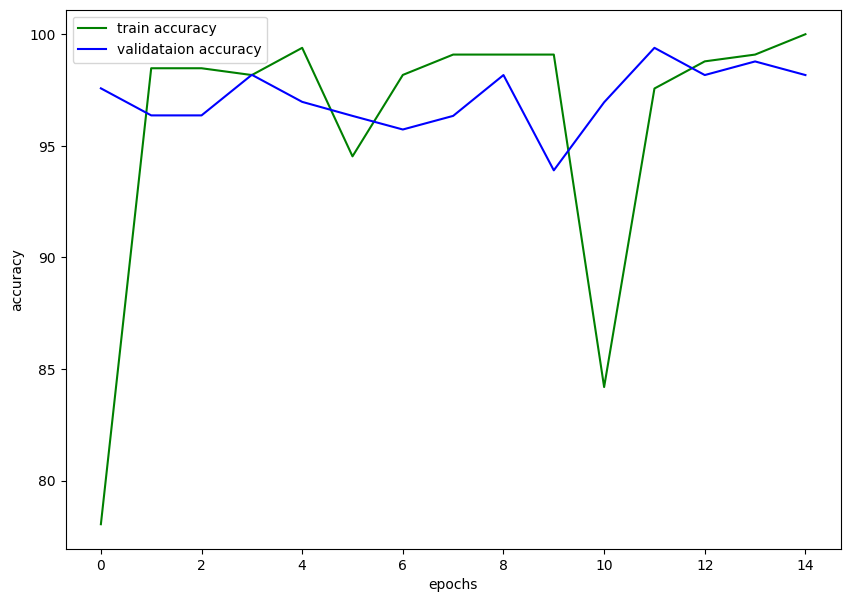

whale
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0182 Acc: 86.5854%
[Test #1] Loss: 0.0066 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0058 Acc: 96.9512%
[Test #2] Loss: 0.0046 Acc: 98.1818% 
Epoch 2 running
[Train #3] Loss: 0.0034 Acc: 98.4756%
[Test #3] Loss: 0.0040 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0020 Acc: 99.0854%
[Test #4] Loss: 0.0045 Acc: 96.3636% 
Epoch 4 running
[Train #5] Loss: 0.0030 Acc: 97.8659%
[Test #5] Loss: 0.0033 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0168 Acc: 90.2736%
[Test #1] Loss: 0.0081 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0054 Acc: 97.2644%
[Test #2] Loss: 0.0050 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 97.5684%
[Test #3] Loss: 0.0035 Acc: 97.5610% 
Epoch 3 running
[Train #4] Loss: 0.0017 Acc: 99.3921%
[Test #4] Loss: 0.0027 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 98.4802%
[Test #5] Loss: 0.0022 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0204 Acc: 82.0669%
[Test 

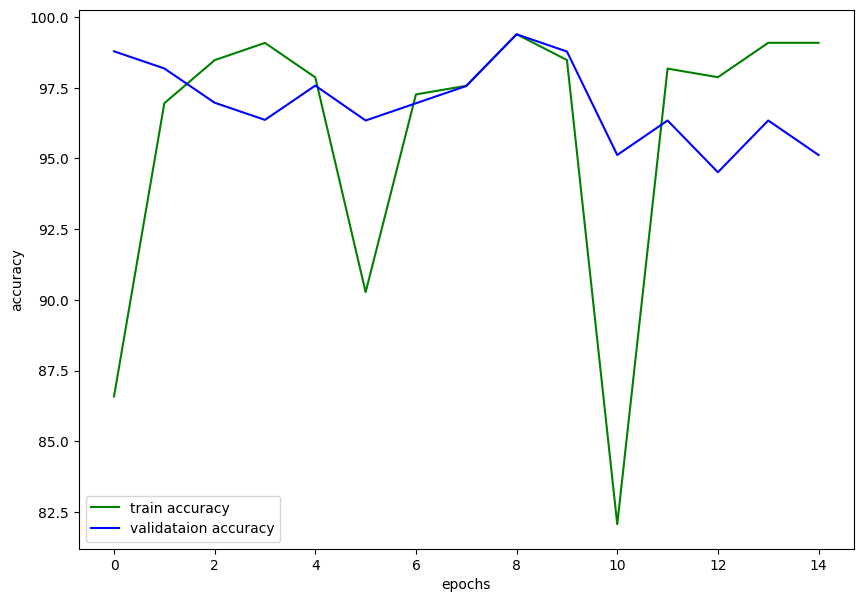

wolf
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0250 Acc: 61.2805%
[Test #1] Loss: 0.0085 Acc: 98.7879% 
Epoch 1 running
[Train #2] Loss: 0.0076 Acc: 97.8659%
[Test #2] Loss: 0.0062 Acc: 97.5758% 
Epoch 2 running
[Train #3] Loss: 0.0039 Acc: 98.7805%
[Test #3] Loss: 0.0032 Acc: 96.9697% 
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 99.6951%
[Test #4] Loss: 0.0038 Acc: 96.9697% 
Epoch 4 running
[Train #5] Loss: 0.0026 Acc: 99.0854%
[Test #5] Loss: 0.0033 Acc: 97.5758% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0233 Acc: 71.4286%
[Test #1] Loss: 0.0084 Acc: 98.1707% 
Epoch 1 running
[Train #2] Loss: 0.0065 Acc: 98.1763%
[Test #2] Loss: 0.0067 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0024 Acc: 99.0881%
[Test #3] Loss: 0.0054 Acc: 96.9512% 
Epoch 3 running
[Train #4] Loss: 0.0033 Acc: 98.4802%
[Test #4] Loss: 0.0043 Acc: 96.3415% 
Epoch 4 running
[Train #5] Loss: 0.0027 Acc: 98.1763%
[Test #5] Loss: 0.0052 Acc: 96.3415% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0228 Acc: 72.9483%
[Test 

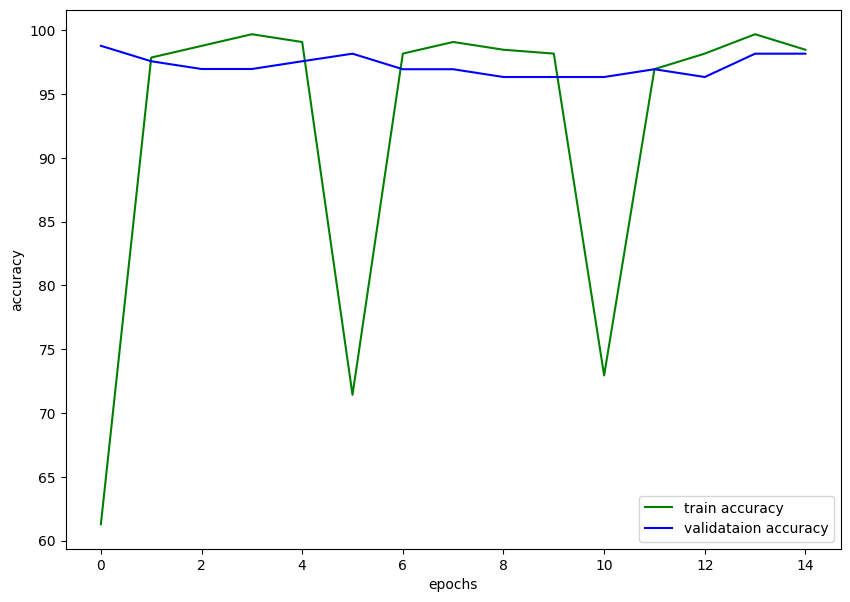

wombat
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0155 Acc: 92.6829%
[Test #1] Loss: 0.0059 Acc: 96.3636% 
Epoch 1 running
[Train #2] Loss: 0.0044 Acc: 98.7805%
[Test #2] Loss: 0.0045 Acc: 96.9697% 
Epoch 2 running
[Train #3] Loss: 0.0025 Acc: 98.7805%
[Test #3] Loss: 0.0069 Acc: 94.5455% 
Epoch 3 running
[Train #4] Loss: 0.0028 Acc: 97.5610%
[Test #4] Loss: 0.0052 Acc: 94.5455% 
Epoch 4 running
[Train #5] Loss: 0.0039 Acc: 96.0366%
[Test #5] Loss: 0.0039 Acc: 95.7576% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0202 Acc: 76.2918%
[Test #1] Loss: 0.0084 Acc: 97.5610% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 97.8723%
[Test #2] Loss: 0.0037 Acc: 98.7805% 
Epoch 2 running
[Train #3] Loss: 0.0029 Acc: 98.7842%
[Test #3] Loss: 0.0027 Acc: 98.7805% 
Epoch 3 running
[Train #4] Loss: 0.0012 Acc: 99.6960%
[Test #4] Loss: 0.0028 Acc: 98.1707% 
Epoch 4 running
[Train #5] Loss: 0.0019 Acc: 98.7842%
[Test #5] Loss: 0.0026 Acc: 98.7805% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0229 Acc: 71.1246%
[Test 

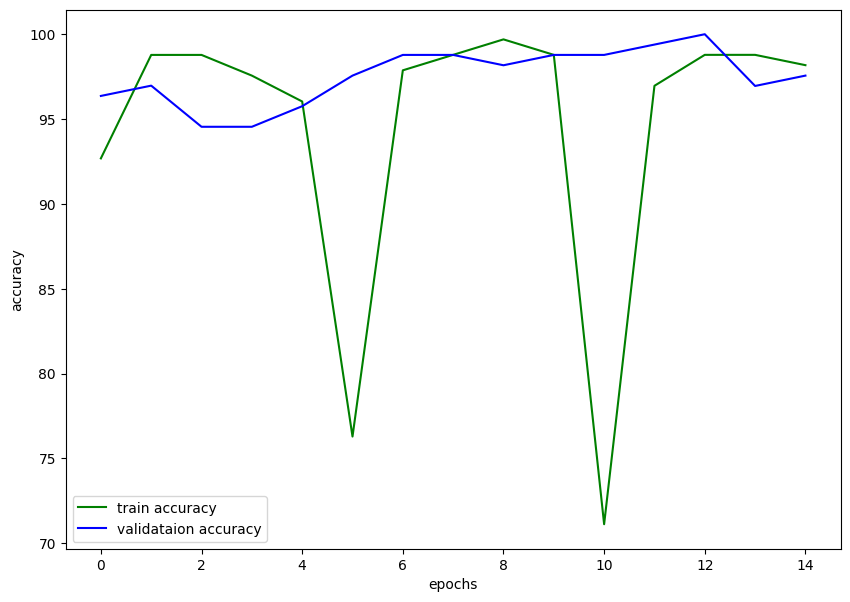

woodpecker
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0146 Acc: 93.9024%
[Test #1] Loss: 0.0055 Acc: 99.3939% 
Epoch 1 running
[Train #2] Loss: 0.0052 Acc: 97.5610%
[Test #2] Loss: 0.0027 Acc: 98.7879% 
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 98.7805%
[Test #3] Loss: 0.0025 Acc: 98.1818% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 99.0854%
[Test #4] Loss: 0.0030 Acc: 98.7879% 
Epoch 4 running
[Train #5] Loss: 0.0023 Acc: 98.1707%
[Test #5] Loss: 0.0033 Acc: 98.1818% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0163 Acc: 91.7933%
[Test #1] Loss: 0.0087 Acc: 96.3415% 
Epoch 1 running
[Train #2] Loss: 0.0053 Acc: 98.4802%
[Test #2] Loss: 0.0048 Acc: 96.9512% 
Epoch 2 running
[Train #3] Loss: 0.0024 Acc: 99.0881%
[Test #3] Loss: 0.0044 Acc: 96.3415% 
Epoch 3 running
[Train #4] Loss: 0.0022 Acc: 99.0881%
[Test #4] Loss: 0.0031 Acc: 97.5610% 
Epoch 4 running
[Train #5] Loss: 0.0014 Acc: 99.0881%
[Test #5] Loss: 0.0033 Acc: 97.5610% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0152 Acc: 90.8815%
[Test 

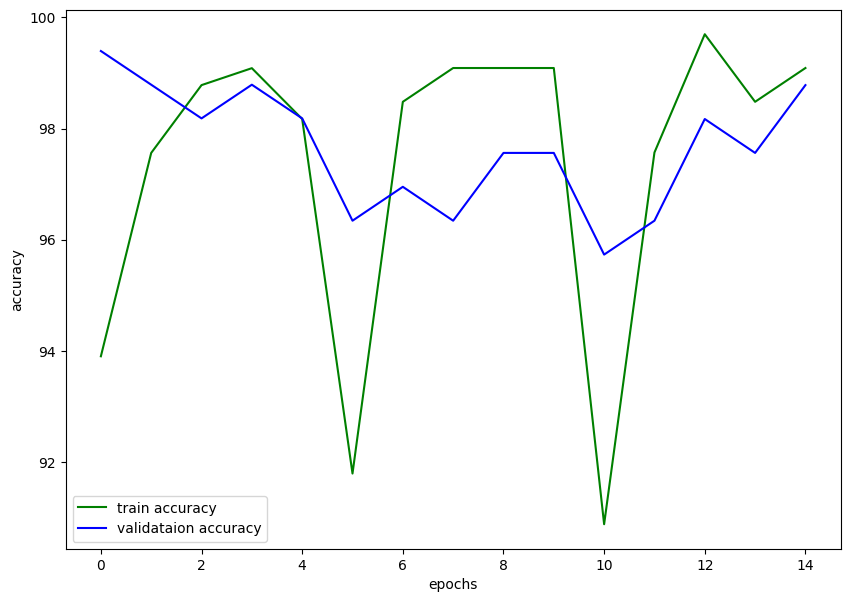

zebra
FOLD :  0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
[Train #1] Loss: 0.0278 Acc: 60.6707%
[Test #1] Loss: 0.0107 Acc: 98.1818% 
Epoch 1 running
[Train #2] Loss: 0.0087 Acc: 94.8171%
[Test #2] Loss: 0.0028 Acc: 99.3939% 
Epoch 2 running
[Train #3] Loss: 0.0044 Acc: 97.2561%
[Test #3] Loss: 0.0021 Acc: 98.7879% 
Epoch 3 running
[Train #4] Loss: 0.0032 Acc: 98.1707%
[Test #4] Loss: 0.0014 Acc: 99.3939% 
Epoch 4 running
[Train #5] Loss: 0.0016 Acc: 99.3902%
[Test #5] Loss: 0.0015 Acc: 99.3939% 
FOLD :  1
Epoch 0 running
[Train #1] Loss: 0.0218 Acc: 69.6049%
[Test #1] Loss: 0.0097 Acc: 98.1707% 
Epoch 1 running
[Train #2] Loss: 0.0046 Acc: 97.8723%
[Test #2] Loss: 0.0036 Acc: 98.1707% 
Epoch 2 running
[Train #3] Loss: 0.0031 Acc: 98.7842%
[Test #3] Loss: 0.0012 Acc: 100.0000% 
Epoch 3 running
[Train #4] Loss: 0.0023 Acc: 98.1763%
[Test #4] Loss: 0.0012 Acc: 99.3902% 
Epoch 4 running
[Train #5] Loss: 0.0008 Acc: 99.6960%
[Test #5] Loss: 0.0008 Acc: 100.0000% 
FOLD :  2
Epoch 0 running
[Train #1] Loss: 0.0129 Acc: 93.3131%
[Tes

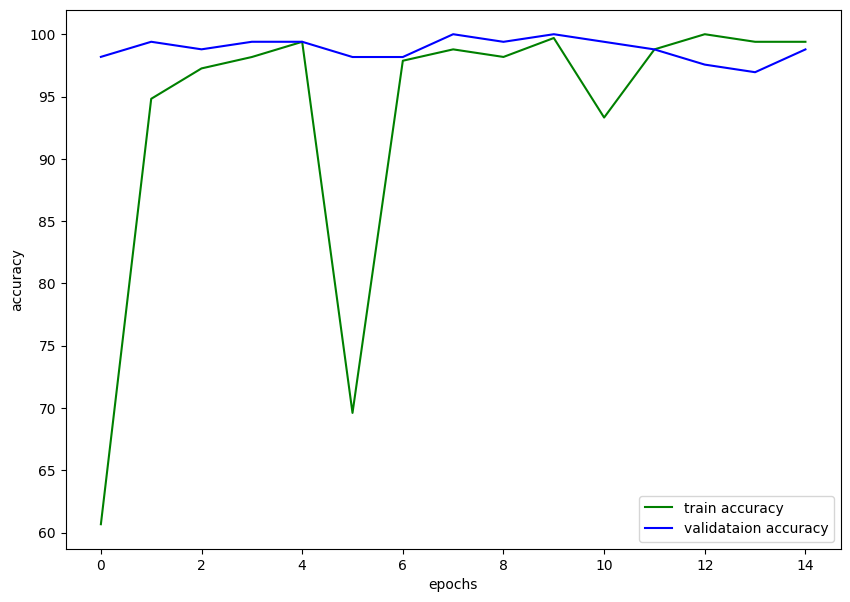

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from torchvision import models

class_list , _ = find_classes(train_path)

# Define Stratified K-Fold cross-validation
skf = KFold(n_splits=3, shuffle=True)

for i in range(len(class_list)):
  print(class_list[i])

  # Make the lists for the confusion Matrix
  true_labels = []
  predicted_labels = []

  # Load Custom Training Dataset And Testing Dataset

  train_dataset = CustomDataset(i , train_path , transform = transforms_train)
  test_dataset = CustomDataset(i , test_path , transform = transforms_test)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=24, shuffle=True, num_workers=4)

  #### Train model

  from sklearn.model_selection import KFold

  train_loss=[]
  train_accuracy=[]
  test_loss=[]
  test_accuracy=[]


  # Extract indices
  indices = list(range(len(train_dataset)))
  # Define Stratified K-Fold cross-validation
  skf = KFold(n_splits=3, shuffle=True)

  # Iterate over folds
  for fold, (train_index, val_index) in enumerate(skf.split(indices, [train_dataset.label[idx] for idx in indices])):
      print("FOLD : " , fold)
      train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
      val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

      # Create data loaders for training and validation
      train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, sampler=train_sampler, num_workers=4)
      val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, sampler=val_sampler, num_workers=4)

      model = models.resnet50(pretrained=True)

      # Since Resnet50 has 1000 out_features we will need to change it because our model has 1000 features.

      num_features = model.fc.in_features
      # Add a fully-connected layer for classification
      model.fc = nn.Linear(num_features, 2)
      model = model.to(device)

      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)




      num_epochs = 5
      for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch)) #(printing message)
        model.train()
        running_loss = 0
        running_corrects = 0
        total_train = 0

        # Now Load A Batch Of Images

        for i , (inputs , labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Forward Inputs and Get Outputs
          optimizer.zero_grad()
          outputs = model.forward(inputs)

          _ , preds = torch.max(outputs , 1)

          loss = criterion(outputs , labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          total_train += labels.size(0)

          running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_sampler)
        epoch_acc = running_corrects / total_train *100

        # Append Result

        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        # Print Progress

        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch+1, epoch_loss, epoch_acc))

        # Testing Part

        model.eval()
        with torch.no_grad():
          running_loss = 0
          running_corrects = 0
          total_val = 0

          for i , (inputs , labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            _ , preds = torch.max(outputs , 1)
            loss = criterion(outputs , labels)

            running_loss += loss.item()
            total_val += labels.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

          epoch_loss = running_loss / len(val_sampler)
          epoch_acc = running_corrects / total_val *100

          # Append result

          test_loss.append(epoch_loss)
          test_accuracy.append(epoch_acc)

          # Print progress
          print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch+1, epoch_loss, epoch_acc))

  with torch.no_grad():
    running_corrects = 0
    total_test = 0

    for i , (inputs , labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      _ , preds = torch.max(outputs , 1)
      running_corrects += torch.sum(preds == labels.data).item()
      total_test += labels.size(0)
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(preds.cpu().numpy())

    epoch_acc = running_corrects / total_test *100

    print('Confusion Matrix')
    print(confusion_matrix(true_labels, predicted_labels))


    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='green', label='train accuracy')
    plt.plot(test_accuracy, color='blue', label='validataion accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()











